# 2.3  파라미터 제약조건 처리 방법

- [1. Functions](#1.-Functions)
    - [1.1 SU](#1.1-SU)
    - [1.2 Log-normal](#1.2-Log-normal)
    - [1.3 GB2](#1.3-GB2)
- [2. Data](#2.-Data)
    - [2.1 미국 SCF 데이터](#2.1-미국-SCF-데이터)
    - [2.2 한국 가계금융복지조사 데이터](#2.2-한국-가계금융복지조사-데이터)
- [3. SCF 데이터 추정](#3.-SCF-데이터-추정)
    - [3.1 지니계수 계산 및 선행연구 결과와 비교](#3.1-지니계수-계산-및-선행연구-결과와-비교)
    - [3.2 Net Worth in 2022](#3.2-Net-Worth-in-2022)
    - [3.3 Income in 2022](#3.3-Income-in-2022)
    - [3.4 Income in 2022 with Log-normal](#3.4-Income-in-2022-with-Log-normal)
    - [3.5 Income in 2022 with GB2](#3.5-Income-in-2022-with-GB2)
- [4. 가계금융복지조사 데이터 추정](#4.-가계금융복지조사-데이터-추정)
    - [4.1 Net Worth in 2022](#4.1-Net-Worth-in-2022)
    - [4.2 Net Income in 2022](#4.2-Net-Income-in-2022)
- [참고 1: scipy opt.minimize 사용법](#참고-1:-scipy-opt.minimize-사용법)
- [참고 2: SymPy SU Hessian 구하기](#참고-2:-SymPy-SU-Hessian-구하기)
- [참고 3: Johnson SU 분포 Jacobian & Hessian Matrix](#참고-3:-Johnson-SU-분포-Jacobian-&-Hessian-Matrix)
- [참고 4: 정규분포 및 로그정규분포 데이터에 대한 SU 로렌츠 곡선 추정 결과](#참고-4:-정규분포-및-로그정규분포-데이터에-대한-SU-로렌츠-곡선-추정-결과)

# 2.3 SU 분포 Jacobian & Hessian Matrix

- [1 Functions](#1-Functions)
    - [1.1 SU](#1.1-SU)
    - [1.2 Log-normal](#1.2-Log-normal)
- [2 Data](#2-Data)
- [3 SCF 데이터 추정](#3-SCF-데이터-추정)
    - [3.1 지니계수 계산 및 선행연구 결과와 비교](#3.1-지니계수-계산-및-선행연구-결과와-비교)
    - [3.2 Net Worth in 2022](#3.2-Net-Worth-in-2022)
    - [3.3 Income in 2022](#3.3-Income-in-2022)
    - [3.4 Income in 2022 with Log-normal](#3.4-Income-in-2022-with-Log-normal)
- [부록: scipy opt.minimize 사용법](#부록:-scipy-opt.minimize-사용법)

## 1. Functions

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

### 1.1 SU

$$
\sinh^{-1}\left(\frac{X-m}{s}\right) = \lambda + \theta Z
$$
**PDF**
$$
f(x) = J \cdot \phi(z),
$$

where

$$
J = \theta^{-1} \left[(x-m)^2 + s^2\right]^{-1/2}, \quad z = \theta^{-1} \left[\sinh^{-1}\left(\frac{x-m}{s}\right) - \lambda\right]
$$

### PDF

In [2]:
def SU_pdf(x, m, s, lambda_, theta):

    J = 1/(theta*np.sqrt((x-m)**2+s**2))
    z = (np.arcsinh((x - m)/s) - lambda_)/theta
    pdf_vals = J*st.norm.pdf(z)
    
    return pdf_vals

### Log Likelihood Functions

#### 단순

In [3]:
def ll_SU(x, m, s, lambda_, theta):
    
    J = 1/(theta*np.sqrt((x-m)**2+s**2))
    z = (np.arcsinh((x - m)/s) - lambda_)/theta
       
    ln_pdf_vals = (np.log(J) - 0.5*np.log(2*np.pi) - 0.5*(z)**2)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

#### 가중

In [4]:
def weight_ll_SU(x, weight, m, s, lambda_, theta):
    
    J = 1/(theta*np.sqrt((x-m)**2+s**2))
    z = (np.arcsinh((x - m)/s) - lambda_)/theta
       
    ln_pdf_vals = weight*(np.log(J) - 0.5*np.log(2*np.pi) - 0.5*(z)**2)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

#### 파라미터 플러스값 제약조건 처리

`s`와 `theta`가 항상 양수이기 때문에 최적화 과정에서 이를 bounding하기 위해 이들 파라미터에 `exp`를 취해서 로그가능도 함수를 만든다. 따라서 이 경우 입력 파라미터는 bounding 조건이 사라지고 모든 실수값을 취할 수 있게 된다.

#### 단순(파라미터에 `exp` 취함)

In [5]:
def ll_SU_e(x, m, s, lambda_, theta):

    s = np.exp(s)
    theta = np.exp(theta)
    
    J = 1/(theta*np.sqrt((x-m)**2+s**2))
    z = (np.arcsinh((x - m)/s) - lambda_)/theta

    ln_pdf_vals = (np.log(J) - 0.5*np.log(2*np.pi) - 0.5*(z)**2)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

#### 가중(파라미터에 `exp` 취함)

In [6]:
def weight_ll_SU_e(x, weight, m, s, lambda_, theta):

    s = np.exp(s)
    theta = np.exp(theta)
    
    J = 1/(theta*np.sqrt((x-m)**2+s**2))
    z = (np.arcsinh((x - m)/s) - lambda_)/theta

    ln_pdf_vals = weight*(np.log(J) - 0.5*np.log(2*np.pi) - 0.5*(z)**2)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

### MLE Objective Functions

#### 단순

In [7]:
def obj_SU(params, *args):

    m, s, lambda_, theta = params
    x = args
    log_lik_val = ll_SU(x, m, s, lambda_, theta)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

#### 가중

In [8]:
def weight_obj_SU(params, *args):

    m, s, lambda_, theta = params
    (x, weight) = args
    log_lik_val = weight_ll_SU(x, weight, m, s, lambda_, theta)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

#### 단순(파라미터에 `exp` 취함)

In [9]:
def obj_SU_e(params, *args):

    m, s, lambda_, theta = params
    x = args
    
    log_lik_val = ll_SU_e(x, m, s, lambda_, theta)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

#### 가중(파라미터에 `exp` 취함)

In [10]:
def weight_obj_SU_e(params, *args):

    m, s, lambda_, theta = params
    (x, weight) = args
    
    log_lik_val = weight_ll_SU_e(x, weight, m, s, lambda_, theta)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

### Mean and Variance

In [11]:
def SU_mean(m, s, lambda_, theta):
    
    w = np.exp(theta**2)
    mean = m + s*w**(0.5)*np.sinh(lambda_)

    return mean

def SU_var(m, s, lambda_, theta):
    
    w = np.exp(theta**2)
    variance = 0.5*(s**2)*(w-1)*(w*np.cosh(2*lambda_)+1) 

    return variance

def SU_skew(m, s, lambda_, theta):
    
    w = np.exp(theta**2)
    sigma = (0.5*(s**2)*(w-1)*(w*np.cosh(2*lambda_)+1))**(0.5)
    mu_3 = 0.25*(s**3)*w**(0.5)*(w-1)**2*(w*(w+2)*np.sinh(3*lambda_)+3*np.sinh(lambda_))
    skewness = mu_3/(sigma**3)
        
    return skewness

def SU_kurt(m, s, lambda_, theta):
    
    w = np.exp(theta**2)
    sigma = (0.5*(s**2)*(w-1)*(w*np.cosh(2*lambda_)+1))**(0.5)
    mu_4 = 0.125*(s**4)*(w-1)**2*((w**2)*(w**4+2*w**3+3*w**2-3)*np.cosh(4*lambda_)
                                  + 4*(w**2)*(w+2)*np.cosh(2*lambda_) 
                                  + 3*(2*w+1))
    kurtosis = mu_4/(sigma**4)
        
    return kurtosis

### CDF and PPF

- PPF stands for Probability Point Function. The PPF is the inverse of the CDF (cumulative distribution function). It returns the exact point where the probability of everything to the left is equal to y.

In [12]:
def SU_cdf(x, m, s, lambda_, theta):
    
    z = (np.arcsinh((x - m)/s) - lambda_)/theta
    prob  = st.norm.cdf(z) 

    return prob

def SU_ppf(prob, m, s, lambda_, theta):
    
    x  = np.sinh(st.norm.ppf(prob)*theta + lambda_)*s + m

    return x

### Lorenz Curve

In [13]:
def Lorenz_SU(p, m, s, lambda_, theta):
    
    w = np.exp(theta**2)
    v = (np.exp(lambda_)*st.norm.cdf(st.norm.ppf(p) - theta)
         - np.exp(-lambda_)*st.norm.cdf(st.norm.ppf(p) + theta))
    num = m*p + 0.5*s*w**0.5*v
    den = m + s*w**0.5*np.sinh(lambda_)
    Lorenz  = num/den

    return Lorenz

$$
L(p) = \frac{1}{m + s \omega^{1/2} \sinh(\lambda)}\left\{mp + \frac{1}{2} s \omega^{1/2} \exp(\lambda)\Phi\left(\Phi^{-1}(p) - \theta\right) - \exp(-\lambda)\Phi\left(\Phi^{-1}(p) + \theta\right)\right\}
$$

where $\omega = \exp(\theta^2)$.

#### SU 로렌츠 곡선 적분

- $S_U$ 로렌츠 곡선은 아래에서 보듯이 적분 결과를 closed form으로 얻을 수 없으며, 따라서 수치 적분(numerical integration)으로 지니계수를 계산해야 한다.

In [14]:
from sympy import symbols, exp, sqrt, sinh, erf, erfinv, integrate, S

# 심볼 정의
m, s, theta, lambda_, p = symbols('m s theta lambda_ p')
omega = exp(theta**2)  # omega 정의

# Phi 역함수
Phi_inv_p = sqrt(2) * erfinv(2*p - 1)

# v 정의
Phi_1 = 1/2 * (1 + erf((Phi_inv_p - theta) / sqrt(2)))
Phi_2 = 1/2 * (1 + erf((Phi_inv_p + theta) / sqrt(2)))
v = exp(lambda_) * Phi_1 - exp(-lambda_) * Phi_2

# 로렌츠 곡선
L = (m*p + (1/2) * s * sqrt(omega) * v) / (m + s * sqrt(omega) * sinh(lambda_))

# 적분 수행
gini = 1 - 2*integrate(L, (p, 0, 1))

print(gini)
gini

1 + 2.0*(1.0*Integral(0.25*s*sqrt(exp(theta**2)), (p, 0, 1)) + 1.0*Integral(-1.0*m*p*exp(lambda_), (p, 0, 1)) + 1.0*Integral(-0.25*s*exp(2*lambda_)*sqrt(exp(theta**2)), (p, 0, 1)) + 1.0*Integral(0.25*s*sqrt(exp(theta**2))*erf(sqrt(2)*theta/2 + erfinv(2*p - 1)), (p, 0, 1)) + 1.0*Integral(0.25*s*exp(2*lambda_)*sqrt(exp(theta**2))*erf(sqrt(2)*theta/2 - erfinv(2*p - 1)), (p, 0, 1)))*exp(-lambda_)/(m + s*sqrt(exp(theta**2))*sinh(lambda_))


1 + 2.0*(1.0*Integral(0.25*s*sqrt(exp(theta**2)), (p, 0, 1)) + 1.0*Integral(-1.0*m*p*exp(lambda_), (p, 0, 1)) + 1.0*Integral(-0.25*s*exp(2*lambda_)*sqrt(exp(theta**2)), (p, 0, 1)) + 1.0*Integral(0.25*s*sqrt(exp(theta**2))*erf(sqrt(2)*theta/2 + erfinv(2*p - 1)), (p, 0, 1)) + 1.0*Integral(0.25*s*exp(2*lambda_)*sqrt(exp(theta**2))*erf(sqrt(2)*theta/2 - erfinv(2*p - 1)), (p, 0, 1)))*exp(-lambda_)/(m + s*sqrt(exp(theta**2))*sinh(lambda_))

### 1.2 Log-normal

$$
\ln(X) = \mu + \sigma Z
$$
**PDF**
$$
f(x) = J \cdot \phi(z),
$$

where

$$
J = \frac{1}{\sigma x}, \quad z = \frac{\ln(x) - \mu}{\sigma}
$$

### PDF

In [15]:
def LN_pdf(x, mu, sigma):

    J = 1/(sigma*x)
    z = (np.log(x) - mu)/sigma
    pdf_vals = J*st.norm.pdf(z)
    
    return pdf_vals

### Log Likelihood Functions

#### 단순

In [16]:
def ll_LN(x, mu, sigma):
    
    J = 1/(sigma*x)
    z = (np.log(x) - mu)/sigma
       
    ln_pdf_vals = (np.log(J) - 0.5*np.log(2*np.pi) - 0.5*(z)**2)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

#### 가중

In [17]:
def weight_ll_LN(x, weight, mu, sigma):
    
    J = 1/(sigma*x)
    z = (np.log(x) - mu)/sigma
       
    ln_pdf_vals = weight*(np.log(J) - 0.5*np.log(2*np.pi) - 0.5*(z)**2)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

#### 단순(파라미터에 `exp` 취함)

In [18]:
def ll_LN_e(x, mu, sigma):

    sigma = np.exp(sigma)
    
    J = 1/(sigma*x)
    z = (np.log(x) - mu)/sigma

    ln_pdf_vals = (np.log(J) - 0.5*np.log(2*np.pi) - 0.5*(z)**2)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

#### 가중(파라미터에 `exp` 취함)

In [19]:
def weight_ll_LN_e(x, weight, mu, sigma):

    sigma = np.exp(sigma)
    
    J = 1/(sigma*x)
    z = (np.log(x) - mu)/sigma

    ln_pdf_vals = weight*(np.log(J) - 0.5*np.log(2*np.pi) - 0.5*(z)**2)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

### MLE Objective Functions

#### 단순

In [20]:
def obj_LN(params, *args):

    mu, sigma = params
    x = args
    log_lik_val = ll_LN(x, mu, sigma)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

#### 가중

In [21]:
def weight_obj_LN(params, *args):

    mu, sigma = params
    (x, weight) = args
    log_lik_val = weight_ll_LN(x, weight, mu, sigma)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

#### 단순(파라미터에 `exp` 취함)

In [22]:
def obj_LN_e(params, *args):

    mu, sigma = params
    x = args
    
    log_lik_val = ll_LN_e(x, mu, sigma)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

#### 가중(파라미터에 `exp` 취함)

In [23]:
def weight_obj_LN_e(params, *args):

    mu, sigma = params
    (x, weight) = args
    
    log_lik_val = weight_ll_LN_e(x, weight, mu, sigma)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

### Mean and Variance

$$
\text{Mean:  }\exp\left(\mu + \frac{\sigma^2}{2}\right)
$$

$$
\text{Variance:  }\left[\exp(\sigma^2) - 1\right] \exp\left(2\mu + \sigma^2\right)
$$

In [24]:
def LN_mean(mu, sigma):
    
    mean = np.exp(mu + sigma**2/2)

    return mean

def LN_var(mu, sigma):
    
    variance = (np.exp(sigma**2) - 1)*np.exp(2*mu + sigma**2) 

    return variance

def LN_skewness(mu, sigma):
    
    skewness = (np.exp(sigma**2) + 2) * np.sqrt(np.exp(sigma**2) - 1)
    
    return skewness

def LN_kurtosis(mu, sigma):
    
    kurtosis = np.exp(4*sigma**2) + 2*np.exp(3*sigma**2) + 3*np.exp(2*sigma**2) - 3
    
    return kurtosis 

### CDF and PPF

In [25]:
def LN_cdf(x, mu, sigma):
    
    z = (np.log(x) - mu)/sigma
    prob  = st.norm.cdf(z) 

    return prob

def LN_ppf(prob, mu, sigma):
    
    x  = np.exp(st.norm.ppf(prob)*sigma + mu)

    return x

### Lorenz Curve

$$
L(p) = \Phi\left(\Phi^{-1}(p) - \sigma\right)
$$

In [26]:
from scipy.stats import norm

def Lorenz_LN(p, sigma):
    Phi_inv = norm.ppf(p)  # Φ^{-1}(p), 표준정규분포의 CDF의 역함수
    L_p = norm.cdf(Phi_inv - sigma)
    return L_p

### 참고:  정규분포 로렌츠 곡선

$$
L(p) = p - \frac{\sigma}{\mu} \phi\left(\Phi^{-1}(p)\right)
$$

In [27]:
from scipy.stats import norm

def Lorenz_normal(p, mu, sigma):
    Phi_inv = norm.ppf(p)  # Φ^{-1}(p), 표준정규분포의 CDF의 역함수
    phi = norm.pdf(Phi_inv)  # ϕ(Φ^{-1}(p)), 표준정규분포의 PDF
    
    L_p = p - (sigma / mu) * phi
    return L_p

### 1.3 GB2

The GB2 distribution whose probability density function (pdf) is given by

$$ f(y|a,b,p,q) = \frac{a y^{ap-1}}{b^{ap} B(p, q) \left(1 + \left(\frac{y}{b}\right)^a\right)^{p+q}} 
$$

where $a > 0$, $b > 0$, $p > 0$ and $q > 0$ are its parameters and $B(p, q)$ is the beta function.


### PDF

In [28]:
from scipy.special import beta

def GB2_pdf(x, a, b, p, q):

    num = a * x**(a*p-1)
    den = b**(a*p) * beta(p,q) * (1 + (x/b)**a)**(p+q)
    pdf_vals = num / den
    
    return pdf_vals

In [29]:
# Example usage
y_val = 2.0
a, b, p, q = 1.5, 2.0, 3.0, 4.0
pdf_value = GB2_pdf(y_val, a, b, p, q)
print("PDF Value:", pdf_value)

PDF Value: 0.35156250000000006


### Log Likelihood Functions

#### 단순

In [30]:
def ll_GB2(x, a, b, p, q):
    
    num = a * x**(a*p-1)
    den = b**(a*p) * beta(p,q) * (1 + (x/b)**a)**(p+q)
    pdf_vals = num / den

    ln_num = np.log(a) + (a*p-1)*np.log(x)
    ln_den = (a*p)*np.log(b) + np.log(beta(p,q)) + (p+q)*np.log(1 + (x/b)**a)
       
    ln_pdf_vals = ln_num - ln_den
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

#### 가중

In [31]:
def weight_ll_GB2(x, weight, a, b, p, q):
    
    num = a * x**(a*p-1)
    den = b**(a*p) * beta(p,q) * (1 + (x/b)**a)**(p+q)
    pdf_vals = num / den

    ln_num = np.log(a) + (a*p-1)*np.log(x)
    ln_den = (a*p)*np.log(b) + np.log(beta(p,q)) + (p+q)*np.log(1 + (x/b)**a)
       
    ln_pdf_vals = weight*(ln_num - ln_den)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

#### 단순(파라미터에 `exp` 취함)

In [32]:
def ll_GB2_e(x, a, b, p, q):

    a = np.exp(a)
    b = np.exp(b)
    p = np.exp(p)
    q = np.exp(q)
    
    num = a * x**(a*p-1)
    den = b**(a*p) * beta(p,q) * (1 + (x/b)**a)**(p+q)
    pdf_vals = num / den

    ln_num = np.log(a) + (a*p-1)*np.log(x)
    ln_den = (a*p)*np.log(b) + np.log(beta(p,q)) + (p+q)*np.log(1 + (x/b)**a)
       
    ln_pdf_vals = ln_num - ln_den
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

#### 가중(파라미터에 `exp` 취함)

In [33]:
def weight_ll_GB2_e(x, weight, a, b, p, q):

    a = np.exp(a)
    b = np.exp(b)
    p = np.exp(p)
    q = np.exp(q)
    
    num = a * x**(a*p-1)
    den = b**(a*p) * beta(p,q) * (1 + (x/b)**a)**(p+q)
    pdf_vals = num / den

    ln_num = np.log(a) + (a*p-1)*np.log(x)
    ln_den = (a*p)*np.log(b) + np.log(beta(p,q)) + (p+q)*np.log(1 + (x/b)**a)
       
    ln_pdf_vals = weight*(ln_num - ln_den)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

### MLE Objective Functions

#### 단순

In [34]:
def obj_GB2(params, *args):

    a, b, p, q = params
    x = args
    log_lik_val = ll_GB2(x, a, b, p, q)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

#### 가중

In [35]:
def weight_obj_GB2(params, *args):

    a, b, p, q = params
    (x, weight) = args
    log_lik_val = weight_ll_GB2(x, weight, a, b, p, q)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

#### 단순(파라미터에 `exp` 취함)

In [36]:
def obj_GB2_e(params, *args):

    a, b, p, q = params
    x = args
    
    log_lik_val = ll_GB2_e(x, a, b, p, q)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

#### 가중(파라미터에 `exp` 취함)

In [37]:
def weight_obj_GB2_e(params, *args):

    a, b, p, q = params
    (x, weight) = args
    
    log_lik_val = weight_ll_GB2_e(x, weight, a, b, p, q)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

### CDF and PPF

In [38]:
def GB2_cdf(x, a, b, p, q):
    
    prob = 1

    return prob

### Lorenz Curve

The Lorenz curve is given by:
$$ L(u) = B\left(B^{-1}(u \mid p, q) \mid p + {1}/{a}, q - {1}/{a}\right) $$

The function $B(u \mid p, q)$ is the CDF for the normalized beta distribution, defined on the (0, 1) interval, with parameters $p$ and $q$, and evaluated at $w$.


In [39]:
import scipy.stats as stats

def Lorenz_GB2(u, a, p, q):
    
    # Inverse CDF of the original beta distribution
    x = stats.beta.ppf(u, p, q)
    # CDF of the modified beta distribution evaluated at the inverse CDF of the original
    L_u = stats.beta.cdf(x, p + 1/a, q - 1/a)
    
    return L_u

## 2. Data

### 2.1 미국 SCF 데이터

- [Survey of Consumer Finances (SCF)](https://www.federalreserve.gov/econres/scfindex.htm)
- [Code Book](https://sda.berkeley.edu/sdaweb/analysis/?dataset=scfcomb2022)


미국은 SCF가 3년 주기로 행해지는데, 2022년 SCF의 경우, [2022년 4월부터 2023년 3월까지 본 조사(main survey)가 행해졌고](https://www.aeaweb.org/forum/1850/survey-consumer-finances-invites-comments-proposed-approach), 연간 소득 등의 변수는 2021년을 기준으로 조사됐고, 자산이나 부채 등은 조사 시점을 기준으로 조사됐다. SCF 보고서는 모든 금액에 대해 CPI를 사용해 인플레이션 효과를 제거한 숫자를 사용해 분석하는 반면, (관측별 가중치를 제공하지만) 가중 평균 등은 사용하지 않는다.

In [40]:
import pandas as pd
import requests
import io
import zipfile     #Three packages we'll need to unzip the data

def unzip_survey_file(year):
    import requests, io, zipfile
    import pandas as pd
    
    if int(year) <1989:
        url = 'http://www.federalreserve.gov/econresdata/scf/files/'\
        +year+'_scf'+year[2:]+'bs.zip'
    else: 
        url = 'http://www.federalreserve.gov/econres/files/scfp'+year+'s.zip'    

    url = requests.get(url)
    url_unzipped = zipfile.ZipFile(io.BytesIO(url.content))
    
    return url_unzipped.extract(url_unzipped.namelist()[0])

In [41]:
scf_2022 = pd.read_stata(unzip_survey_file(year = '2022'))
scf_2022

yy1     y1          wgt  hhsex  age  agecl  educ  edcl  married  kids  \
0         1     11  3027.956120      2   70      5     9     3        2     2   
1         1     12  3054.900065      2   70      5     9     3        2     2   
2         1     13  3163.637766      2   70      5     9     3        2     2   
3         1     14  3166.228463      2   70      5     9     3        2     2   
4         1     15  3235.624715      2   70      5     9     3        2     2   
...     ...    ...          ...    ...  ...    ...   ...   ...      ...   ...   
22970  4603  46031  1705.225499      2   40      2     8     2        2     2   
22971  4603  46032  1713.918975      2   40      2     8     2        2     2   
22972  4603  46033  1689.140933      2   40      2     8     2        2     2   
22973  4603  46034  1714.060239      2   40      2     8     2        2     2   
22974  4603  46035  1692.039491      2   40      2     8     2        2     2   

       ...  nwcat  inccat  assetcat  ninccat  ninc2cat  nwpctlecat  \
0      ...      4       2         4        2         1           8   
1      ...      4       2         5        2         1           8   
2      ...      4       2         4        2         1           8   
3      ...      3       2         4        1         1           6   
4      ...      3       2         4        2         1           8   
...    ...    ...     ...       ...      ...       ...         ...   
22970  ...      1       2         1        2         1           1   
22971  ...      1       2         1        1         1           1   
22972  ...      1       2         1        2         1           1   
22973  ...      1       2         1        2         1           1   
22974  ...      1       2         1        2         1           1   

       incpctlecat  nincpctlecat  incqrtcat  nincqrtcat  
0                3             3          2           1  
1                3             3          2           1  
2                3             3          1           1  
3                3             2          1           1  
4                3             3          1           1  
...            ...           ...        ...         ...  
22970            3             3          2           1  
22971            3             2          1           1  
22972            3             3          2           1  
22973            3             3          2           1  
22974            3             3          1           1  

[22975 rows x 357 columns]

In [42]:
sorted(scf_2022.columns)

['actbus',
 'age',
 'agecl',
 'annuit',
 'anypen',
 'asset',
 'assetcat',
 'bcall',
 'bdont',
 'bfinplan',
 'bfinpro',
 'bfriendwork',
 'binternet',
 'bmagznews',
 'bmailadtv',
 'bnkruplast5',
 'bnpl',
 'bond',
 'bother',
 'bplancj',
 'bself',
 'bshopgrdl',
 'bshopmodr',
 'bshopnone',
 'bus',
 'bussefarminc',
 'busveh',
 'call',
 'cantmang',
 'cashli',
 'ccbal',
 'cds',
 'checking',
 'ckconnectn',
 'ckconvpayrl',
 'cklocation',
 'cklongtime',
 'cklowfeebal',
 'ckmanysvcs',
 'ckothchoose',
 'ckpersonal',
 'ckrecomfrnd',
 'cksafety',
 'comutf',
 'conspay',
 'crdapp',
 'credit',
 'currpen',
 'dbplancj',
 'dbplant',
 'dcplancj',
 'debt',
 'debt2inc',
 'deq',
 'dontlike',
 'dontwant',
 'dontwrit',
 'edcl',
 'edn_inst',
 'educ',
 'ehchkg',
 'emergborr',
 'emergcut',
 'emergpstp',
 'emergsav',
 'emergwork',
 'equitinc',
 'equity',
 'expenshilo',
 'famstruct',
 'farmbus',
 'farmbus_kg',
 'feardenial',
 'fin',
 'finlit',
 'foodaway',
 'fooddelv',
 'foodhome',
 'forecllast5',
 'futpen',
 'gbmutf

### 2.2 한국 가계금융복지조사 데이터

- 한국: **가계금융복지조사**(Survey of Household Finances and Living Conditions) 
   - [2022년 조사결과](https://kostat.go.kr/board.es?mid=a10301040300&bid=215&act=view&list_no=422053), [통계설명자료](https://www.narastat.kr/metasvc/svc/SvcMetaDcDtaPopup.do?confmNo=930001), [마이크로데이터](https://mdis.kostat.go.kr/dwnlSvc/ofrSurvSearch.do?curMenuNo=UI_POR_P9240)


- 한국은 가계금융복지조사가 매년 행해지는데, 2022년 조사의 경우, 2022년 4월에 본 조사가 행해졌고, 연간 소득 등의 변수는 2021년을 기준으로 조사됐고, 자산이나 부채 등은 2022년 3월말 시점을 기준으로 조사됐다. 가계금융복지조사 보고서는 CPI 등을 사용해 인플레이션 효과를 제거하지 않는 반면, 관측별 가중치를 사용해 가중 평균, 가중 중위값, 가중 지니 계수 등을 산출하고 있다. 

In [43]:
# 파일 경로와 이름의 패턴 설정
file_pattern = "..\\Data\\{year}.csv"

# 데이터를 저장할 변수 초기화
dfs = []

# 2010부터 2022까지의 파일 로드
for year in range(2010, 2023):
    file_name = file_pattern.format(year=year)
    df_name = "df_{year}".format(year=year)
    df = pd.read_csv(file_name, encoding='EUC-KR')
    dfs.append((df_name, df))

# 결과를 변수에 저장
for df_name, df in dfs:
    globals()[df_name] = df

In [44]:
df_2022

조사연도  MD제공용_가구고유번호          가중값 수도권여부  가구주_성별코드  가구원수 노인가구여부 조손가구여부  \
0      2022      10000162  1128.664455    G1         2     1     G1     G2   
1      2022      10000182  1077.205268    G1         1     2     G2     G2   
2      2022      10000192  2635.923873    G1         2     1     G2     G2   
3      2022      10000212   794.938271    G2         1     2     G1     G2   
4      2022      10000222  1170.033267    G2         1     1     G2     G2   
...     ...           ...          ...   ...       ...   ...    ...    ...   
17949  2022     991800311   640.685123    G2         2     3     G2     G2   
17950  2022     991900211   407.058148    G2         1     4     G2     G2   
17951  2022     991900221   530.398040    G2         1     3     G2     G2   
17952  2022     991900301   603.798523    G2         1     4     G2     G2   
17953  2022     991900321   565.832382    G2         1     2     G2     G2   

      한부모가구여부 다문화가구여부(2012년~)  ... 원리금상환_가계지출감소항목코드  부채상환가능시기코드  가구주_은퇴여부  \
0          G2              G2  ...              NaN         NaN         1   
1          G2              G2  ...              NaN         NaN         1   
2          G2              G2  ...              2.0         2.0         1   
3          G2              G2  ...              NaN         NaN         2   
4          G2              G2  ...              NaN         1.0         1   
...       ...             ...  ...              ...         ...       ...   
17949      G2              G2  ...              NaN         NaN         1   
17950      G2              G2  ...              NaN         1.0         1   
17951      G2              G2  ...              1.0         1.0         1   
17952      G2              G2  ...              NaN         NaN         1   
17953      G2              G2  ...              NaN         NaN         1   

      가구주_미은퇴_은퇴연령  가구주_미은퇴_최소생활비 가구주_미은퇴_적정생활비 가구주_미은퇴_노후준비상황코드  가구주_은퇴_은퇴연령  \
0             77.0            100           200              4.0          NaN   
1             70.0            200           200              5.0          NaN   
2             70.0            250           300              4.0          NaN   
3              NaN              0             0              NaN         66.0   
4             60.0            150           200              2.0          NaN   
...            ...            ...           ...              ...          ...   
17949         75.0            200           300              4.0          NaN   
17950         70.0            250           300              3.0          NaN   
17951         60.0            300           500              3.0          NaN   
17952         65.0            300           600              2.0          NaN   
17953         75.0            200           200              3.0          NaN   

      가구주_은퇴_적정생활비충당여부  가구주은퇴_생활비재원마련코드(2014년~)  
0                  NaN                      NaN  
1                  NaN                      NaN  
2                  NaN                      NaN  
3                  3.0                      2.0  
4                  NaN                      NaN  
...                ...                      ...  
17949              NaN                      NaN  
17950              NaN                      NaN  
17951              NaN                      NaN  
17952              NaN                      NaN  
17953              NaN                      NaN  

[17954 rows x 160 columns]

In [45]:
sorted(df_2022.columns)

['1년전대비부채증감코드',
 '1년후금융부채규모전망코드',
 '30일이상원리금연체여부',
 'MD제공용_가구고유번호',
 '가구원수',
 '가구주_교육정도_수학구분코드',
 '가구주_교육정도_통합코드',
 '가구주_교육정도_학력코드',
 '가구주_동거여부',
 '가구주_만연령',
 '가구주_미은퇴_노후준비상황코드',
 '가구주_미은퇴_은퇴연령',
 '가구주_미은퇴_적정생활비',
 '가구주_미은퇴_최소생활비',
 '가구주_산업대분류코드',
 '가구주_성별코드',
 '가구주_은퇴_은퇴연령',
 '가구주_은퇴_적정생활비충당여부',
 '가구주_은퇴여부',
 '가구주_종사상지위(보도용)',
 '가구주_종사상지위코드',
 '가구주_직업대분류코드',
 '가구주_혼인상태코드',
 '가구주연령_10세단위코드',
 '가구주은퇴_생활비재원마련코드(2014년~)',
 '가중값',
 '거주지주택가격전망코드',
 '경상소득(보완)',
 '경상소득_공적이전소득(보완)',
 '경상소득_근로소득(보완)',
 '경상소득_사업소득(보완)',
 '경상소득_사적이전소득(조사)',
 '경상소득_재산소득(보완)',
 '금융자산투자고려사항코드',
 '금융자산투자운용방법코드',
 '노인가구여부',
 '다문화가구여부(2012년~)',
 '부동산투자기피사유코드',
 '부동산투자주목적코드',
 '부채',
 '부채_금융부채',
 '부채_금융부채_개인직장빌린금액(2017년~)',
 '부채_금융부채_계탄후불입금액',
 '부채_금융부채_담보대출_담보형태_거주주택금액',
 '부채_금융부채_담보대출_담보형태_거주주택이외부동산금액',
 '부채_금융부채_담보대출_담보형태_기타금액',
 '부채_금융부채_담보대출_담보형태_예적금보험펀드채권금액',
 '부채_금융부채_담보대출_대출기관_기타기관금액',
 '부채_금융부채_담보대출_대출기관_보험회사금액',
 '부채_금융부채_담보대출_대출기관_비은행금융기관금액(2010년은 농수협중앙회 포함)',
 '부채_금융부채_담보대출_대출기관_은행금액(2010년은 농수협 중앙회 제외)',
 '부채

## 3. SCF 데이터 추정

- 각 가구별로 5개의 관측을 **모두** 사용함
- 단위를 천달러로 변경

### 3.1 지니계수 계산 및 선행연구 결과와 비교

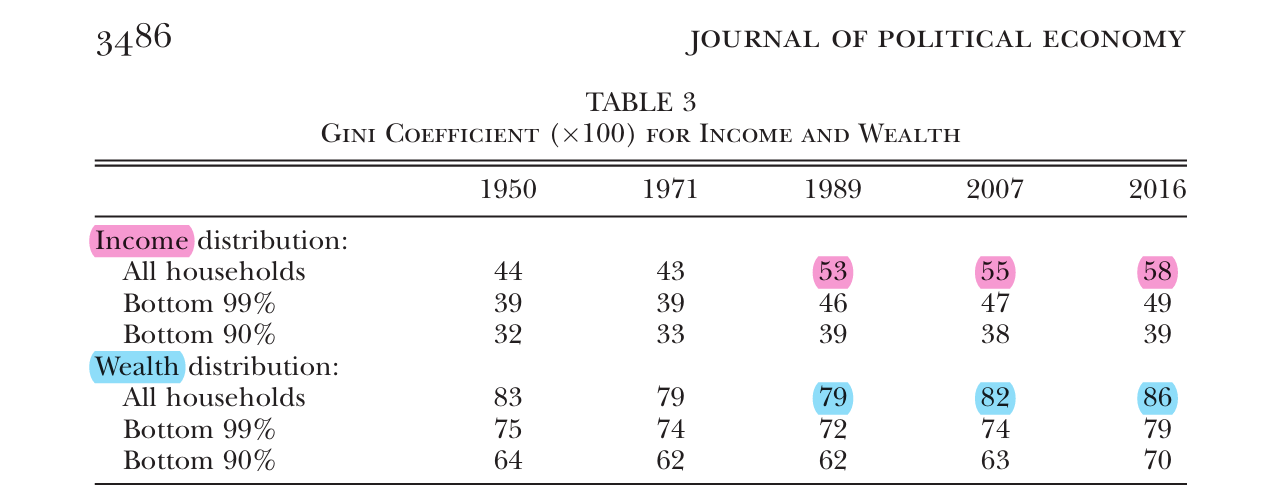

- 출처: Kuhn, M., Schularick, M., & Steins, U. I. (2020). Income and wealth inequality in America, 1949–2016. *Journal of Political Economy*, 128(9), 3469-3519.

### 4개 년도 변수 추출

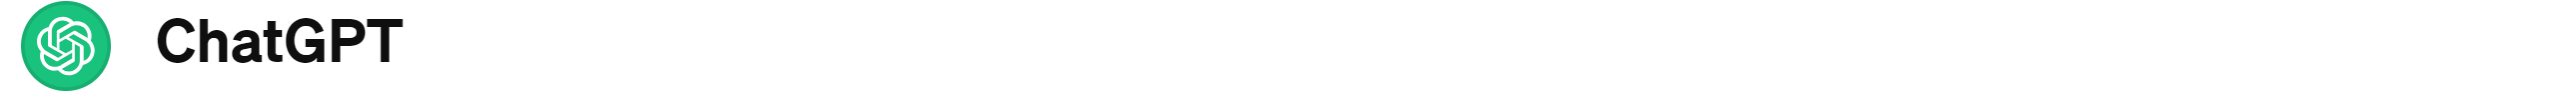 

>**다음을 loop를 사용해 간단히 만들어줘.**
>
>``` python
>scf_1989 = pd.read_stata(unzip_survey_file(year = '1989'))
networth_1989 = scf_1989['networth']/1000 
weight_1989 = scf_1989['wgt']
>
>scf_2007 = pd.read_stata(unzip_survey_file(year = '2007'))
networth_2007 = scf_2007['networth']/1000 
weight_2007 = scf_2007['wgt']
>```

In [46]:
import pandas as pd

# 처리할 연도 목록 정의
years = ['1989', '2007', '2016', '2022']

# 결과를 저장할 딕셔너리 초기화
networth_dict = {}
income_dict = {}
weight_dict = {}

for year in years:
    # 데이터 로드
    scf_data = pd.read_stata(unzip_survey_file(year=year))
    
    # 변수 추출 및 딕셔너리에 저장

    networth_dict[f'networth_{year}'] = scf_data['networth'] / 1000
    income_dict[f'income_{year}'] = scf_data['income'] / 1000
    weight_dict[f'weight_{year}'] = scf_data['wgt']
    
# 사용 예시: networth_2022 변수에 접근
networth_2022 = networth_dict['networth_2022']
income_2022 = income_dict['income_2022']
weight_2022 = weight_dict['weight_2022']

### 단순평균

#### Net Worth

In [47]:
for year in years:
    mean_value = networth_dict[f'networth_{year}'].mean()
    print(f'networth_{year} 단순평균:', mean_value)

networth_1989 단순평균: 5199.370024649744
networth_2007 단순평균: 17490.997193896226
networth_2016 단순평균: 14705.654670215374
networth_2022 단순평균: 19956.403324635474


#### Income

In [48]:
for year in years:
    mean_value = income_dict[f'income_{year}'].mean()
    print(f'income_{year} 단순평균:', mean_value)

income_1989 단순평균: 564.6442158348045
income_2007 단순평균: 1621.925211918383
income_2016 단순평균: 986.7477201586348
income_2022 단순평균: 1592.8552076797775


### 가중평균

In [49]:
# 가중평균 함수
def weighted_mean(x, w):
    weighted_sum = np.sum(x * w)
    total_weight = np.sum(w)
    mean = weighted_sum / total_weight
    return mean

#### Net Worth

In [50]:
for year in years:
    mean_value = weighted_mean(networth_dict[f'networth_{year}'], 
                               weight_dict[f'weight_{year}'])
    print(f'networth_{year} 가중평균:', mean_value)

networth_1989 가중평균: 436.6038112554389
networth_2007 가중평균: 796.7570226811747
networth_2016 가중평균: 850.4153167887076
networth_2022 가중평균: 1059.457470450531


#### Income

In [51]:
for year in years:
    mean_value = weighted_mean(income_dict[f'income_{year}'], 
                               weight_dict[f'weight_{year}'])
    print(f'income_{year} 가중평균:', mean_value)

income_1989 가중평균: 94.574516446001
income_2007 가중평균: 120.4231053944063
income_2016 가중평균: 126.14991886388822
income_2022 가중평균: 141.3898886711588


### 단순 지니계수

In [52]:
# 지니 계수 계산법 I

def gini_coefficient(x):
    sorted_x = np.sort(x)
    n = len(x)
    coef = 0
    for i in range(n):
        coef += (i + 1) * sorted_x[i]
    coef = (2 * coef) / (n * np.sum(sorted_x)) - (n + 1) / n
    return coef

In [53]:
# 지니 계수 계산법 II

def gini_coefficient_lorenz(x):
    sorted_x = np.sort(x)
    n = len(x)
    
    # Lorenz 곡선 생성
    lorenz_curve = np.cumsum(sorted_x) / np.sum(sorted_x)
    
    # 지니계수 계산
    gini_coeff = 1 - (2 * np.trapz(lorenz_curve) / n)
    
    return gini_coeff

#### Net Worth

In [54]:
for year in years:
    gini = gini_coefficient(networth_dict[f'networth_{year}'])
    print(f'단순 gini of networth_{year}:', gini)

단순 gini of networth_1989: 0.9003073834599726
단순 gini of networth_2007: 0.914225449601566
단순 gini of networth_2016: 0.940408724174731
단순 gini of networth_2022: 0.9369407959316021


#### Income

In [55]:
for year in years:
    gini = gini_coefficient(income_dict[f'income_{year}'])
    print(f'단순 gini of income_{year}:', gini)

단순 gini of income_1989: 0.841289699130467
단순 gini of income_2007: 0.9003082665154276
단순 gini of income_2016: 0.8939910729408329
단순 gini of income_2022: 0.9217346139192073


### 가중 지니계수

- 계산방식 출처: Lerman, R. I., & Yitzhaki, S. (1989). Improving the accuracy of estimates of Gini coefficients. *Journal of econometrics*, 42(1), 43-47.

In [56]:
# weighted_gini 함수

import numpy as np

def weighted_gini(x, w):
    # 데이터를 값 순서대로 정렬
    sorted_data = np.asarray([x, w]).T[np.argsort(x)]  # x 기준 오름차순으로 정렬
    sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
    # 총 가중치 및 누적 가중치 초기화
    total_weight = np.sum(sorted_w)
    sorted_w = sorted_w/total_weight
    cumulative_weight = np.cumsum(sorted_w)
     
    # 지니 계수 계산 항목
    sorted_x_dev = sorted_x - weighted_mean(sorted_x, sorted_w)
    
    f_hat = cumulative_weight.copy()    
    # f_hat 업데이트
    for i in range(len(f_hat)):
        if i == 0:            
            f_hat[i] = sorted_w[i] / 2
        else:
            f_hat[i] = cumulative_weight[i-1] + (sorted_w[i] / 2)

    f_hat_dev = f_hat - f_hat.mean()
    G = sorted_w*sorted_x_dev*f_hat_dev/(weighted_mean(sorted_x, sorted_w))
    weighted_gini = 2*G.sum()
   
    return weighted_gini 

#### Net Worth

In [57]:
for year in years:
    gini = weighted_gini(networth_dict[f'networth_{year}'],
                         weight_dict[f'weight_{year}'])
    print(f'가중 gini of networth_{year}:', gini)

가중 gini of networth_1989: 0.7901580486056661
가중 gini of networth_2007: 0.8161574733915097
가중 gini of networth_2016: 0.8595617108886233
가중 gini of networth_2022: 0.8298282302964242


#### Income

In [58]:
for year in years:
    gini = weighted_gini(income_dict[f'income_{year}'],
                         weight_dict[f'weight_{year}'])
    print(f'가중 gini of income_{year}:', gini)

가중 gini of income_1989: 0.5402317643421131
가중 gini of income_2007: 0.5741591995511028
가중 gini of income_2016: 0.5977057737870368
가중 gini of income_2022: 0.6068066016844815


### 결과 설명

- 아래 선행연구 결과와 비교해보면, SCF 데이터세트를 이용하여 지니계수를 구할 경우 가중치를 사용하여 계산한다는 것을 알 수 있다.
- 순자산은 계산 결과가 동일하고, 소득은 수치가 약간 다름.

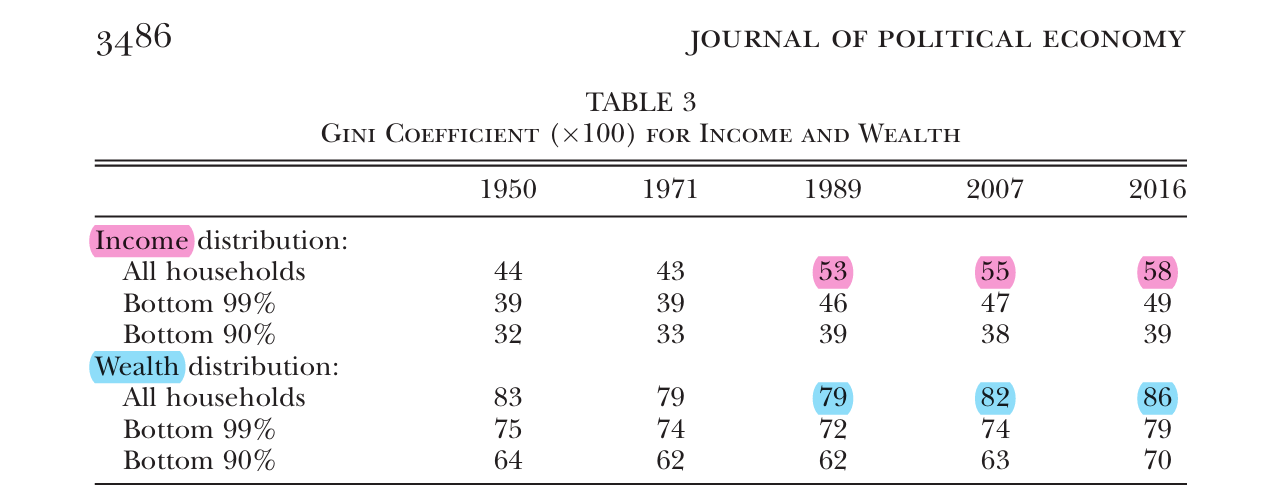

- 출처: Kuhn, M., Schularick, M., & Steins, U. I. (2020). Income and wealth inequality in America, 1949–2016. *Journal of Political Economy*, 128(9), 3469-3519.

### 3.2 Net Worth in 2022

In [59]:
networth_2022 = networth_dict['networth_2022']
weight_2022 = weight_dict['weight_2022']

In [60]:
X = networth_2022
w = weight_2022/(weight_2022.sum())
X.describe().apply(lambda x: '%.2f' % x)

count      22975.00
mean       19956.40
std       110170.72
min         -555.50
25%           35.91
50%          384.50
75%         2476.11
max      2387780.90
Name: networth, dtype: object

### 가중통계량

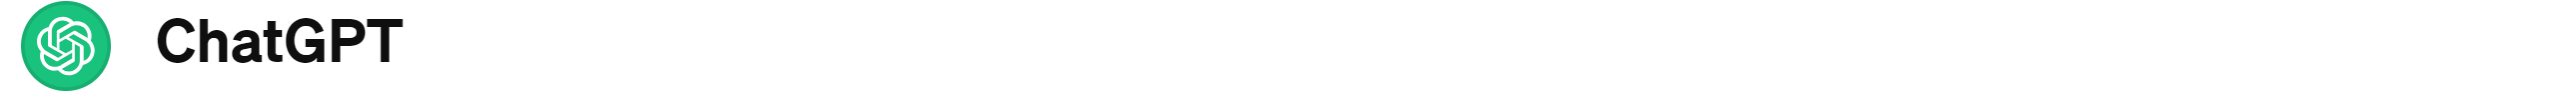 

>**weighted standard deviation, weighted skewness 및 weighted kurtosis coefficients를 계산하는 함수를 만들어줘.**

In [61]:
import numpy as np
from scipy.stats import moment

def weighted_mean(x, weights):
    return np.sum(x * weights) / np.sum(weights)

def weighted_moment(data, weights, order):
    mean = weighted_mean(data, weights)
    return np.sum(weights * (data - mean) ** order) / np.sum(weights)

def weighted_std(data, weights):
    mean = weighted_mean(data, weights)
    variance = np.sum(weights * ((data - mean) ** 2)) / np.sum(weights)
    return np.sqrt(variance)

def weighted_skewness(data, weights):
    m2 = weighted_moment(data, weights, 2)
    m3 = weighted_moment(data, weights, 3)
    skewness = (np.sqrt(np.sum(weights)) * m3) / (m2 ** 1.5)
    return skewness

def weighted_kurtosis(data, weights):
    m2 = weighted_moment(data, weights, 2)
    m4 = weighted_moment(data, weights, 4)
    kurtosis = (np.sum(weights) * m4) / (m2 ** 2)
    return kurtosis

In [62]:
print("Weighted Mean:", weighted_mean(X, w))
print("Weighted S.D.:", weighted_std(X, w))
print("Weighted Skewness:", weighted_skewness(X, w))
print("Weighted Kurtosis:", weighted_kurtosis(X, w))

Weighted Mean: 1059.457470450531
Weighted S.D.: 8085.433431879704
Weighted Skewness: 92.75847008732033
Weighted Kurtosis: 14517.33006547197


#### 가중 지니계수

In [63]:
print('가중 gini_2022:', weighted_gini(X, w))

가중 gini_2022: 0.8298282302964242


### 단순 히스토그램

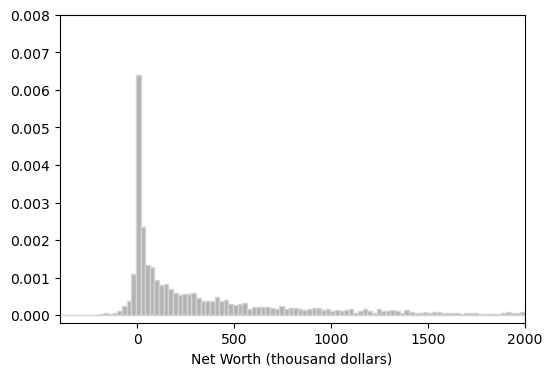

In [64]:
# 히스토그램을 생성
plt.figure(figsize=(6, 4))

plt.xlabel('Net Worth (thousand dollars)')
num_bins = 100000
plt.hist(X, num_bins, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-400, 2000])
plt.ylim(-0.0002, 0.008)
plt.show()

### 가중 히스토그램

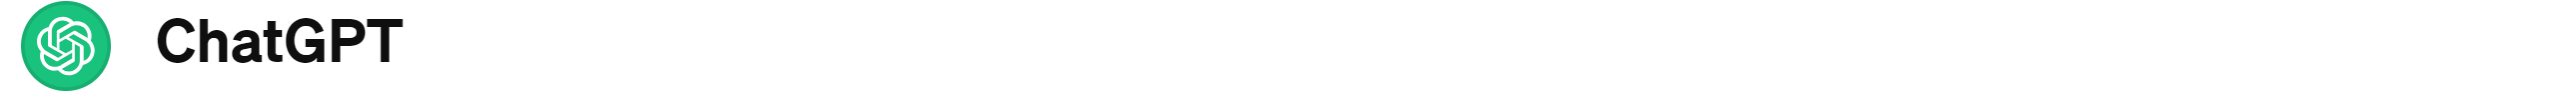 

>**가중치를 사용해 히스토그램을 그리는 코드를 알려줘.**
>
>가중치를 사용한 히스토그램을 그리려면 `numpy`의 `histogram` 함수를 사용하여 히스토그램을 계산하고, 이를 `matplotlib`을 사용하여 그래프로 플로팅할 수 있습니다. 아래는 가중치를 사용한 히스토그램을 그리는 간단한 예시 코드입니다.
>
>```python
import numpy as np
import matplotlib.pyplot as plt
>
># 데이터 생성
np.random.seed(0)
data = np.random.normal(loc=0, scale=1, size=1000)
weights = np.random.uniform(low=0.5, high=2.0, size=1000)  # 가중치
>
># 히스토그램 계산
hist, bins = np.histogram(data, bins=30, weights=weights)
>
># 히스토그램 그리기
plt.bar(bins[:-1], hist, width=np.diff(bins), edgecolor='grey')
>
>plt.xlabel('Value')
plt.ylabel('Weighted Frequency')
plt.title('Weighted Histogram')
plt.show()
>```
>
>이 코드는 가중치를 사용하여 데이터를 생성하고, `numpy`의 `histogram` 함수를 사용하여 가중치를 적용한 히스토그램을 계산합니다. 그런 다음 `matplotlib`을 사용하여 히스토그램을 그립니다.
>
>이 코드를 실행하면 데이터에 가중치를 적용한 히스토그램이 생성됩니다. 각 막대의 높이는 해당 구간의 데이터 포인트의 가중치의 합을 나타냅니다.

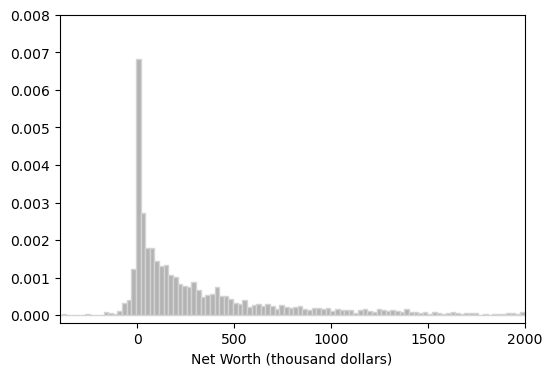

In [65]:
# 히스토그램을 생성
plt.figure(figsize=(6, 4))

plt.xlabel('Net Worth (thousand dollars)')
num_bins = 100000
plt.hist(X, num_bins, weights=w, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-400, 2000])
plt.ylim(-0.0002, 0.008)
plt.show()

### SU 분포 Weighted MLE 

$$\text{argmax} \sum_i w_i \log L(m,s,\lambda, \theta \mid x_i)$$

#### 파라미터 제약조건을 옵션(`bounds`)으로 제공하는 방식

In [66]:
m_init = 0
s_init = 1
lambda_init = 0
theta_init = 1

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(weight_obj_SU, params_init, args=(X, w),
                      method='L-BFGS-B', 
                      bounds=((None, None),(1e-10, None),(None, None),(1e-10, None)))
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE) 
print("Objective function value at solution:", res_SU.fun)

m_MLE = -4.353750896476474 s_MLE = 14.875747192210131 lambda_MLE = 3.045951314930014 theta_MLE = 2.089702959886642
Objective function value at solution: 7.430483707764436


#### 양의 값을 갖는 파라미터에 exp를 취하는 방식

In [67]:
m_init = 0
s_init = 0
lambda_init = 0
theta_init = 0

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(weight_obj_SU_e, params_init, args=(X, w),
                      method='L-BFGS-B')
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

s_MLE = np.exp(s_MLE)
theta_MLE = np.exp(theta_MLE)

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE)
print("Objective function value at solution:", res_SU.fun)

m_MLE = -4.353749207460307 s_MLE = 14.875830115629578 lambda_MLE = 3.045945510181015 theta_MLE = 2.089705981181354
Objective function value at solution: 7.430483707764102


#### 자코비안 행렬 제공

In [68]:
from numpy import arcsinh as asinh
from numpy import sqrt as sqrt

m_init = 0
s_init = 0
lambda_init = 0
theta_init = 0
# NOTE: 자코비안 함수를 제공하는 경우 오히려 초기값의 영향을 더 많이 받는듯 함. 
# 가령 모든 초기값을 0으로 할 경우 최적화가 되지 않음.

# 그래디언트 함수
def grad_logL(params, *args):
    m, s, lambda_, theta = params
    (x, w) = args
    
    s = np.exp(s)
    theta = np.exp(theta)
    
    ll_m = np.sum(w*(
        (-m + x)/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))/(s*theta**2*sqrt(1 + (-m + x)**2/s**2))
    ))
    ll_s = np.sum(w*(s*(
        -s/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_l = np.sum(w*(
        -(2*lambda_ - 2*asinh((-m + x)/s))/(2*theta**2)
    ))
    ll_t = np.sum(w*(theta*(
        -1/theta + (-lambda_ + asinh((-m + x)/s))**2/theta**3
    )))
    
    return -np.array([ll_m, ll_s, ll_l, ll_t])

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(weight_obj_SU_e, params_init, args=(X, w), tol=1e-100,
                      method='Newton-CG', options={'maxiter': 100000},
                      jac=grad_logL)
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

s_MLE = np.exp(s_MLE)
theta_MLE = np.exp(theta_MLE)

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE)
print("Objective function value at solution:", res_SU.fun)

m_MLE = -4.3536157843328755 s_MLE = 14.87572000958285 lambda_MLE = 3.0459539578728156 theta_MLE = 2.0897091848733407
Objective function value at solution: 7.430483707761836


#### 자코비안 & 헤시안 행렬 제공

아래에서 보듯이 `opt.minimize`에 `tol=1e-100` or/and `options={'maxiter': 100000}` 옵션을 부과해야 비슷한 로그가능도 값에 도달함. 그렇지 않으면 (마이너스) 로그가능도 값이 더 높음.

In [69]:
import time
start_time = time.time()

from numpy import arcsinh as asinh
from numpy import sqrt as sqrt

m_init = 0
s_init = 0
lambda_init = 0
theta_init = 0

# 그래디언트 함수
def grad_logL(params, *args):
    m, s, lambda_, theta = params
    (x, w) = args
    
    s = np.exp(s)
    theta = np.exp(theta)
    
    ll_m = np.sum(w*(
        (-m + x)/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))/(s*theta**2*sqrt(1 + (-m + x)**2/s**2))
    ))
    ll_s = np.sum(w*(s*(
        -s/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_l = np.sum(w*(
        -(2*lambda_ - 2*asinh((-m + x)/s))/(2*theta**2)
    ))
    ll_t = np.sum(w*(theta*(
        -1/theta + (-lambda_ + asinh((-m + x)/s))**2/theta**3
    )))
    
    return -np.array([ll_m, ll_s, ll_l, ll_t])

# 헤시안 계산 함수
def hess_logL(params, *args):
    m, s, lambda_, theta = params    
    (x, w) = args
    
    s = np.exp(s)
    theta = np.exp(theta)

    ll_s = np.sum(w*(s*(
        -s/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_t = np.sum(w*(theta*(
        -1/theta + (-lambda_ + asinh((-m + x)/s))**2/theta**3
    )))

    ll_mm = np.sum(w*(
        (-2*m + 2*x)*(-m + x)/(s**2 + (-m + x)**2)**2 - 1/(s**2 + (-m + x)**2) - 1/(s**2*theta**2*(1 + (-m + x)**2/s**2)) - (-lambda_ + asinh((-m + x)/s))*(2*m - 2*x)/(2*s**3*theta**2*(1 + (-m + x)**2/s**2)**(3/2))
    ))
    ll_sm = np.sum(w*(s*(
        -2*s*(-m + x)/(s**2 + (-m + x)**2)**2 - (-lambda_ + asinh((-m + x)/s))/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2)) - (-m + x)/(s**3*theta**2*(1 + (-m + x)**2/s**2)) + (-lambda_ + asinh((-m + x)/s))*(-m + x)**2/(s**4*theta**2*(1 + (-m + x)**2/s**2)**(3/2))
    )))
    ll_lm = np.sum(w*(
        -1/(s*theta**2*sqrt(1 + (-m + x)**2/s**2))
    ))
    ll_tm = np.sum(w*(theta*(
        -2*(-lambda_ + asinh((-m + x)/s))/(s*theta**3*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_ms = ll_sm
    ll_ss = np.sum(w*(s**2*(
        2*s**2/(s**2 + (-m + x)**2)**2 - 1/(s**2 + (-m + x)**2) - 2*(-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**3*theta**2*sqrt(1 + (-m + x)**2/s**2)) - (-m + x)**2/(s**4*theta**2*(1 + (-m + x)**2/s**2)) + (-lambda_ + asinh((-m + x)/s))*(-m + x)**3/(s**5*theta**2*(1 + (-m + x)**2/s**2)**(3/2))
    ))) + ll_s
    ll_ls = np.sum(w*(
        -(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))
    ))
    ll_ts = np.sum(w*(theta*(
        -2*(-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**3*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_ml = ll_lm
    ll_sl = ll_ls
    ll_ll = np.sum(w*(
        -1/theta**2
    ))
    ll_tl = np.sum(w*(theta*(
        (2*lambda_ - 2*asinh((-m + x)/s))/theta**3
    )))
    ll_mt = ll_tm
    ll_st = ll_ts
    ll_lt = ll_tl
    ll_tt = np.sum(w*(theta**2*(
        theta**(-2) - 3*(-lambda_ + asinh((-m + x)/s))**2/theta**4
    ))) 

    hess_matrix = np.array([
        [ll_mm, ll_ms, ll_ml, ll_mt],
        [ll_sm, ll_ss, ll_sl, ll_st],
        [ll_lm, ll_ls, ll_ll, ll_lt],
        [ll_tm, ll_ts, ll_tl, ll_tt]
    ]) + ll_t
    return -hess_matrix

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(weight_obj_SU_e, params_init, args=(X, w), tol=1e-100,
                      method='Newton-CG', options={'maxiter': 100000},
                      jac=grad_logL,  # 그래디언트 함수 지정
                      hess=hess_logL)  # 헤시안 함수 지정
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

s_MLE = np.exp(s_MLE)
theta_MLE = np.exp(theta_MLE)

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE)
print("Objective function value at solution:", res_SU.fun)

end_time = time.time()
execution_time = end_time - start_time
print("\nExecution time:", execution_time, "seconds")

m_MLE = -4.35351377059121 s_MLE = 14.875694708720324 lambda_MLE = 3.0459537215523538 theta_MLE = 2.089711390189534
Objective function value at solution: 7.430483707766614

Execution time: 44.44558882713318 seconds


In [70]:
res_SU

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 7.430483707766614
       x: [-4.354e+00  2.700e+00  3.046e+00  7.370e-01]
     nit: 429
     jac: [ 6.229e-08 -2.756e-09 -2.141e-09  6.864e-09]
    nfev: 432
    njev: 432
    nhev: 429

#### 헤시안 행렬을 통해 분산-공분산 행렬을 계산하는 방법:

- 최적화 과정에서 얻은 헤시안 행렬의 역행렬을 구한다. 이 역행렬은 파라미터의 분산-공분산 행렬 추정치이다.
- 이 행렬의 대각원소를 추출하여 각각의 제곱근을 구한다. 이 값들이 각 파라미터의 표준오차이다.

In [71]:
from scipy.stats import norm

# 최적화 결과에서 헤시안 행렬을 사용하여 분산-공분산 행렬 계산
cov_matrix = np.linalg.inv(hess_logL(res_SU.x, X, w))

# 각 파라미터의 표준오차 계산
std_errors = np.sqrt(np.diag(cov_matrix))
print("\nStandard errors:", std_errors)

# 각 파라미터의 추정치 (최적화 결과)
params_estimated = np.array([m_MLE, s_MLE, lambda_MLE, theta_MLE])

# t-통계량 계산: 파라미터 추정치 / 파라미터의 표준오차
t_stats = params_estimated / std_errors

# t-통계량 출력
print("\nt-Statistics:", t_stats)

# t-통계량에 대한 p값 계산
p_values = 2 * (1 - norm.cdf(np.abs(t_stats)))

# p값 출력
print("\np-values:", p_values)

# 유의수준
alpha = 0.05

# 자유도를 고려한 t 분포의 임계값 (예: 무한대로 가정할 경우 z-점수 사용)
critical_value = 1.96  # 정규분포를 사용한 근사치

# 통계적 유의성 테스트 결과 출력
print("\nStatistically significant at 5% level:")
print(np.abs(t_stats) > critical_value)

np.diag(cov_matrix)


Standard errors: [56.3048057   1.96294346  2.27053838  0.8328931 ]

t-Statistics: [-0.07732047  7.57825938  1.34151167  2.5089791 ]

p-values: [9.38368611e-01 3.50830476e-14 1.79754384e-01 1.21080647e-02]

Statistically significant at 5% level:
[False  True False  True]


array([3.17023115e+03, 3.85314704e+00, 5.15534452e+00, 6.93710920e-01])

### 평균 표준편차 왜도 첨도

In [72]:
print("Weighted Mean:", weighted_mean(X, w))
print("Weighted S.D.:", weighted_std(X, w))
print("Weighted Skewness:", weighted_skewness(X, w))
print("Weighted Kurtosis:", weighted_kurtosis(X, w))

Weighted Mean: 1059.457470450531
Weighted S.D.: 8085.433431879704
Weighted Skewness: 92.75847008732033
Weighted Kurtosis: 14517.33006547197


In [73]:
print("Mean:", SU_mean(m_MLE, s_MLE, lambda_MLE, theta_MLE))
print("S.D.:", SU_var(m_MLE, s_MLE, lambda_MLE, theta_MLE)**0.5)
print("Skewness:", SU_skew(m_MLE, s_MLE, lambda_MLE, theta_MLE))
print("Kurtosis:", SU_kurt(m_MLE, s_MLE, lambda_MLE, theta_MLE))

Mean: 1381.0107488750348
S.D.: 12247.464705543287
Skewness: 712.6043679307253
Kurtosis: 39546401.034906365


### 히스토그램 vs. 추정 PDF

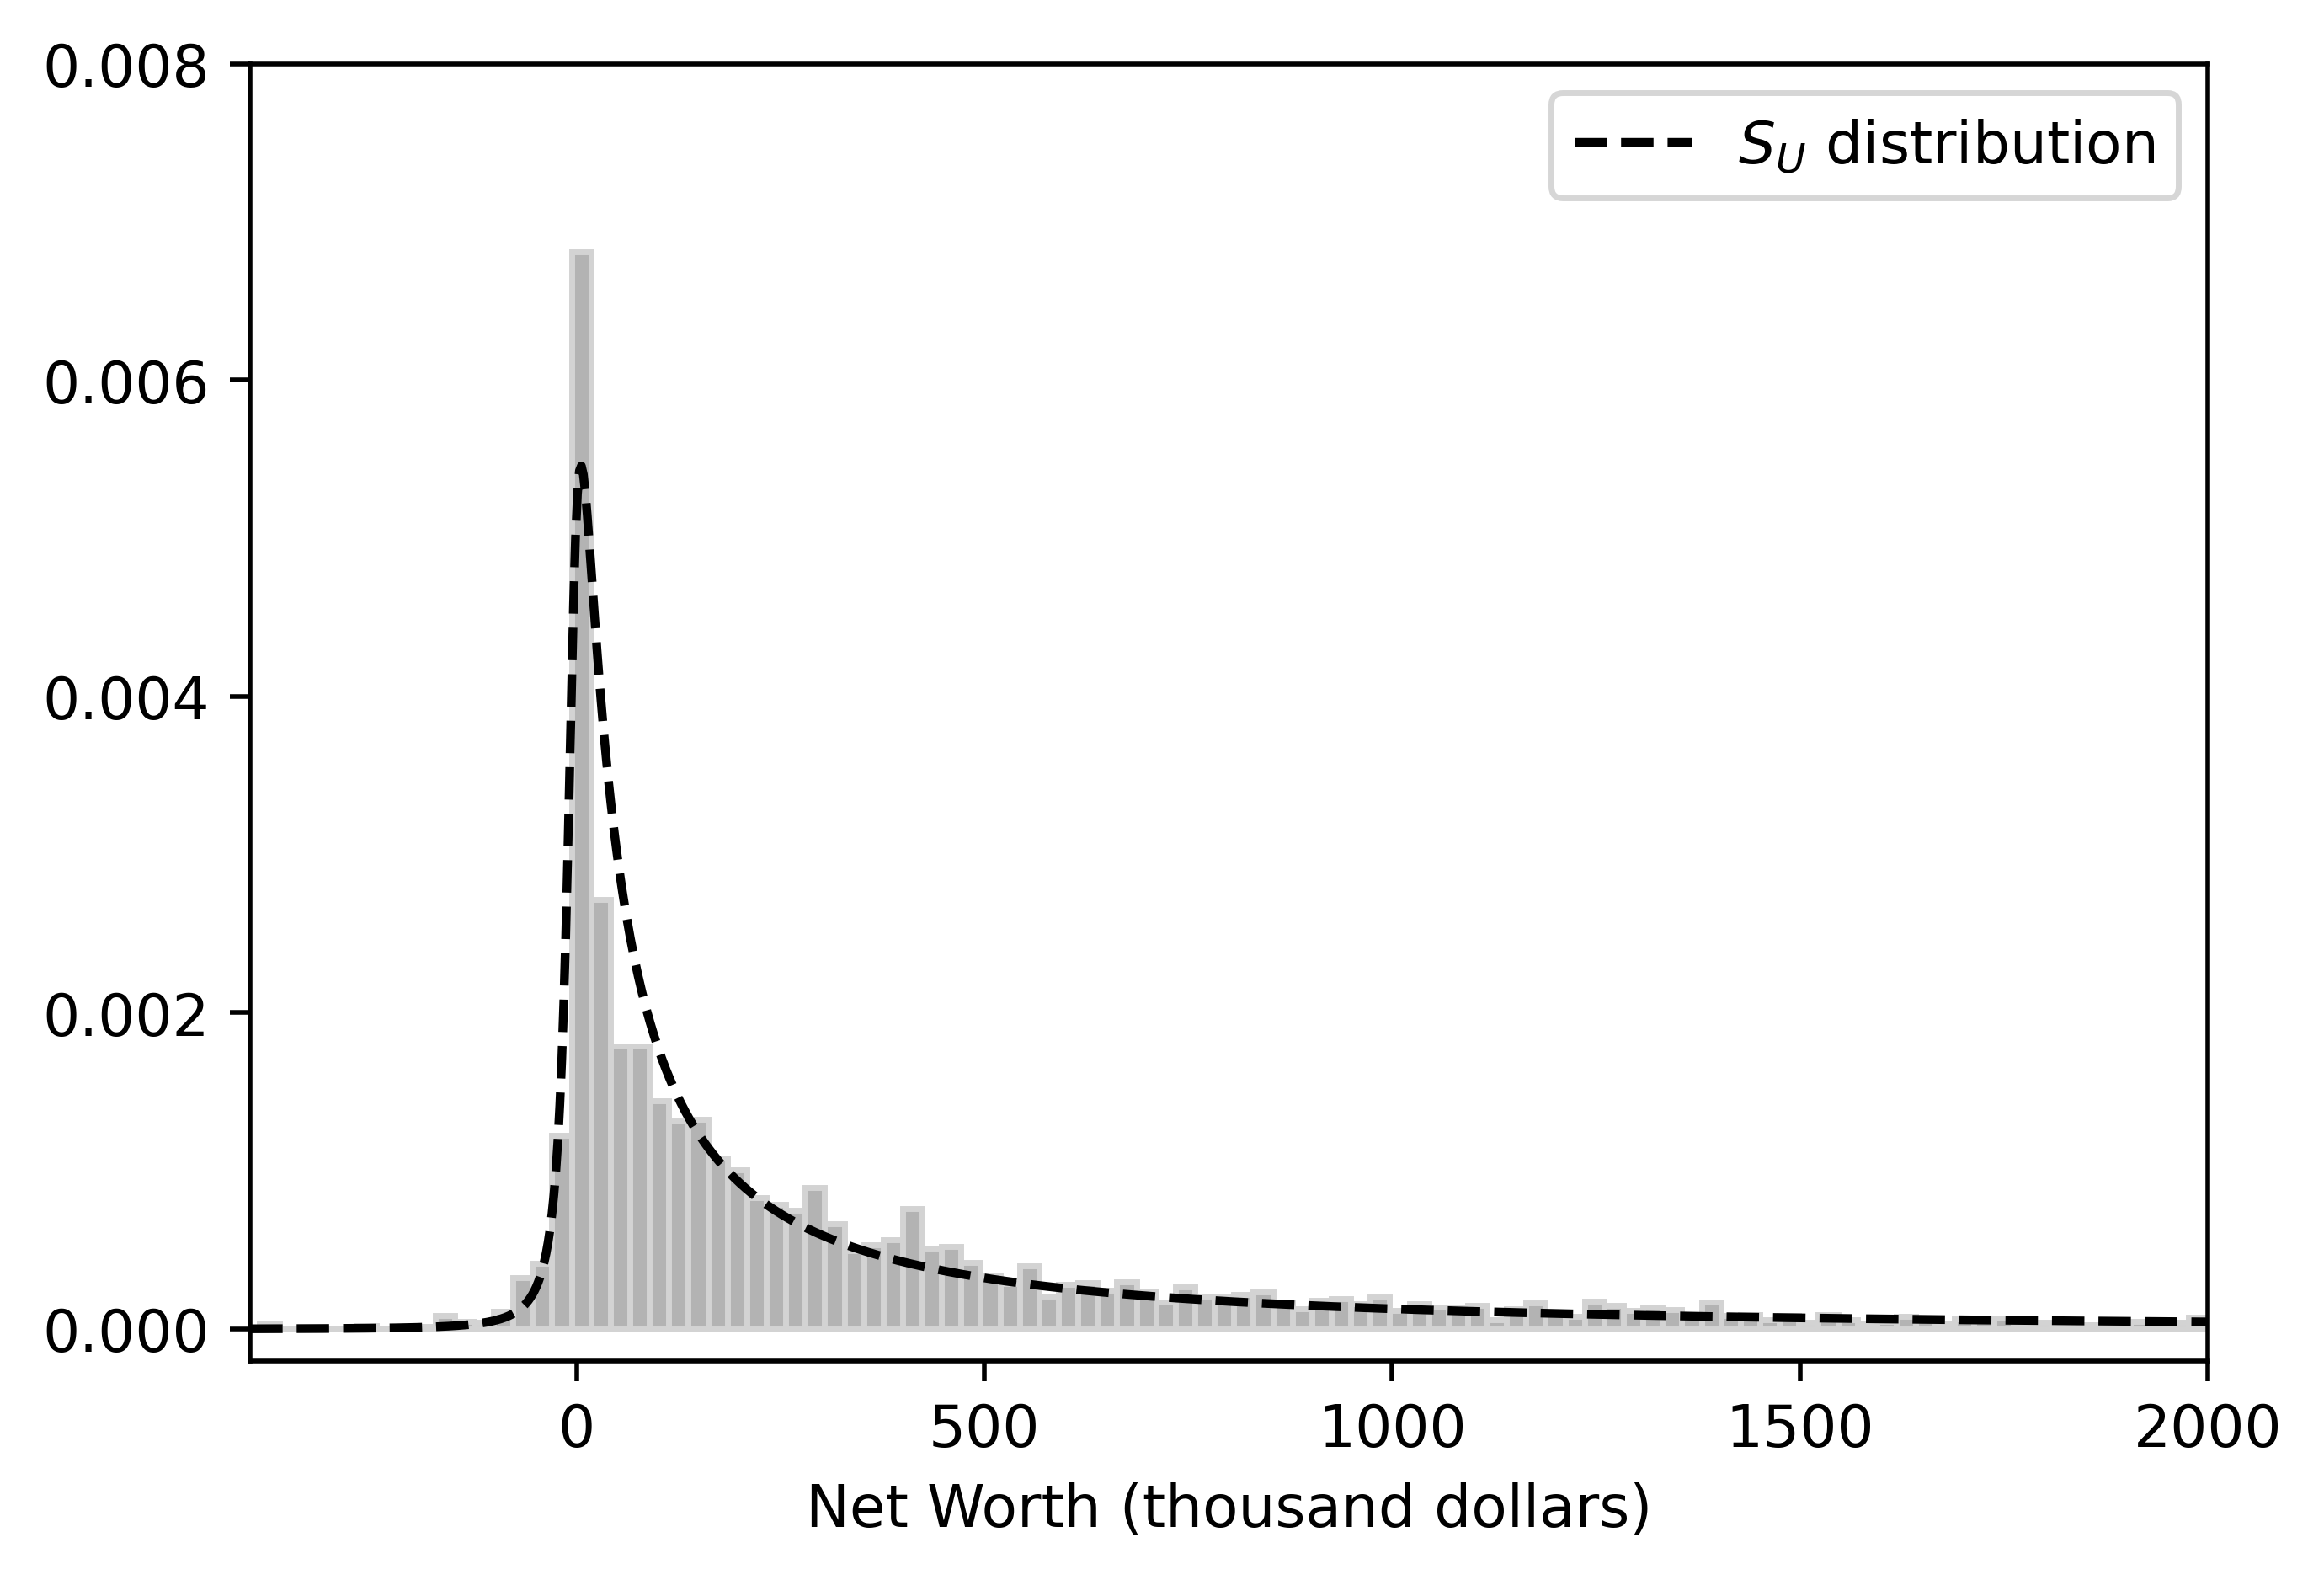

In [74]:
# 새로운 그림을 생성하고 해상도를 조정
plt.figure(figsize=(6, 4), dpi=500)

plt.xlabel('Net Worth (thousand dollars)')

# Plot the histogram of the data
num_bins = 100000
plt.hist(X, num_bins, weights=w, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-400, 2000])
plt.ylim(-0.0002, 0.008)

# Plot the MLE estimated distribution
dist_X = np.linspace(-400, 2000, 1000)
plt.plot(dist_X, SU_pdf(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=1.5, linestyle='dashed', color='k', label='$S_U$ distribution')
plt.legend(loc='upper right')

# 세로축 눈금을 설정
plt.yticks([0.000, 0.002, 0.004, 0.006, 0.008])

# 그래프 표시
plt.show()

### 로렌츠 곡선 및 지니계수

#### 단순 계산

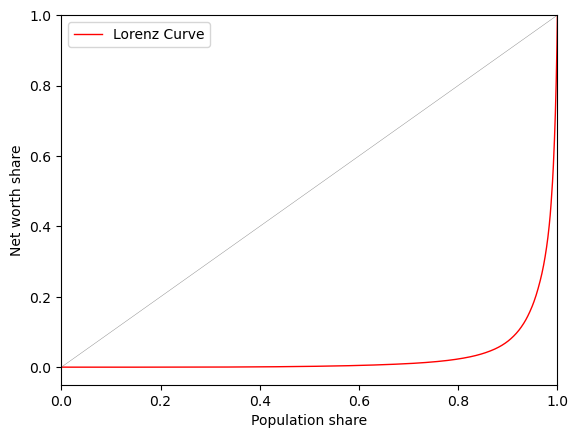

단순 Gini Coefficient: 0.9369


In [75]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 정렬
sorted_X = np.sort(X)

# Lorenz 곡선 계산
n = len(sorted_X)
cumulative_percentage = np.cumsum(sorted_X) / np.sum(sorted_X)
lorenz_curve_x = np.arange(1, n+1) / n
lorenz_curve_y = cumulative_percentage

# Lorenz 곡선 그리기
plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

# Gini 계수 계산
area_under_lorenz = np.trapz(lorenz_curve_y, lorenz_curve_x)
area_under_equality = 0.5  # 0에서 1 사이의 대각선 선분 아래 영역
gini_coefficient = (area_under_equality - area_under_lorenz) / area_under_equality
print(f'단순 Gini Coefficient: {gini_coefficient:.4f}')

#### 가중치 사용

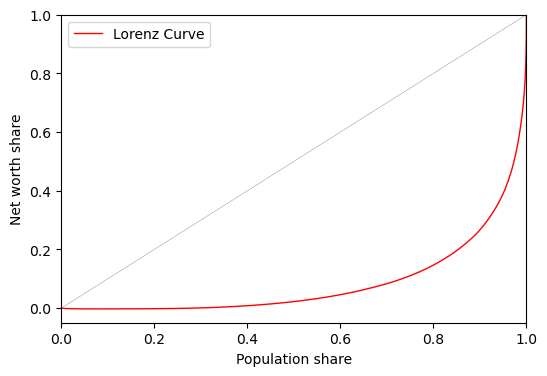

가중 Gini Coefficient: 0.8298


In [76]:
plt.figure(figsize=(6, 4))

# 데이터를 값 순서대로 정렬
sorted_data = np.asarray([X, w]).T[np.argsort(X)]
sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
# 총 가중치 및 가중치가 적용된 누적 소득 계산
total_weight = np.sum(sorted_w)
sorted_w = sorted_w / total_weight
cumulative_w = np.cumsum(sorted_w)
    
# 가중치가 적용된 누적 소득 비율 계산
total_x = np.sum(sorted_x * sorted_w)
weighted_cumulative_percentage = np.cumsum(sorted_x * sorted_w) / total_x

lorenz_curve_x = cumulative_w
lorenz_curve_y = weighted_cumulative_percentage

plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

# Gini 계수 계산
area_under_lorenz = np.trapz(lorenz_curve_y, lorenz_curve_x)
area_under_equality = 0.5  # 0에서 1 사이의 대각선 선분 아래 영역
gini_coefficient = (area_under_equality - area_under_lorenz) / area_under_equality
print(f'가중 Gini Coefficient: {gini_coefficient:.4f}')

#### Parametric Estimation 결과

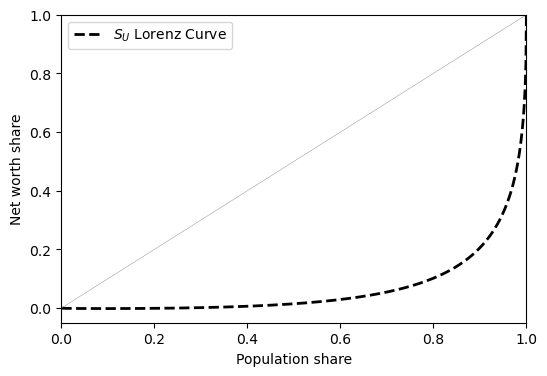

In [77]:
plt.figure(figsize=(6, 4))

dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_SU(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=2, linestyle='dashed', color='k', label='$S_U$ Lorenz Curve')

plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

#### 지니계수 계산(수치 적분)

In [78]:
from scipy.integrate import quad

res, err = quad(Lorenz_SU, 0, 1, args=(m_MLE, s_MLE, lambda_MLE, theta_MLE))
1-2*res

0.8671233629036605

#### 결과 비교 그림

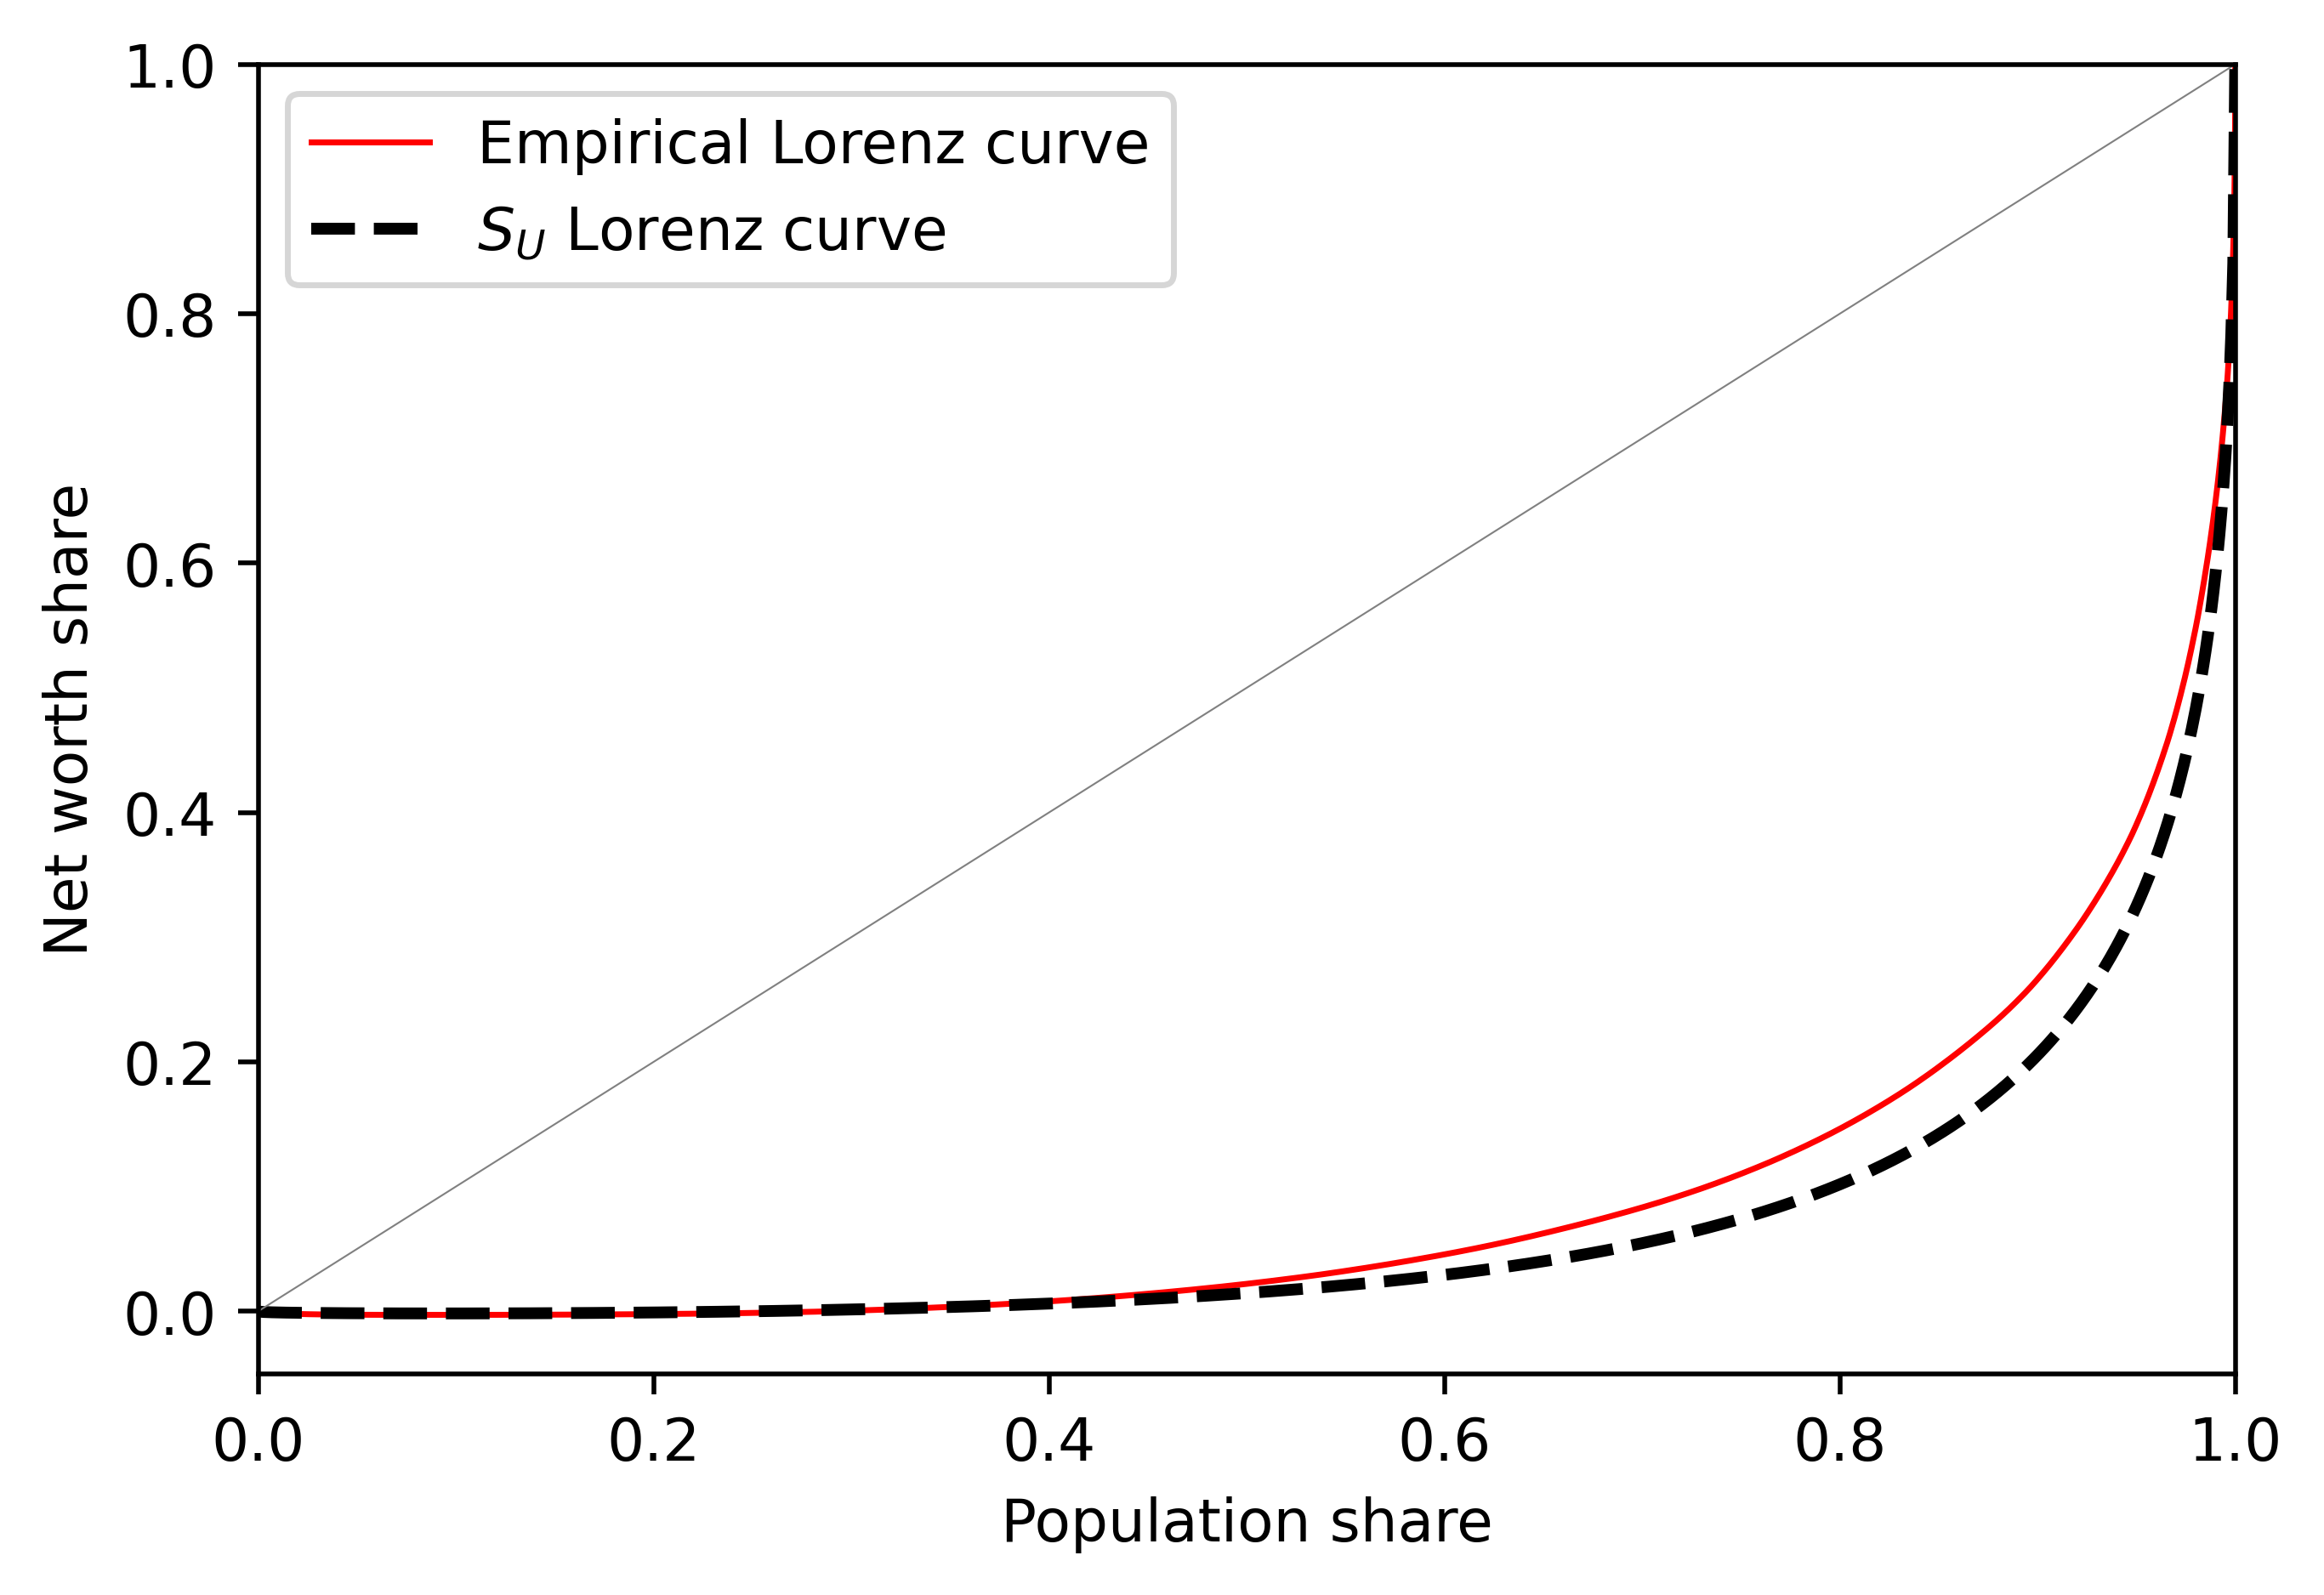

In [79]:
# 새로운 그림을 생성하고 해상도를 조정합니다.
plt.figure(figsize=(6, 4), dpi=500)

# Empirical Lorenz 곡선
sorted_data = np.asarray([X, w]).T[np.argsort(X)]
sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
total_weight = np.sum(sorted_w)
sorted_w = sorted_w / total_weight
cumulative_w = np.cumsum(sorted_w)
    
total_x = np.sum(sorted_x * sorted_w)
weighted_cumulative_percentage = np.cumsum(sorted_x * sorted_w) / total_x

lorenz_curve_x = cumulative_w
lorenz_curve_y = weighted_cumulative_percentage

plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Empirical Lorenz curve')

# SU Lorenz 곡선
dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_SU(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=2, linestyle='dashed', color='k', label='$S_U$ Lorenz curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)

plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

### 3.3 Income in 2022

In [80]:
income_2022 = income_dict['income_2022']
weight_2022 = weight_dict['weight_2022']

In [81]:
X = income_2022
w = weight_2022/(weight_2022.sum())
X.describe().apply(lambda x: '%.2f' % x)

count     22975.00
mean       1592.86
std       12442.71
min           0.00
25%          42.16
50%          94.04
75%         264.82
max      458230.95
Name: income, dtype: object

In [82]:
print("Weighted Mean:", weighted_mean(X, w))
print("Weighted S.D.:", weighted_std(X, w))
print("Weighted Skewness:", weighted_skewness(X, w))
print("Weighted Kurtosis:", weighted_kurtosis(X, w))

Weighted Mean: 141.38988867115881
Weighted S.D.: 727.9620604300843
Weighted Skewness: 166.76137348884768
Weighted Kurtosis: 63910.5666748011


#### 가중 지니계수

In [83]:
print('가중 gini_2022:', weighted_gini(X, w))

가중 gini_2022: 0.6068066016844815


### 단순 히스토그램

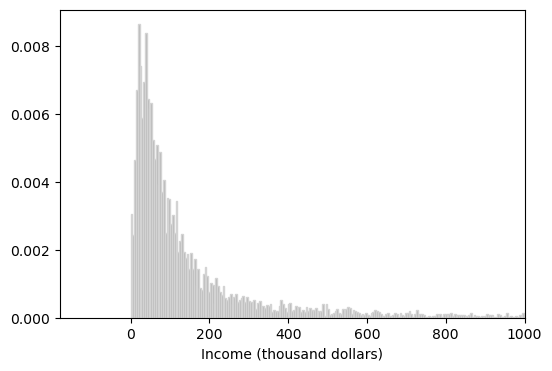

In [84]:
# 히스토그램을 생성
plt.figure(figsize=(6, 4))

plt.xlabel('Income (thousand dollars)')
num_bins = 100000
plt.hist(X, num_bins, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-180, 1000])
plt.show()

### 가중 히스토그램

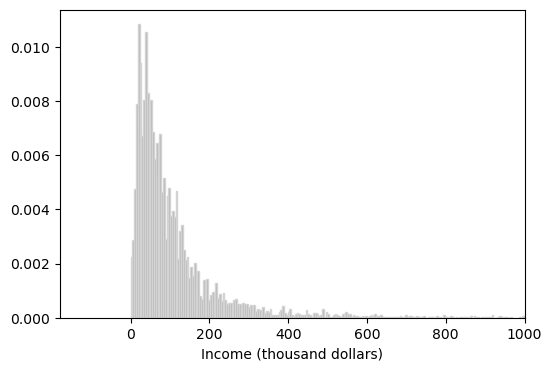

In [85]:
# 히스토그램을 생성
plt.figure(figsize=(6, 4))

plt.xlabel('Income (thousand dollars)')
num_bins = 100000
plt.hist(X, num_bins, weights=w, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-180, 1000])
plt.show()

### SU 분포 Weighted MLE 

$$\text{argmax} \sum_i w_i \log L(m,s,\lambda, \theta \mid x_i)$$

#### 파라미터 제약조건을 옵션(`bounds`)으로 제공하는 방식

In [86]:
m_init = 0
s_init = 1
lambda_init = 0
theta_init = 1

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(weight_obj_SU, params_init, args=(X, w),
                      method='L-BFGS-B', 
                      bounds=((None, None),(1e-10, None),(None, None),(1e-10, None)))
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE)
print("Objective function value at solution:", res_SU.fun)

m_MLE = 7.617034390564675 s_MLE = 10.955591221493945 lambda_MLE = 2.426927643347031 theta_MLE = 1.1305020127990213
Objective function value at solution: 5.727623011004285


#### 양의 값을 갖는 파라미터에 exp를 취하는 방식

In [87]:
m_init = 0
s_init = 0
lambda_init = 0
theta_init = 0

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(weight_obj_SU_e, params_init, args=(X, w),
                      method='L-BFGS-B')
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

s_MLE = np.exp(s_MLE)
theta_MLE = np.exp(theta_MLE)

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE)
print("Objective function value at solution:", res_SU.fun)

m_MLE = 7.614629481975043 s_MLE = 10.954576510596073 lambda_MLE = 2.427072425919873 theta_MLE = 1.130466271104921
Objective function value at solution: 5.727623010890738


#### 자코비안 행렬 제공

In [88]:
from numpy import arcsinh as asinh
from numpy import sqrt as sqrt

m_init = 0
s_init = 0
lambda_init = 0
theta_init = 0
# NOTE: 자코비안 함수를 제공하는 경우 오히려 초기값의 영향을 더 많이 받는듯 함. 
# 가령 모든 초기값을 0으로 할 경우 최적화가 되지 않음.

# 그래디언트 함수
def grad_logL(params, *args):
    m, s, lambda_, theta = params
    (x, w) = args
    
    s = np.exp(s)
    theta = np.exp(theta)
    
    ll_m = np.sum(w*(
        (-m + x)/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))/(s*theta**2*sqrt(1 + (-m + x)**2/s**2))
    ))
    ll_s = np.sum(w*(s*(
        -s/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_l = np.sum(w*(
        -(2*lambda_ - 2*asinh((-m + x)/s))/(2*theta**2)
    ))
    ll_t = np.sum(w*(theta*(
        -1/theta + (-lambda_ + asinh((-m + x)/s))**2/theta**3
    )))
    
    return -np.array([ll_m, ll_s, ll_l, ll_t])

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(weight_obj_SU_e, params_init, args=(X, w), tol=1e-100,
                      method='Newton-CG', options={'maxiter': 100000},
                      jac=grad_logL)
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

s_MLE = np.exp(s_MLE)
theta_MLE = np.exp(theta_MLE)

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE)
print("Objective function value at solution:", res_SU.fun)

m_MLE = 7.61561913351253 s_MLE = 10.955414970800115 lambda_MLE = 2.4269860607404317 theta_MLE = 1.1304827960503114
Objective function value at solution: 5.727623010684983


#### 자코비안 & 헤시안 행렬 제공

아래에서 보듯이 `opt.minimize`에 `tol=1e-100` or/and `options={'maxiter': 100000}` 옵션을 부과해야 비슷한 로그가능도 값에 도달함. 그렇지 않으면 (마이너스) 로그가능도 값이 더 높음.

In [89]:
import time
start_time = time.time()

from numpy import arcsinh as asinh
from numpy import sqrt as sqrt

m_init = 0
s_init = 0
lambda_init = 0
theta_init = 0

# 그래디언트 함수
def grad_logL(params, *args):
    m, s, lambda_, theta = params
    (x, w) = args
    
    s = np.exp(s)
    theta = np.exp(theta)
    
    ll_m = np.sum(w*(
        (-m + x)/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))/(s*theta**2*sqrt(1 + (-m + x)**2/s**2))
    ))
    ll_s = np.sum(w*(s*(
        -s/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_l = np.sum(w*(
        -(2*lambda_ - 2*asinh((-m + x)/s))/(2*theta**2)
    ))
    ll_t = np.sum(w*(theta*(
        -1/theta + (-lambda_ + asinh((-m + x)/s))**2/theta**3
    )))
    
    return -np.array([ll_m, ll_s, ll_l, ll_t])

# 헤시안 계산 함수
def hess_logL(params, *args):
    m, s, lambda_, theta = params    
    (x, w) = args
    
    s = np.exp(s)
    theta = np.exp(theta)

    ll_s = np.sum(w*(s*(
        -s/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_t = np.sum(w*(theta*(
        -1/theta + (-lambda_ + asinh((-m + x)/s))**2/theta**3
    )))

    ll_mm = np.sum(w*(
        (-2*m + 2*x)*(-m + x)/(s**2 + (-m + x)**2)**2 - 1/(s**2 + (-m + x)**2) - 1/(s**2*theta**2*(1 + (-m + x)**2/s**2)) - (-lambda_ + asinh((-m + x)/s))*(2*m - 2*x)/(2*s**3*theta**2*(1 + (-m + x)**2/s**2)**(3/2))
    ))
    ll_sm = np.sum(w*(s*(
        -2*s*(-m + x)/(s**2 + (-m + x)**2)**2 - (-lambda_ + asinh((-m + x)/s))/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2)) - (-m + x)/(s**3*theta**2*(1 + (-m + x)**2/s**2)) + (-lambda_ + asinh((-m + x)/s))*(-m + x)**2/(s**4*theta**2*(1 + (-m + x)**2/s**2)**(3/2))
    )))
    ll_lm = np.sum(w*(
        -1/(s*theta**2*sqrt(1 + (-m + x)**2/s**2))
    ))
    ll_tm = np.sum(w*(theta*(
        -2*(-lambda_ + asinh((-m + x)/s))/(s*theta**3*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_ms = ll_sm
    ll_ss = np.sum(w*(s**2*(
        2*s**2/(s**2 + (-m + x)**2)**2 - 1/(s**2 + (-m + x)**2) - 2*(-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**3*theta**2*sqrt(1 + (-m + x)**2/s**2)) - (-m + x)**2/(s**4*theta**2*(1 + (-m + x)**2/s**2)) + (-lambda_ + asinh((-m + x)/s))*(-m + x)**3/(s**5*theta**2*(1 + (-m + x)**2/s**2)**(3/2))
    ))) + ll_s
    ll_ls = np.sum(w*(
        -(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))
    ))
    ll_ts = np.sum(w*(theta*(
        -2*(-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**3*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_ml = ll_lm
    ll_sl = ll_ls
    ll_ll = np.sum(w*(
        -1/theta**2
    ))
    ll_tl = np.sum(w*(theta*(
        (2*lambda_ - 2*asinh((-m + x)/s))/theta**3
    )))
    ll_mt = ll_tm
    ll_st = ll_ts
    ll_lt = ll_tl
    ll_tt = np.sum(w*(theta**2*(
        theta**(-2) - 3*(-lambda_ + asinh((-m + x)/s))**2/theta**4
    ))) 

    hess_matrix = np.array([
        [ll_mm, ll_ms, ll_ml, ll_mt],
        [ll_sm, ll_ss, ll_sl, ll_st],
        [ll_lm, ll_ls, ll_ll, ll_lt],
        [ll_tm, ll_ts, ll_tl, ll_tt]
    ]) + ll_t
    return -hess_matrix

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(weight_obj_SU_e, params_init, args=(X, w), tol=1e-100,
                      method='Newton-CG', options={'maxiter': 100000},
                      jac=grad_logL,  # 그래디언트 함수 지정
                      hess=hess_logL)  # 헤시안 함수 지정
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

s_MLE = np.exp(s_MLE)
theta_MLE = np.exp(theta_MLE)

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE)
print("Objective function value at solution:", res_SU.fun)

end_time = time.time()
execution_time = end_time - start_time
print("\nExecution time:", execution_time, "seconds")

m_MLE = 7.615230798348367 s_MLE = 10.955256910429418 lambda_MLE = 2.42700849063916 theta_MLE = 1.1304770957401233
Objective function value at solution: 5.727623010695183

Execution time: 10846.532677650452 seconds


In [90]:
res_SU

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 5.727623010695183
       x: [ 7.615e+00  2.394e+00  2.427e+00  1.226e-01]
     nit: 485
     jac: [-6.191e-08 -4.490e-09  9.181e-09  8.103e-09]
    nfev: 534
    njev: 534
    nhev: 485

#### 헤시안 행렬을 통해 분산-공분산 행렬을 계산하는 방법:

- 최적화 과정에서 얻은 헤시안 행렬의 역행렬을 구한다. 이 역행렬은 파라미터의 분산-공분산 행렬 추정치이다.
- 이 행렬의 대각원소를 추출하여 각각의 제곱근을 구한다. 이 값들이 각 파라미터의 표준오차이다.

In [91]:
from scipy.stats import norm

# 최적화 결과에서 헤시안 행렬을 사용하여 분산-공분산 행렬 계산
cov_matrix = np.linalg.inv(hess_logL(res_SU.x, X, w))

# 각 파라미터의 표준오차 계산
std_errors = np.sqrt(np.diag(cov_matrix))
print("\nStandard errors:", std_errors)

# 각 파라미터의 추정치 (최적화 결과)
params_estimated = np.array([m_MLE, s_MLE, lambda_MLE, theta_MLE])

# t-통계량 계산: 파라미터 추정치 / 파라미터의 표준오차
t_stats = params_estimated / std_errors

# t-통계량 출력
print("\nt-Statistics:", t_stats)

# t-통계량에 대한 p값 계산
p_values = 2 * (1 - norm.cdf(np.abs(t_stats)))

# p값 출력
print("\np-values:", p_values)

# 유의수준
alpha = 0.05

# 자유도를 고려한 t 분포의 임계값 (예: 무한대로 가정할 경우 z-점수 사용)
critical_value = 1.96  # 정규분포를 사용한 근사치

# 통계적 유의성 테스트 결과 출력
print("\nStatistically significant at 5% level:")
print(np.abs(t_stats) > critical_value)

np.diag(cov_matrix)


Standard errors: [75.25299566  1.45921234  2.07021998  1.52254767]

t-Statistics: [0.10119505 7.50765093 1.17234329 0.74249045]

p-values: [9.19395625e-01 6.01740879e-14 2.41059259e-01 4.57790238e-01]

Statistically significant at 5% level:
[False  True False False]


array([5.66301336e+03, 2.12930066e+00, 4.28581075e+00, 2.31815140e+00])

### 평균 표준편차 왜도 첨도

In [92]:
print("Weighted Mean:", weighted_mean(X, w))
print("Weighted S.D.:", weighted_std(X, w))
print("Weighted Skewness:", weighted_skewness(X, w))
print("Weighted Kurtosis:", weighted_kurtosis(X, w))

Weighted Mean: 141.38988867115881
Weighted S.D.: 727.9620604300843
Weighted Skewness: 166.76137348884768
Weighted Kurtosis: 63910.5666748011


In [93]:
print("Mean:", SU_mean(m_MLE, s_MLE, lambda_MLE, theta_MLE))
print("S.D.:", SU_var(m_MLE, s_MLE, lambda_MLE, theta_MLE)**0.5)
print("Skewness:", SU_skew(m_MLE, s_MLE, lambda_MLE, theta_MLE))
print("Kurtosis:", SU_kurt(m_MLE, s_MLE, lambda_MLE, theta_MLE))

Mean: 124.22609174231688
S.D.: 189.53549046775112
Skewness: 8.945391769504566
Kurtosis: 291.7255733132126


### 히스토그램 vs. 추정 PDF

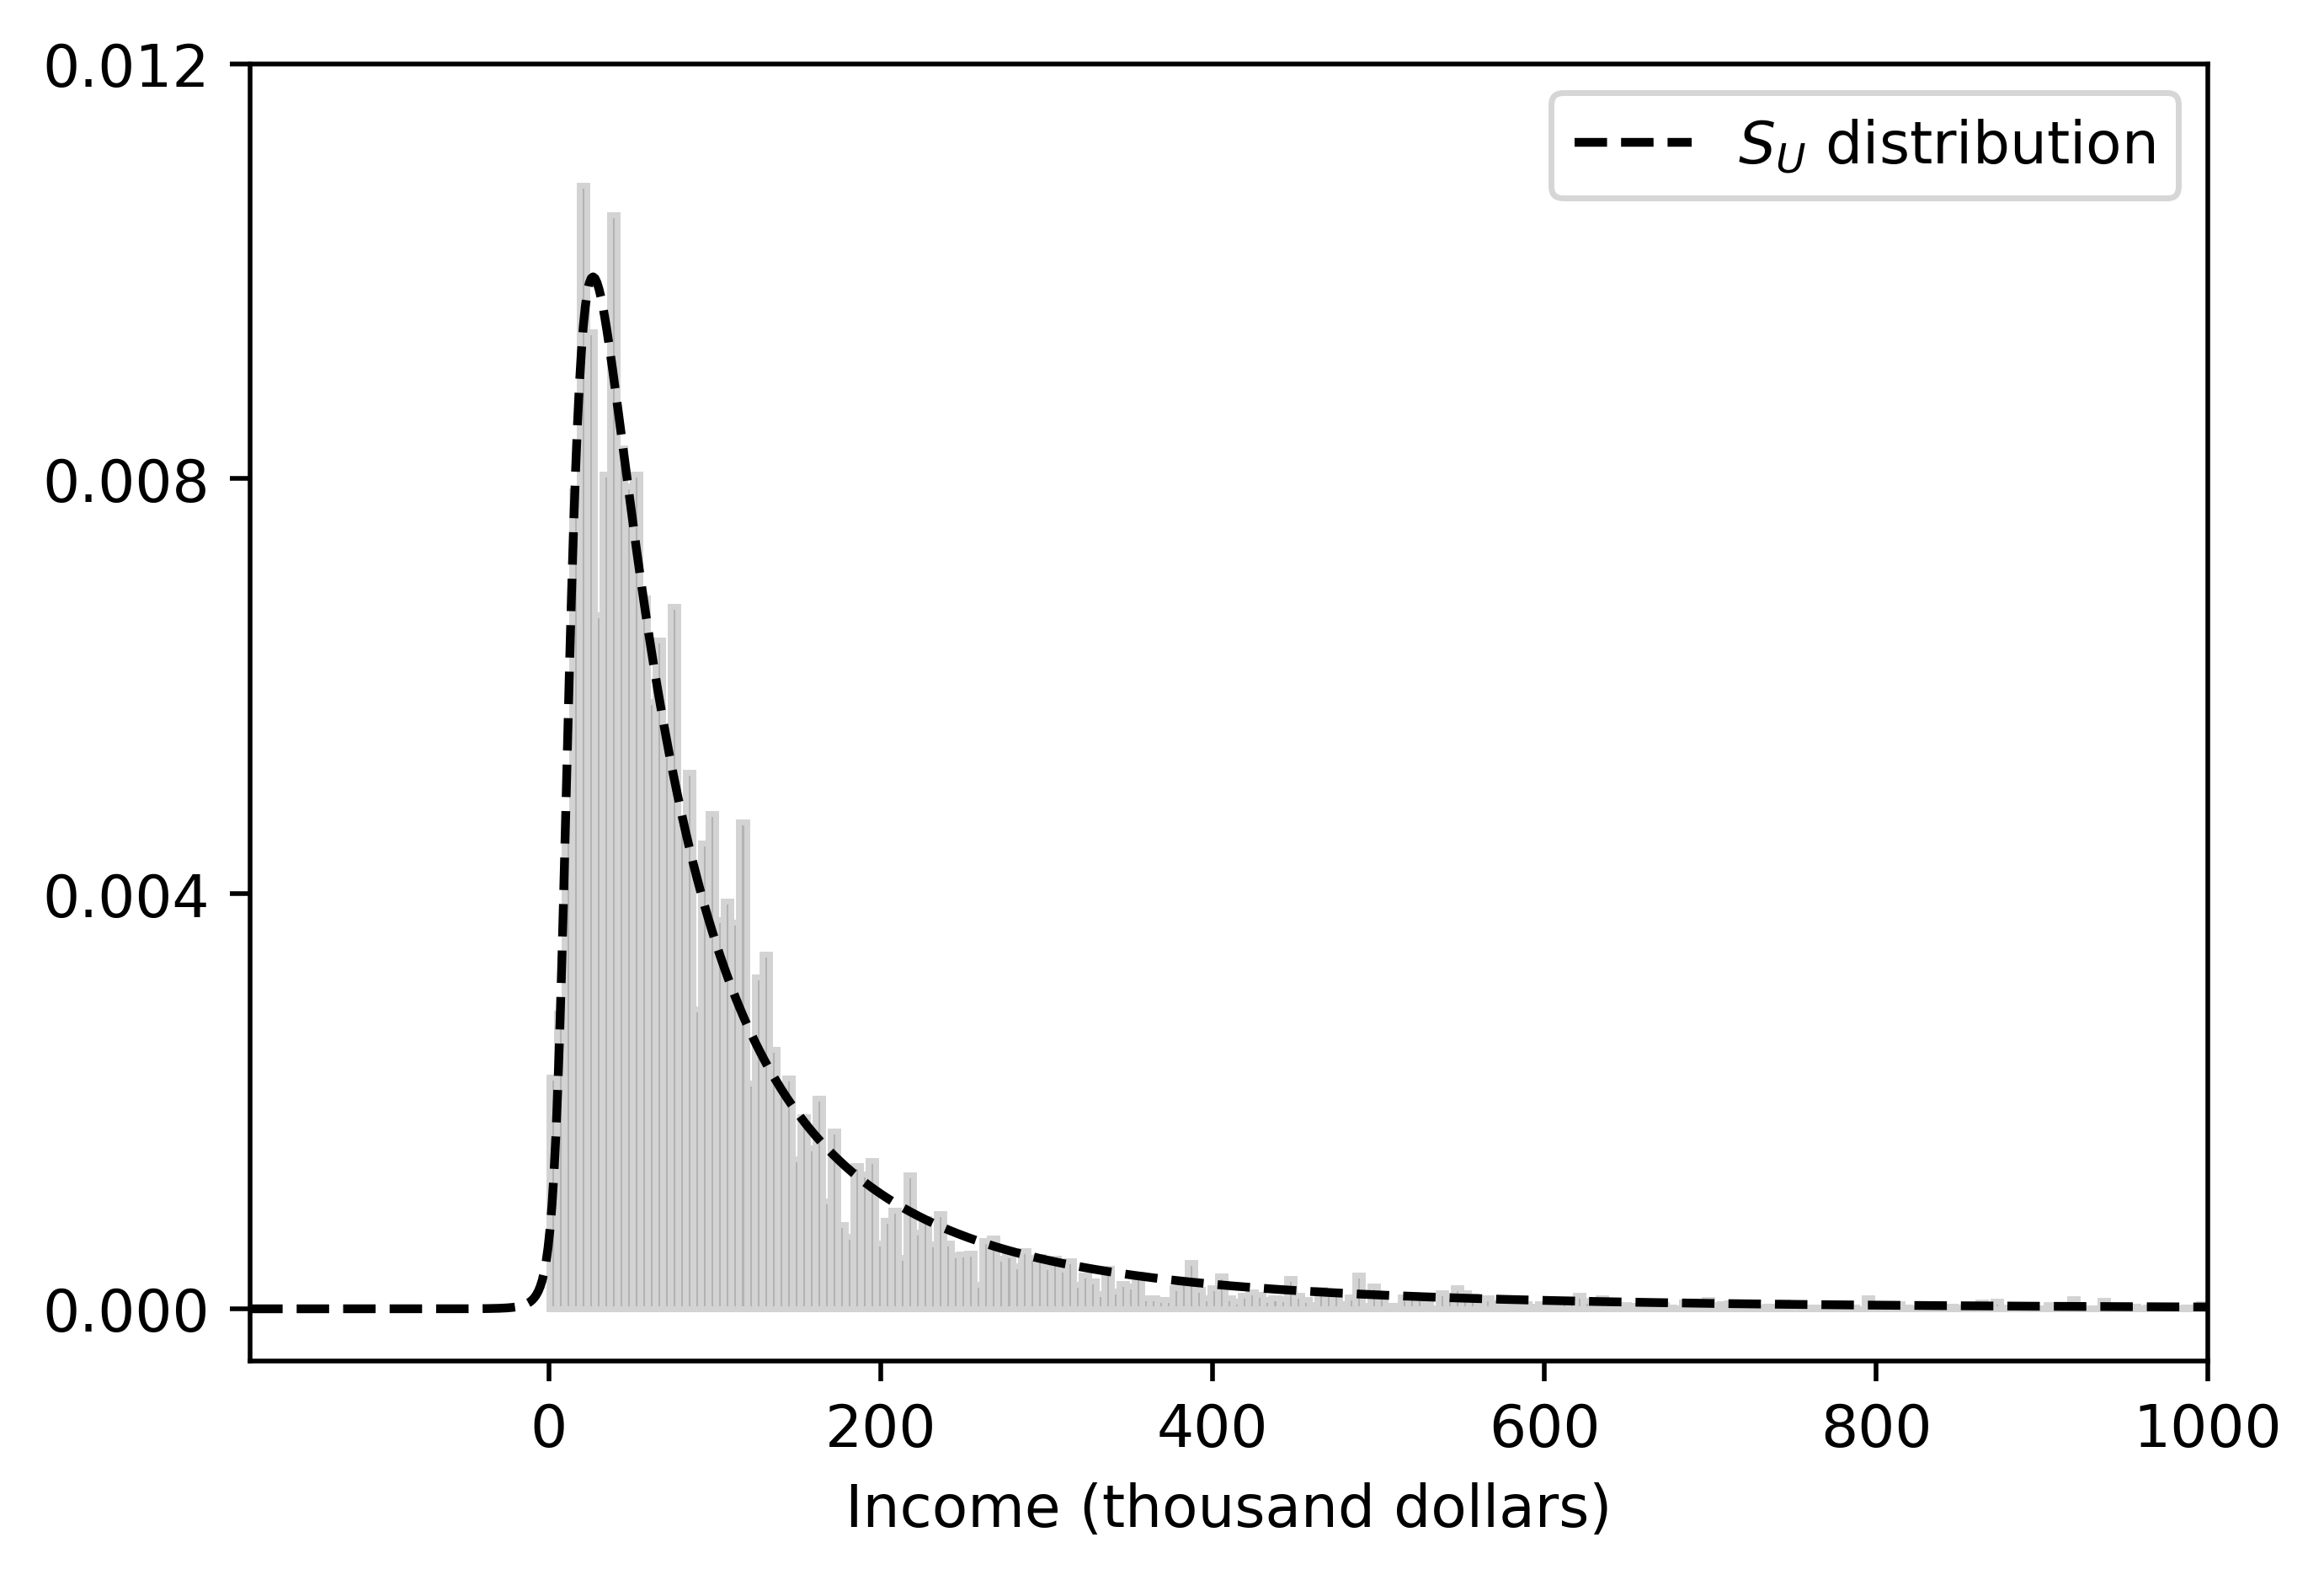

In [94]:
# 새로운 그림을 생성하고 해상도를 조정
plt.figure(figsize=(6, 4), dpi=500)

plt.xlabel('Income (thousand dollars)')

# Plot the histogram of the data
num_bins = 100000
plt.hist(X, num_bins, weights=w, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-180, 1000])
plt.ylim(-0.0005, 0.012)

# Plot the MLE estimated distribution
dist_X = np.linspace(-180, 1000, 1000)
plt.plot(dist_X, SU_pdf(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=1.5, linestyle='dashed', color='k', label='$S_U$ distribution')
plt.legend(loc='upper right')

# 세로축 눈금을 설정
plt.yticks([0.000, 0.004, 0.008, 0.012])

# 그래프 표시
plt.show()

### 로렌츠 곡선 및 지니계수

#### 단순 계산

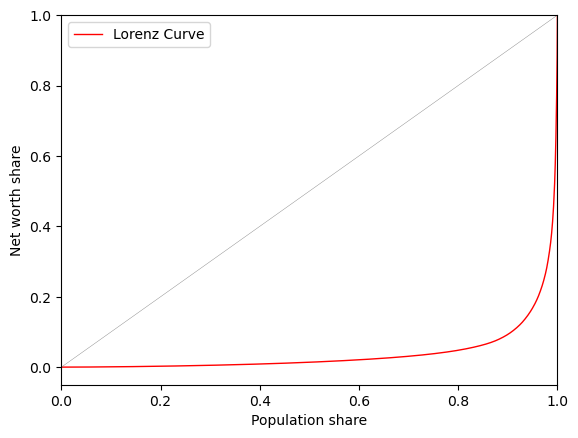

단순 Gini Coefficient: 0.9217


In [95]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 정렬
sorted_X = np.sort(X)

# Lorenz 곡선 계산
n = len(sorted_X)
cumulative_percentage = np.cumsum(sorted_X) / np.sum(sorted_X)
lorenz_curve_x = np.arange(1, n+1) / n
lorenz_curve_y = cumulative_percentage

# Lorenz 곡선 그리기
plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

# Gini 계수 계산
area_under_lorenz = np.trapz(lorenz_curve_y, lorenz_curve_x)
area_under_equality = 0.5  # 0에서 1 사이의 대각선 선분 아래 영역
gini_coefficient = (area_under_equality - area_under_lorenz) / area_under_equality
print(f'단순 Gini Coefficient: {gini_coefficient:.4f}')

#### 가중치 사용

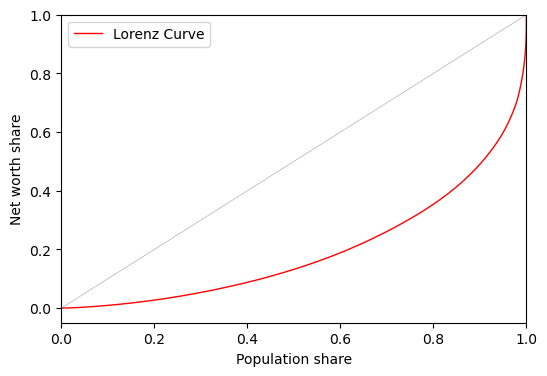

가중 Gini Coefficient: 0.6068


In [96]:
plt.figure(figsize=(6, 4))

# 데이터를 값 순서대로 정렬
sorted_data = np.asarray([X, w]).T[np.argsort(X)]
sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
# 총 가중치 및 가중치가 적용된 누적 소득 계산
total_weight = np.sum(sorted_w)
sorted_w = sorted_w / total_weight
cumulative_w = np.cumsum(sorted_w)
    
# 가중치가 적용된 누적 소득 비율 계산
total_x = np.sum(sorted_x * sorted_w)
weighted_cumulative_percentage = np.cumsum(sorted_x * sorted_w) / total_x

lorenz_curve_x = cumulative_w
lorenz_curve_y = weighted_cumulative_percentage

plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

# Gini 계수 계산
area_under_lorenz = np.trapz(lorenz_curve_y, lorenz_curve_x)
area_under_equality = 0.5  # 0에서 1 사이의 대각선 선분 아래 영역
gini_coefficient = (area_under_equality - area_under_lorenz) / area_under_equality
print(f'가중 Gini Coefficient: {gini_coefficient:.4f}')

#### Parametric Estimation 결과

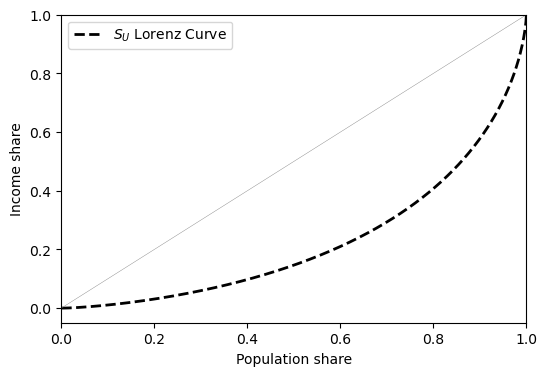

In [97]:
plt.figure(figsize=(6, 4))

dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_SU(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=2, linestyle='dashed', color='k', label='$S_U$ Lorenz Curve')

plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Income share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

#### 지니계수 계산(수치 적분)

In [98]:
from scipy.integrate import quad

res, err = quad(Lorenz_SU, 0, 1, args=(m_MLE, s_MLE, lambda_MLE, theta_MLE))
1-2*res

0.5491147208078262

#### 결과 비교 그림

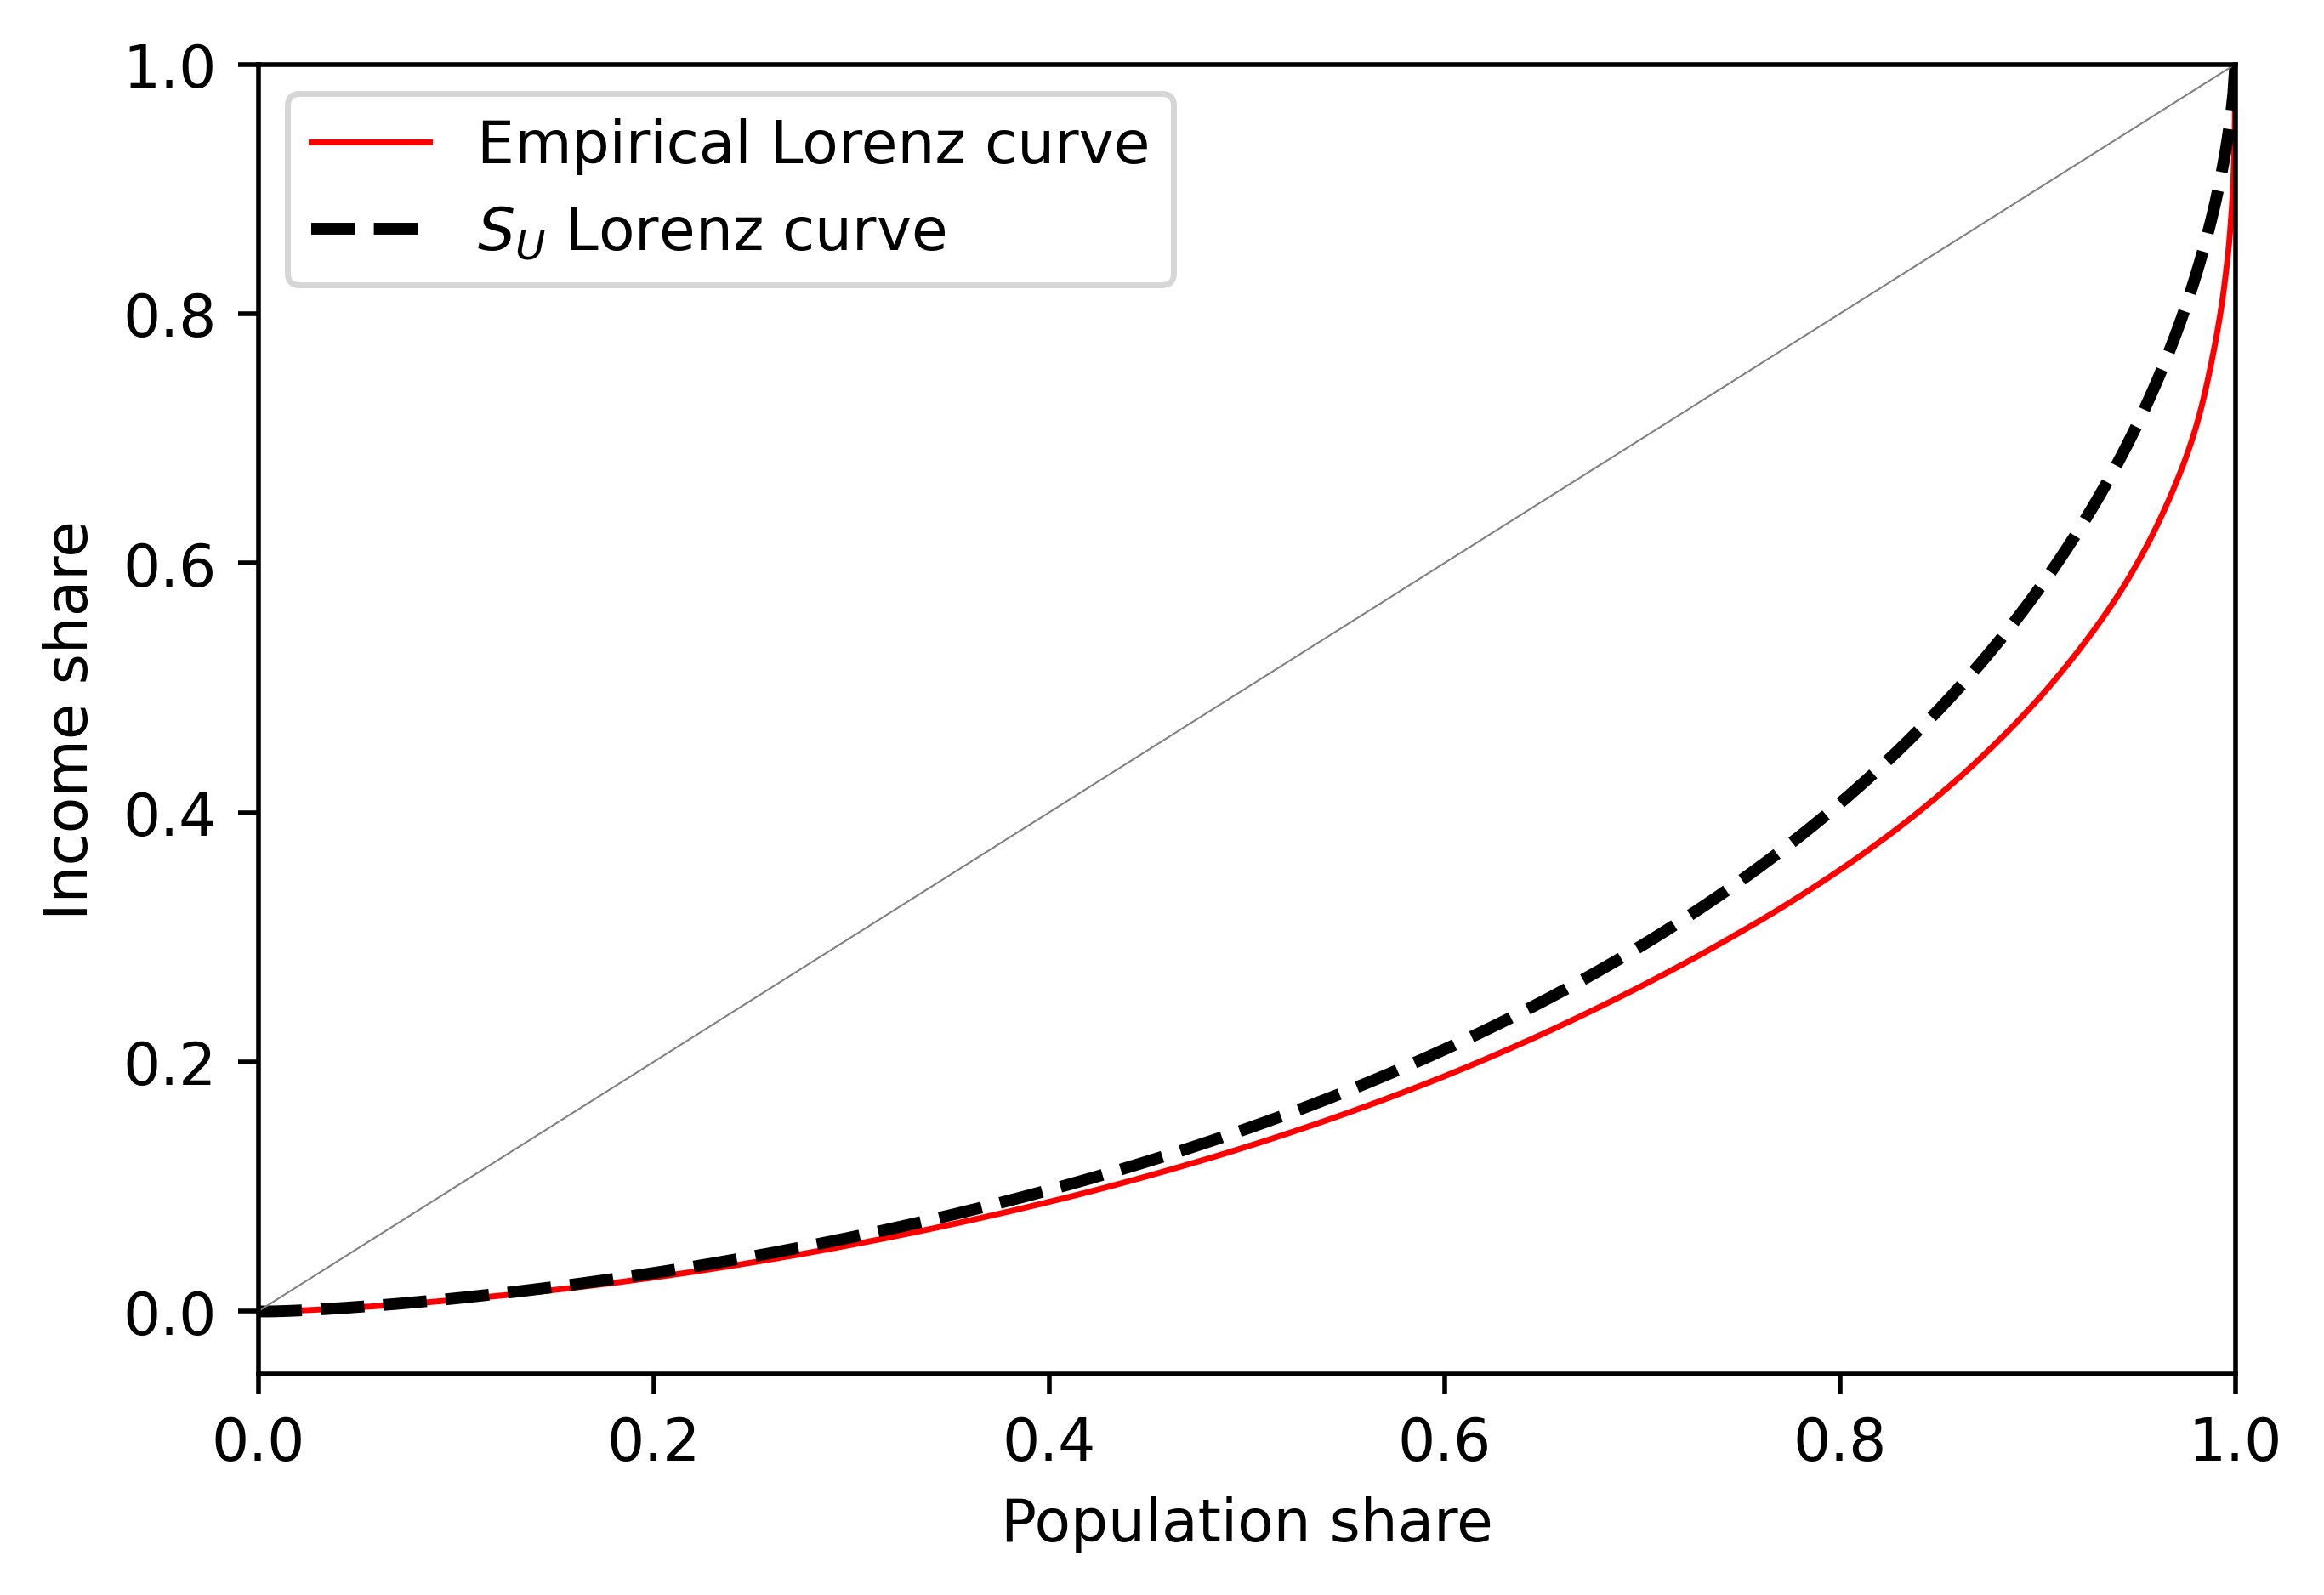

In [99]:
# 새로운 그림을 생성하고 해상도를 조정합니다.
plt.figure(figsize=(6, 4), dpi=500)

# Empirical Lorenz 곡선
sorted_data = np.asarray([X, w]).T[np.argsort(X)]
sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
total_weight = np.sum(sorted_w)
sorted_w = sorted_w / total_weight
cumulative_w = np.cumsum(sorted_w)
    
total_x = np.sum(sorted_x * sorted_w)
weighted_cumulative_percentage = np.cumsum(sorted_x * sorted_w) / total_x

lorenz_curve_x = cumulative_w
lorenz_curve_y = weighted_cumulative_percentage

plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Empirical Lorenz curve')

# SU Lorenz 곡선
dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_SU(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=2, linestyle='dashed', color='k', label='$S_U$ Lorenz curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)

plt.xlabel('Population share')
plt.ylabel('Income share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

### 3.4 Income in 2022 with Log-normal

In [100]:
income_2022 = income_dict['income_2022']
weight_2022 = weight_dict['weight_2022']

In [101]:
print('소득이 0인 가구', np.sum(income_2022 == 0)/5)
print('전체 가구', len(income_2022)/5)
print('소득이 0인 가구의 비중(%)', np.sum(income_2022 == 0)/len(income_2022)*100)

소득이 0인 가구 39.4
전체 가구 4595.0
소득이 0인 가구의 비중(%) 0.8574537540805224


In [102]:
X = income_2022.replace(0, 1e-5)
w = weight_2022/(weight_2022.sum())
X.describe().apply(lambda x: '%.2f' % x)

count     22975.00
mean       1592.86
std       12442.71
min           0.00
25%          42.16
50%          94.04
75%         264.82
max      458230.95
Name: income, dtype: object

In [103]:
print("Weighted Mean:", weighted_mean(X, w))
print("Weighted S.D.:", weighted_std(X, w))
print("Weighted Skewness:", weighted_skewness(X, w))
print("Weighted Kurtosis:", weighted_kurtosis(X, w))

Weighted Mean: 141.38988871023287
Weighted S.D.: 727.962060422495
Weighted Skewness: 166.76137349390837
Weighted Kurtosis: 63910.56667743045


#### 가중 지니계수

In [104]:
print('가중 gini_2022:', weighted_gini(X, w))

가중 gini_2022: 0.6068066012415092


### 단순 히스토그램

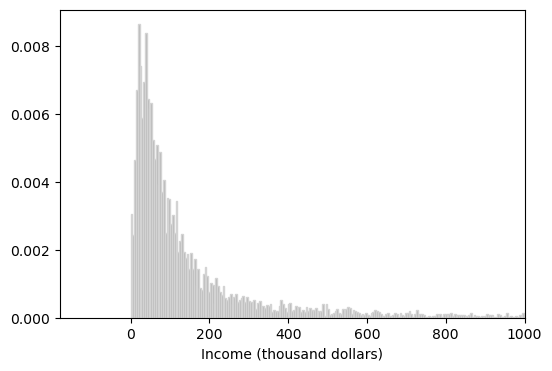

In [105]:
# 히스토그램을 생성
plt.figure(figsize=(6, 4))

plt.xlabel('Income (thousand dollars)')
num_bins = 100000
plt.hist(X, num_bins, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-180, 1000])
plt.show()

### 가중 히스토그램

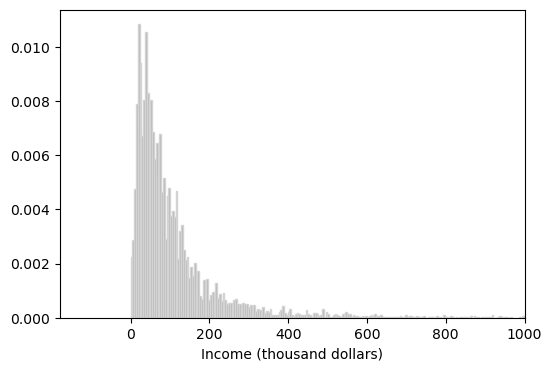

In [106]:
# 히스토그램을 생성
plt.figure(figsize=(6, 4))

plt.xlabel('Income (thousand dollars)')
num_bins = 100000
plt.hist(X, num_bins, weights=w, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-180, 1000])
plt.show()

### Log-normal 분포 Weighted MLE 

$$\text{argmax} \sum_i w_i \log L(\mu, \sigma \mid x_i)$$

#### 파라미터 제약조건을 옵션(`bounds`)으로 제공하는 방식

In [107]:
mu_init = 0
sigma_init = 1

params_init = np.array([mu_init, sigma_init])
res_LN = opt.minimize(weight_obj_LN, params_init, args=(X, w),
                      method='L-BFGS-B', 
                      bounds=((None, None),(1e-10, None)))
mu_MLE, sigma_MLE = res_LN.x

print('mu_MLE =',mu_MLE, 'sigma_MLE =',sigma_MLE)
print("Objective function value at solution:", res_LN.fun)

mu_MLE = 4.211760006274043 sigma_MLE = 1.427241346666939
Objective function value at solution: 5.98644396594892


#### 양의 값을 갖는 파라미터에 exp를 취하는 방식

In [108]:
mu_init = 0
sigma_init = 0

params_init = np.array([mu_init, sigma_init])
res_LN = opt.minimize(weight_obj_LN_e, params_init, args=(X, w),
                      method='L-BFGS-B')
mu_MLE, sigma_MLE = res_LN.x

sigma_MLE = np.exp(sigma_MLE)

print('mu_MLE =',mu_MLE, 'sigma_MLE =',sigma_MLE)
print("Objective function value at solution:", res_LN.fun)

mu_MLE = 4.21175826006971 sigma_MLE = 1.4272366593555585
Objective function value at solution: 5.986443965958112


In [109]:
res_LN

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 5.986443965958112
        x: [ 4.212e+00  3.557e-01]
      nit: 17
      jac: [-2.043e-06 -5.063e-06]
     nfev: 57
     njev: 19
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

### 평균 표준편차 왜도 첨도

In [110]:
print("Weighted Mean:", weighted_mean(X, w))
print("Weighted S.D.:", weighted_std(X, w))
print("Weighted Skewness:", weighted_skewness(X, w))
print("Weighted Kurtosis:", weighted_kurtosis(X, w))

Weighted Mean: 141.38988871023287
Weighted S.D.: 727.962060422495
Weighted Skewness: 166.76137349390837
Weighted Kurtosis: 63910.56667743045


In [111]:
print("Mean:", LN_mean(mu_MLE, sigma_MLE))
print("S.D.:", LN_var(mu_MLE, sigma_MLE)**0.5)
print("Skewness:", LN_skewness(mu_MLE, sigma_MLE))
print("Kurtosis:", LN_kurtosis(mu_MLE, sigma_MLE))

Mean: 186.8414695659069
S.D.: 482.4565966647683
Skewness: 24.96341122034233
Kurtosis: 4531.488434776198


### 히스토그램 vs. 추정 PDF

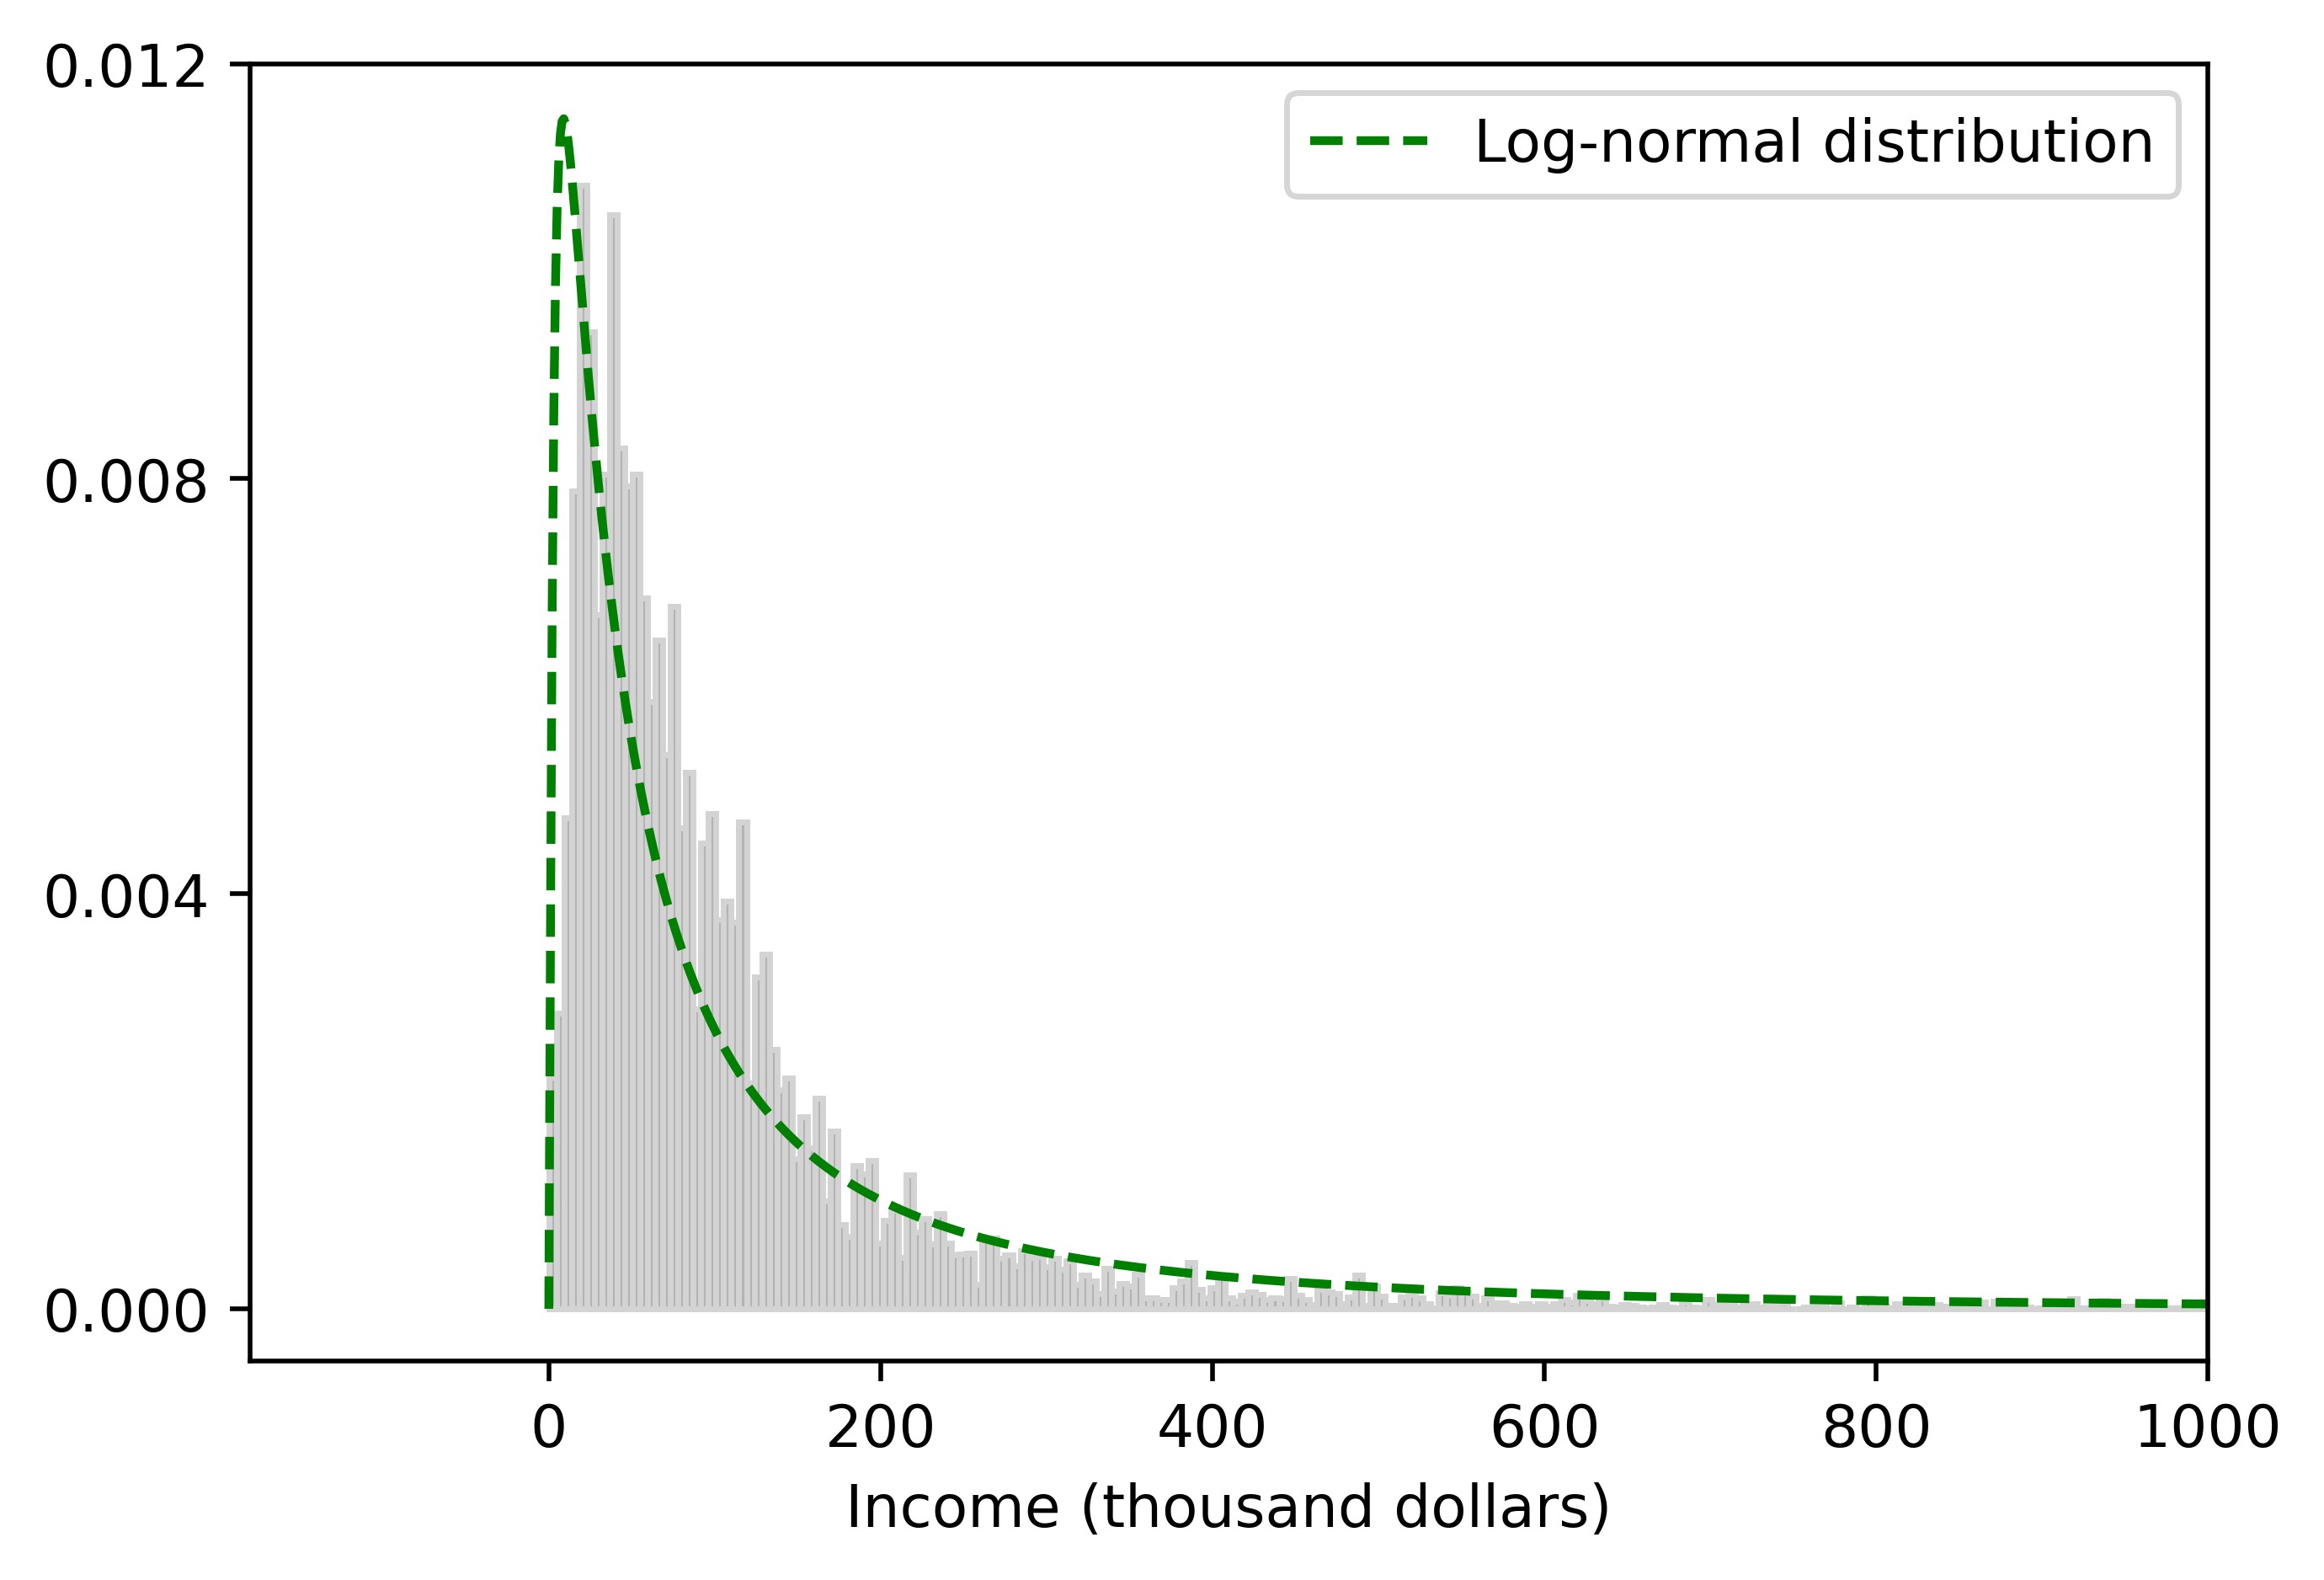

In [112]:
# 새로운 그림을 생성하고 해상도를 조정
plt.figure(figsize=(6, 4), dpi=500)

plt.xlabel('Income (thousand dollars)')

# Plot the histogram of the data
num_bins = 100000
plt.hist(X, num_bins, weights=w, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-180, 1000])
plt.ylim(-0.0005, 0.012)

# Plot the MLE estimated distribution
dist_X = np.linspace(1e-10, 1000, 1000)
plt.plot(dist_X, LN_pdf(dist_X, mu_MLE, sigma_MLE),
         linewidth=1.5, linestyle='dashed', color='g', label='Log-normal distribution')
plt.legend(loc='upper right')

# 세로축 눈금을 설정
plt.yticks([0.000, 0.004, 0.008, 0.012])

# 그래프 표시
plt.show()

### 로렌츠 곡선 및 지니계수

#### 단순 계산

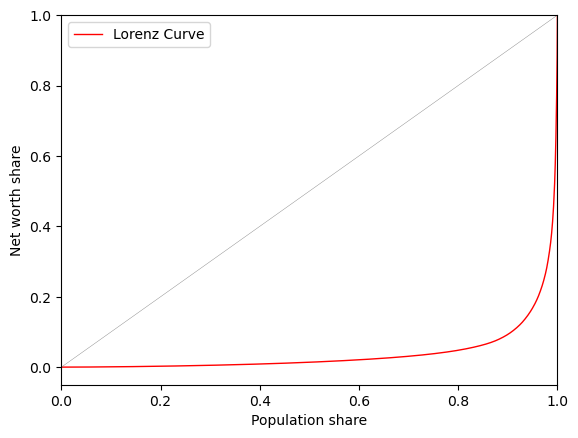

단순 Gini Coefficient: 0.9217


In [113]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 정렬
sorted_X = np.sort(X)

# Lorenz 곡선 계산k
n = len(sorted_X)
cumulative_percentage = np.cumsum(sorted_X) / np.sum(sorted_X)
lorenz_curve_x = np.arange(1, n+1) / n
lorenz_curve_y = cumulative_percentage

# Lorenz 곡선 그리기
plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

# Gini 계수 계산
area_under_lorenz = np.trapz(lorenz_curve_y, lorenz_curve_x)
area_under_equality = 0.5  # 0에서 1 사이의 대각선 선분 아래 영역
gini_coefficient = (area_under_equality - area_under_lorenz) / area_under_equality
print(f'단순 Gini Coefficient: {gini_coefficient:.4f}')

#### 가중치 사용

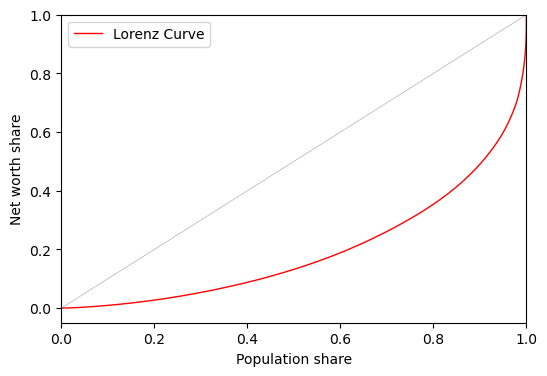

가중 Gini Coefficient: 0.6068


In [114]:
plt.figure(figsize=(6, 4))

# 데이터를 값 순서대로 정렬
sorted_data = np.asarray([X, w]).T[np.argsort(X)]
sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
# 총 가중치 및 가중치가 적용된 누적 소득 계산
total_weight = np.sum(sorted_w)
sorted_w = sorted_w / total_weight
cumulative_w = np.cumsum(sorted_w)
    
# 가중치가 적용된 누적 소득 비율 계산
total_x = np.sum(sorted_x * sorted_w)
weighted_cumulative_percentage = np.cumsum(sorted_x * sorted_w) / total_x

lorenz_curve_x = cumulative_w
lorenz_curve_y = weighted_cumulative_percentage

plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

# Gini 계수 계산
area_under_lorenz = np.trapz(lorenz_curve_y, lorenz_curve_x)
area_under_equality = 0.5  # 0에서 1 사이의 대각선 선분 아래 영역
gini_coefficient = (area_under_equality - area_under_lorenz) / area_under_equality
print(f'가중 Gini Coefficient: {gini_coefficient:.4f}')

#### Parametric Estimation 결과

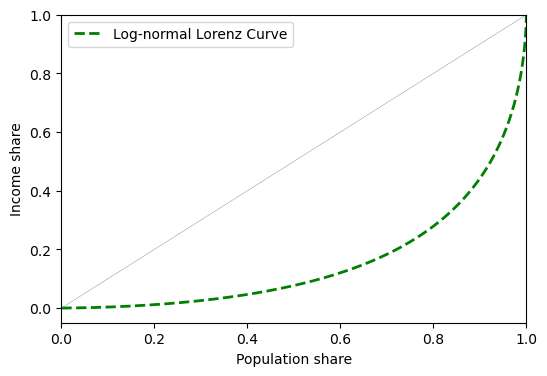

In [115]:
plt.figure(figsize=(6, 4))

dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_LN(dist_X, sigma_MLE),
         linewidth=2, linestyle='dashed', color='g', label='Log-normal Lorenz Curve')

plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Income share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

#### 지니계수

$$
2\Phi\left(\frac{\sigma}{\sqrt{2}}\right) - 1
$$

In [116]:
gini = 2 * norm.cdf(sigma_MLE / np.sqrt(2)) - 1
gini

0.6871254545732142

#### 지니계수(수치 적분)

In [117]:
from scipy.integrate import quad

res, err = quad(Lorenz_LN, 0, 1, args=(sigma_MLE))
1-2*res

0.6871254545985546

#### 결과 비교 그림

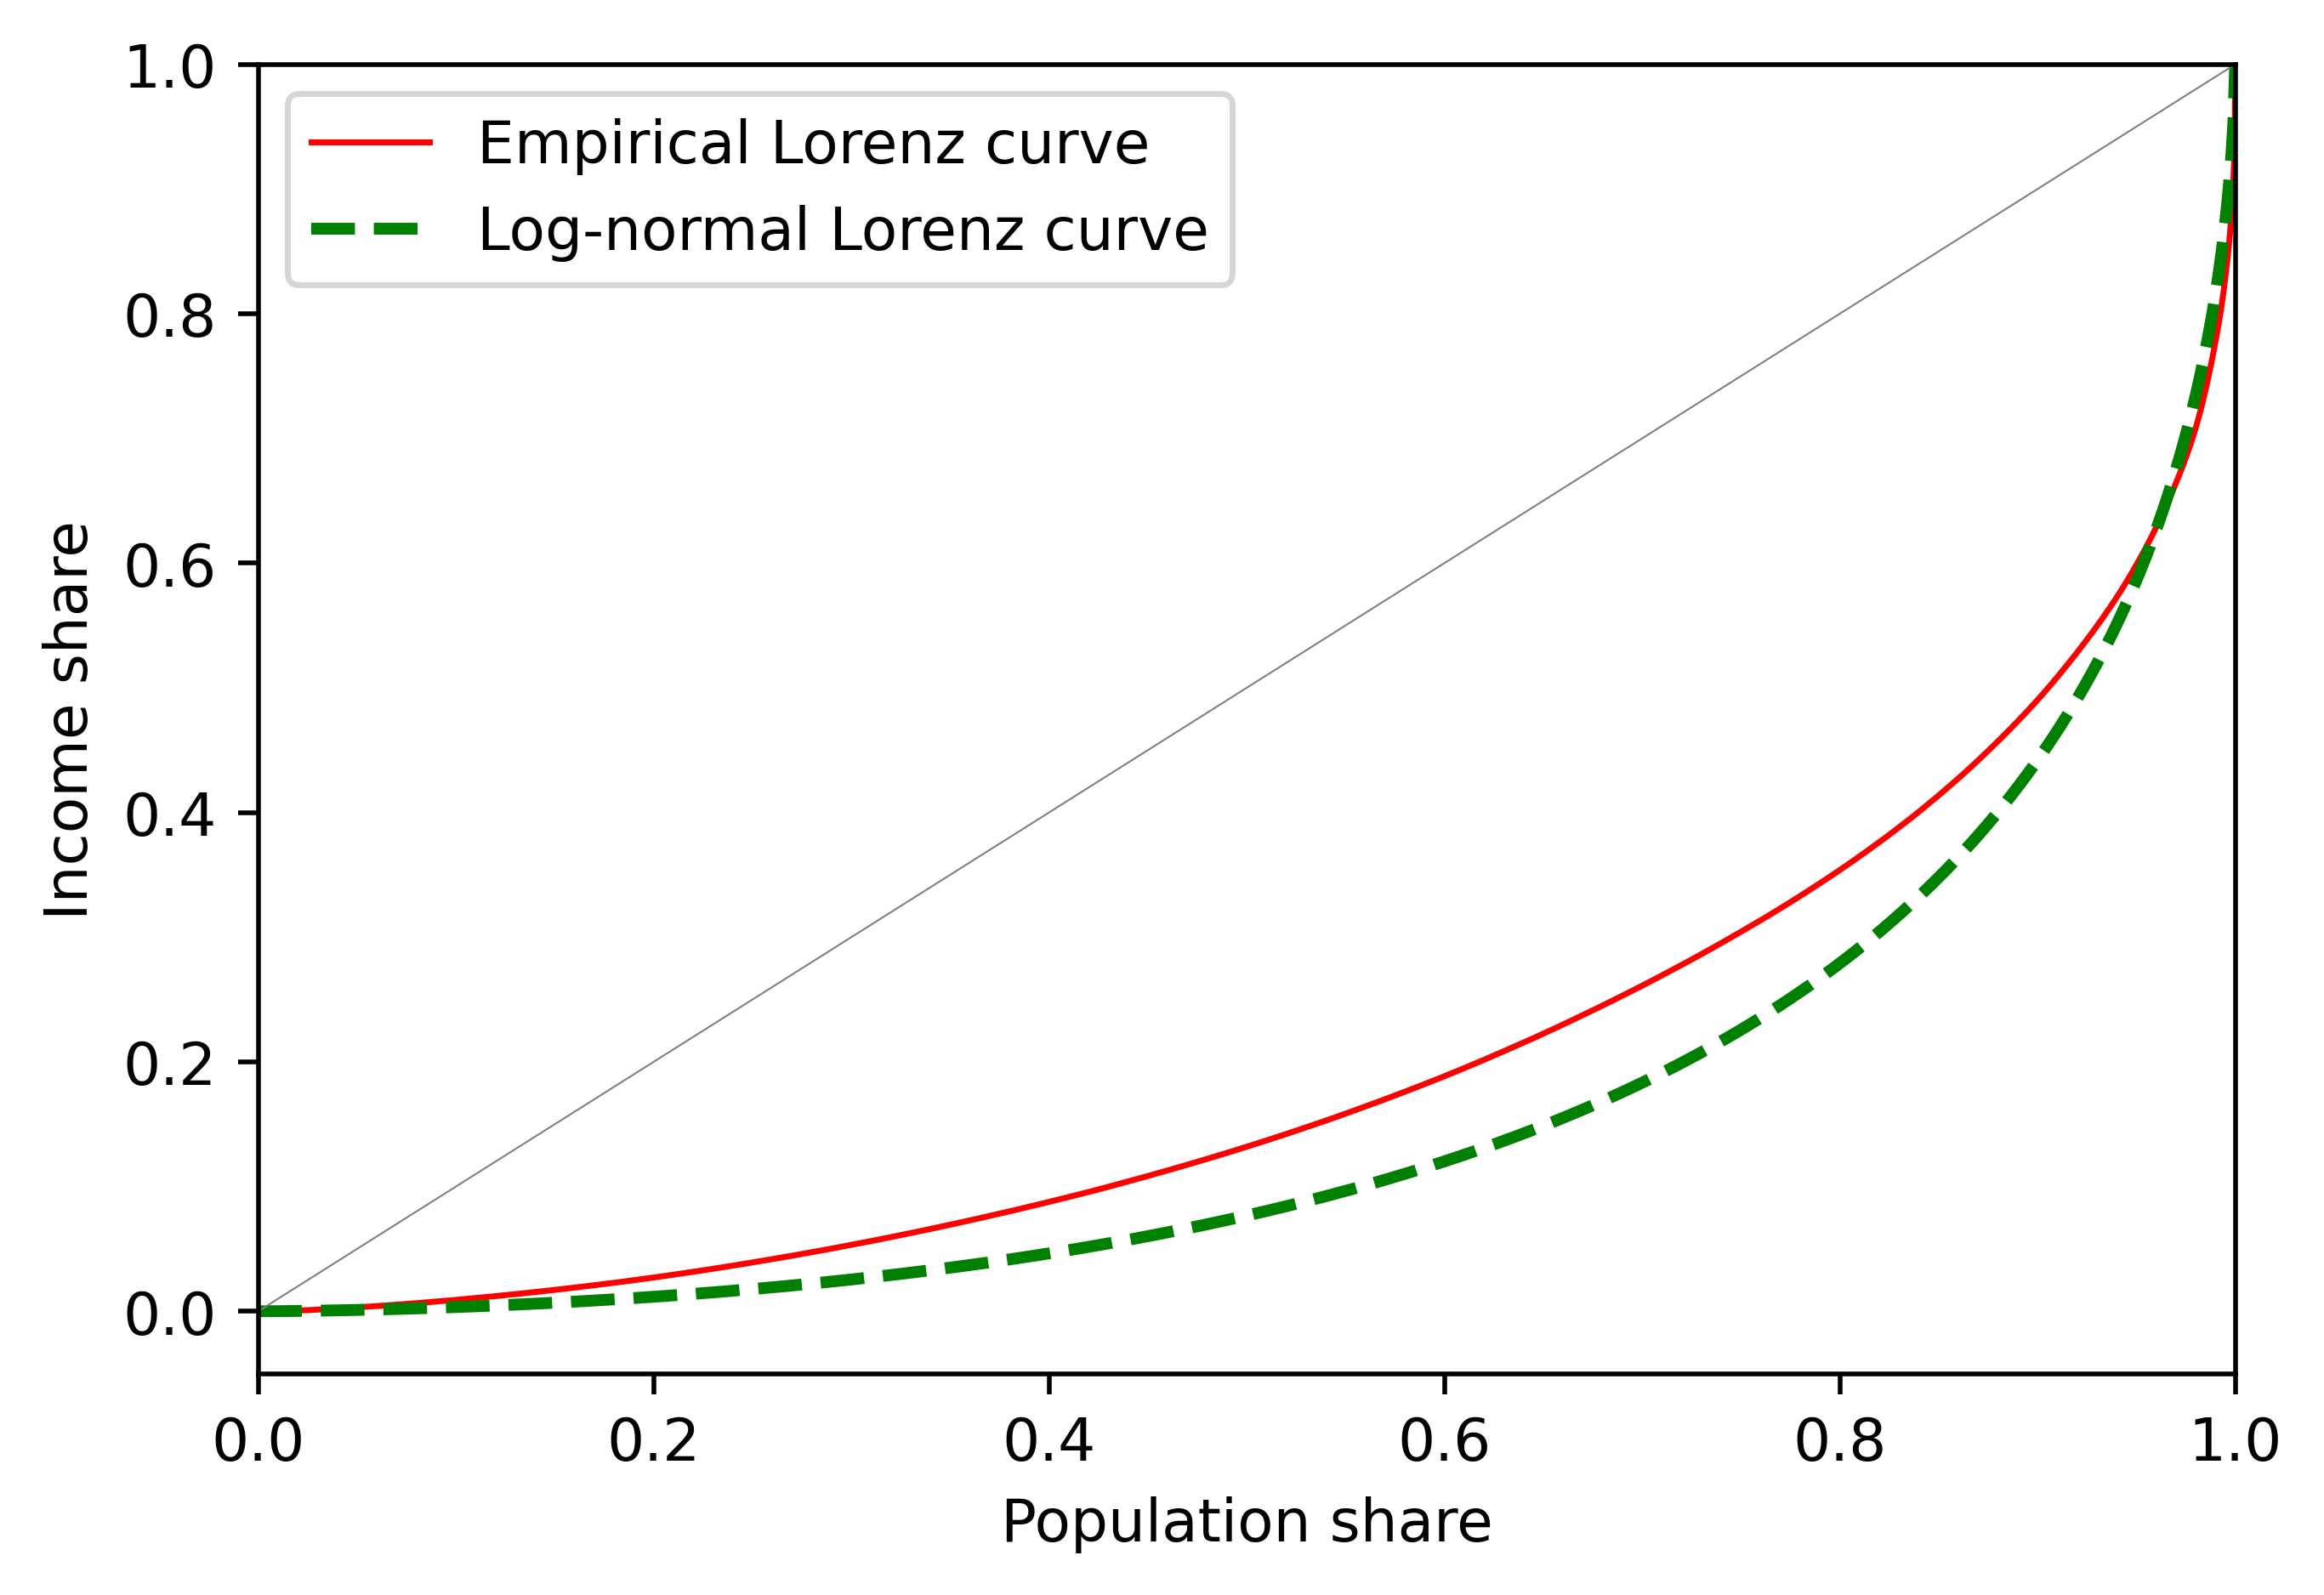

In [118]:
# 새로운 그림을 생성하고 해상도를 조정합니다.
plt.figure(figsize=(6, 4), dpi=500)

# Empirical Lorenz 곡선
sorted_data = np.asarray([X, w]).T[np.argsort(X)]
sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
total_weight = np.sum(sorted_w)
sorted_w = sorted_w / total_weight
cumulative_w = np.cumsum(sorted_w)
    
total_x = np.sum(sorted_x * sorted_w)
weighted_cumulative_percentage = np.cumsum(sorted_x * sorted_w) / total_x

lorenz_curve_x = cumulative_w
lorenz_curve_y = weighted_cumulative_percentage

plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Empirical Lorenz curve')

# SU Lorenz 곡선
dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_LN(dist_X, sigma_MLE),
         linewidth=2, linestyle='dashed', color='g', label='Log-normal Lorenz curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)

plt.xlabel('Population share')
plt.ylabel('Income share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

### 3.5 Income in 2022 with GB2

In [119]:
income_2022 = income_dict['income_2022']
weight_2022 = weight_dict['weight_2022']

In [120]:
print('소득이 0인 가구', np.sum(income_2022 == 0)/5)
print('전체 가구', len(income_2022)/5)
print('소득이 0인 가구의 비중(%)', np.sum(income_2022 == 0)/len(income_2022)*100)

소득이 0인 가구 39.4
전체 가구 4595.0
소득이 0인 가구의 비중(%) 0.8574537540805224


In [121]:
#income_2022.replace(0, 1e-5, inplace=True)
#X = income_2022
X = income_2022.replace(0, 1e-5)
w = weight_2022/(weight_2022.sum())
X.describe().apply(lambda x: '%.2f' % x)

count     22975.00
mean       1592.86
std       12442.71
min           0.00
25%          42.16
50%          94.04
75%         264.82
max      458230.95
Name: income, dtype: object

In [122]:
print("Weighted Mean:", weighted_mean(X, w))
print("Weighted S.D.:", weighted_std(X, w))
print("Weighted Skewness:", weighted_skewness(X, w))
print("Weighted Kurtosis:", weighted_kurtosis(X, w))

Weighted Mean: 141.38988871023287
Weighted S.D.: 727.962060422495
Weighted Skewness: 166.76137349390837
Weighted Kurtosis: 63910.56667743045


#### 가중 지니계수

In [123]:
print('가중 gini_2022:', weighted_gini(X, w))

가중 gini_2022: 0.6068066012415092


### 단순 히스토그램

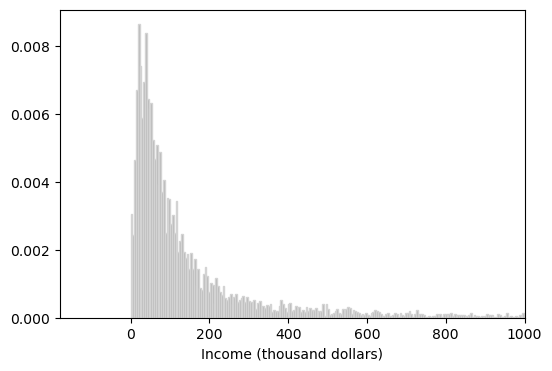

In [124]:
# 히스토그램을 생성
plt.figure(figsize=(6, 4))

plt.xlabel('Income (thousand dollars)')
num_bins = 100000
plt.hist(X, num_bins, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-180, 1000])
plt.show()

### 가중 히스토그램

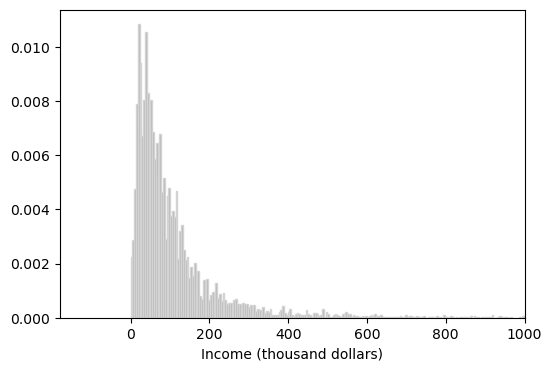

In [125]:
# 히스토그램을 생성
plt.figure(figsize=(6, 4))

plt.xlabel('Income (thousand dollars)')
num_bins = 100000
plt.hist(X, num_bins, weights=w, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-180, 1000])
plt.show()

### GB2 분포 Weighted MLE 

$$\text{argmax} \sum_i w_i \log L(a,b,p,q \mid x_i)$$

#### 파라미터 제약조건을 옵션(`bounds`)으로 제공하는 방식

In [126]:
a_init = 1
b_init = 1
p_init = 1
q_init = 1

params_init = np.array([a_init, b_init, p_init, q_init])
res_GB2 = opt.minimize(weight_obj_GB2, params_init, args=(X, w),
                       method='L-BFGS-B',
                       bounds=((1e-10, None),(1e-10, None),(1e-10, None),(1e-10, None)))
a_MLE, b_MLE, p_MLE, q_MLE = res_GB2.x

print('a_MLE =',a_MLE, 'b_MLE =',b_MLE, 'p_MLE =',p_MLE, 'q_MLE =',q_MLE)
print("Objective function value at solution:", res_GB2.fun)

a_MLE = 3.211750911679081 b_MLE = 81.46075613010554 p_MLE = 0.375093840481984 q_MLE = 0.46482091204767856
Objective function value at solution: 5.732070375092171


#### 양의 값을 갖는 파라미터에 exp를 취하는 방식

In [127]:
a_init = 0
b_init = 0
p_init = 0
q_init = 0

params_init = np.array([a_init, b_init, p_init, q_init])
res_GB2 = opt.minimize(weight_obj_GB2_e, params_init, args=(X, w),
                       method='L-BFGS-B')
a_MLE, b_MLE, p_MLE, q_MLE = res_GB2.x
a_MLE = np.exp(a_MLE)
b_MLE = np.exp(b_MLE)
p_MLE = np.exp(p_MLE)
q_MLE = np.exp(q_MLE)

print('a_MLE =',a_MLE, 'b_MLE =',b_MLE, 'p_MLE =',p_MLE, 'q_MLE =',q_MLE)
print("Objective function value at solution:", res_GB2.fun)

a_MLE = 3.211721926038658 b_MLE = 81.45903595486728 p_MLE = 0.3751021869024333 q_MLE = 0.464823093123624
Objective function value at solution: 5.732070375005691


In [128]:
res_GB2

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 5.732070375005691
        x: [ 1.167e+00  4.400e+00 -9.806e-01 -7.661e-01]
      nit: 31
      jac: [-2.576e-06 -8.882e-08 -1.865e-06 -2.665e-07]
     nfev: 180
     njev: 36
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

### 히스토그램 vs. 추정 PDF

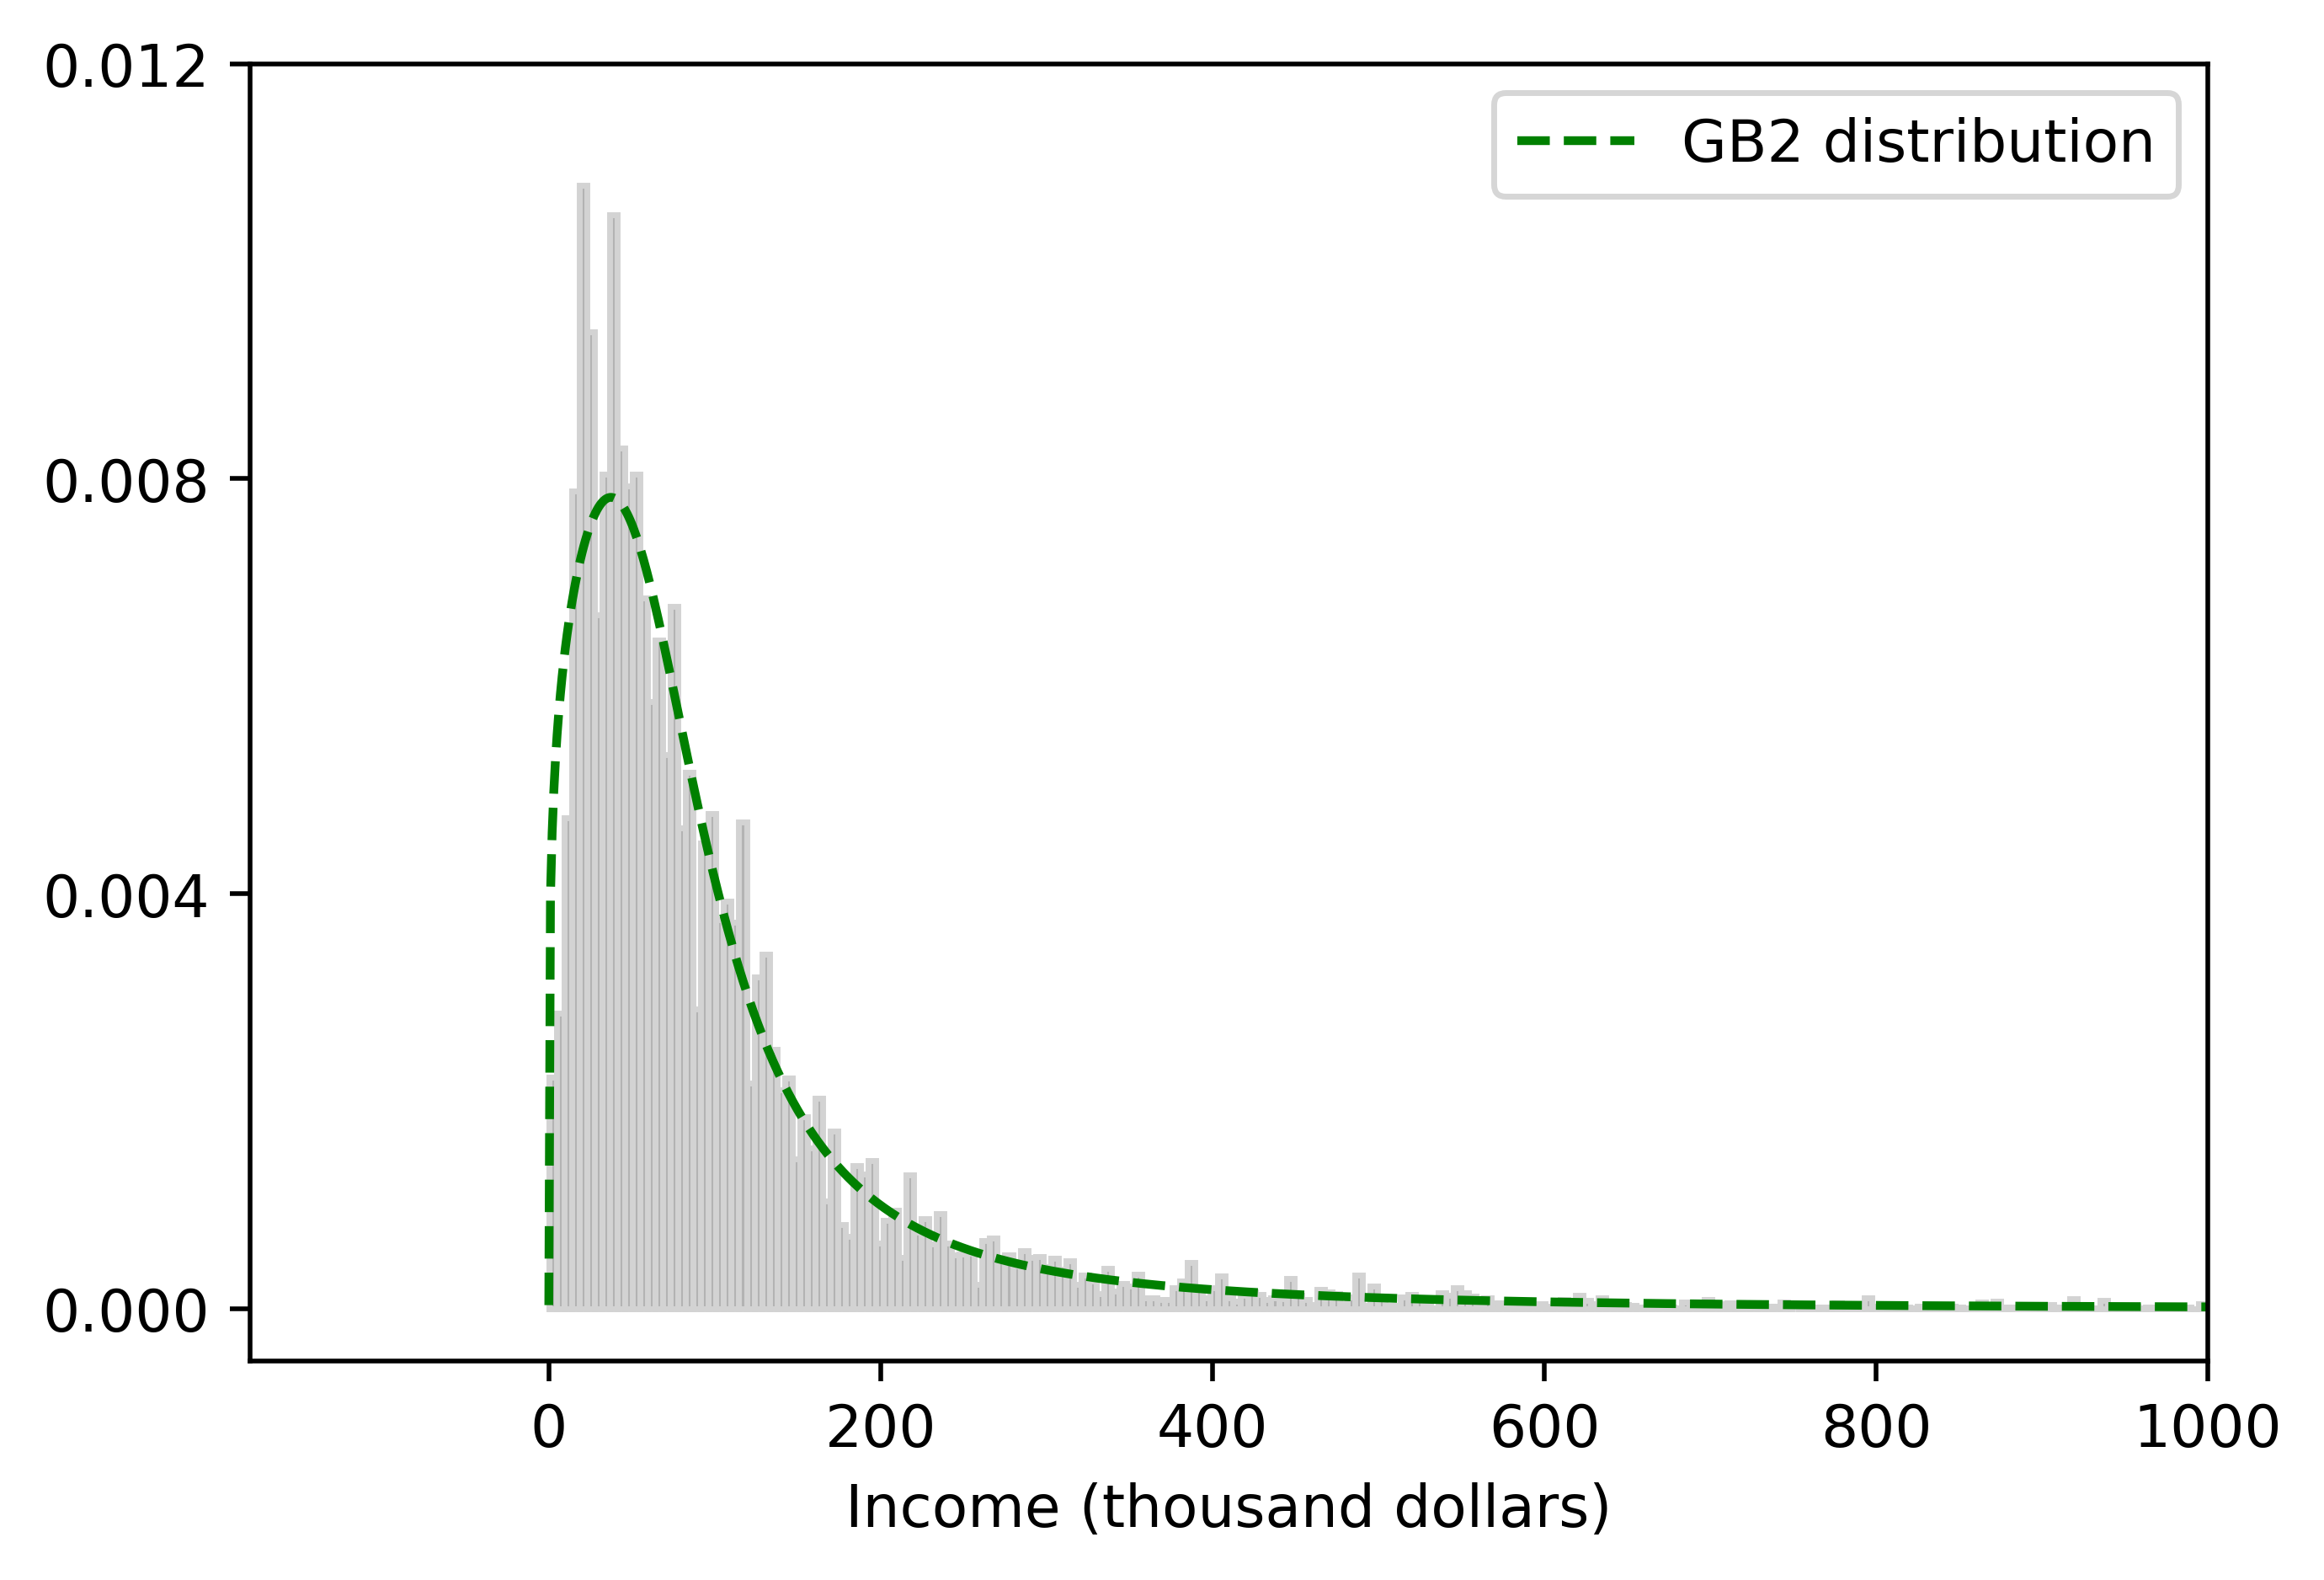

In [129]:
# 새로운 그림을 생성하고 해상도를 조정
plt.figure(figsize=(6, 4), dpi=500)

plt.xlabel('Income (thousand dollars)')

# Plot the histogram of the data
num_bins = 100000
plt.hist(X, num_bins, weights=w, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-180, 1000])
plt.ylim(-0.0005, 0.012)

# Plot the MLE estimated distribution
dist_X = np.linspace(1e-10, 1000, 1000)
plt.plot(dist_X, GB2_pdf(dist_X, a_MLE, b_MLE, p_MLE, q_MLE),
         linewidth=1.5, linestyle='dashed', color='g', label='GB2 distribution')
plt.legend(loc='upper right')

# 세로축 눈금을 설정
plt.yticks([0.000, 0.004, 0.008, 0.012])

# 그래프 표시
plt.show()

### 로렌츠 곡선 및 지니계수

#### 단순 계산

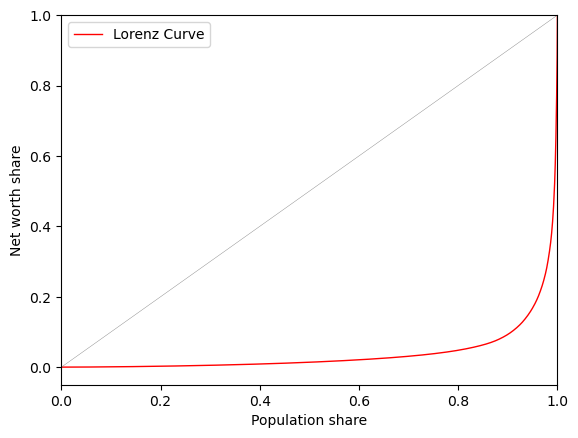

단순 Gini Coefficient: 0.9217


In [130]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 정렬
sorted_X = np.sort(X)

# Lorenz 곡선 계산k
n = len(sorted_X)
cumulative_percentage = np.cumsum(sorted_X) / np.sum(sorted_X)
lorenz_curve_x = np.arange(1, n+1) / n
lorenz_curve_y = cumulative_percentage

# Lorenz 곡선 그리기
plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

# Gini 계수 계산
area_under_lorenz = np.trapz(lorenz_curve_y, lorenz_curve_x)
area_under_equality = 0.5  # 0에서 1 사이의 대각선 선분 아래 영역
gini_coefficient = (area_under_equality - area_under_lorenz) / area_under_equality
print(f'단순 Gini Coefficient: {gini_coefficient:.4f}')

#### 가중치 사용

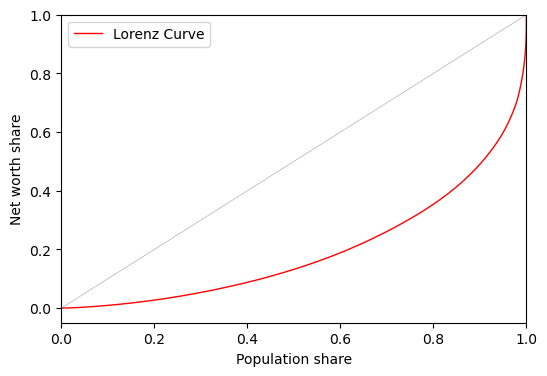

가중 Gini Coefficient: 0.6068


In [131]:
plt.figure(figsize=(6, 4))

# 데이터를 값 순서대로 정렬
sorted_data = np.asarray([X, w]).T[np.argsort(X)]
sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
# 총 가중치 및 가중치가 적용된 누적 소득 계산
total_weight = np.sum(sorted_w)
sorted_w = sorted_w / total_weight
cumulative_w = np.cumsum(sorted_w)
    
# 가중치가 적용된 누적 소득 비율 계산
total_x = np.sum(sorted_x * sorted_w)
weighted_cumulative_percentage = np.cumsum(sorted_x * sorted_w) / total_x

lorenz_curve_x = cumulative_w
lorenz_curve_y = weighted_cumulative_percentage

plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

# Gini 계수 계산
area_under_lorenz = np.trapz(lorenz_curve_y, lorenz_curve_x)
area_under_equality = 0.5  # 0에서 1 사이의 대각선 선분 아래 영역
gini_coefficient = (area_under_equality - area_under_lorenz) / area_under_equality
print(f'가중 Gini Coefficient: {gini_coefficient:.4f}')

#### Parametric Estimation 결과

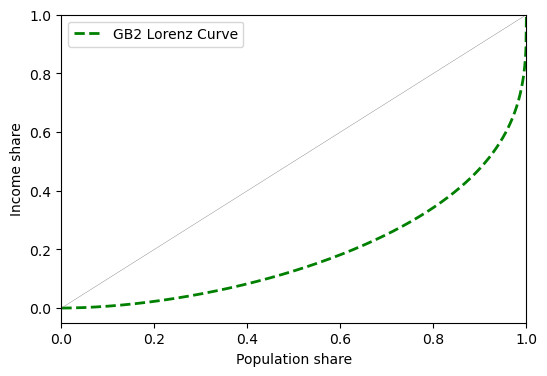

In [132]:
plt.figure(figsize=(6, 4))

dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_GB2(dist_X, a_MLE, p_MLE, q_MLE),
         linewidth=2, linestyle='dashed', color='g', label='GB2 Lorenz Curve')

plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Income share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

#### 지니계수(수치 적분)

In [133]:
from scipy.integrate import quad

res, err = quad(Lorenz_GB2, 0, 1, args=(a_MLE, p_MLE, q_MLE))
1-2*res

0.6215279856785076

#### 결과 비교 그림

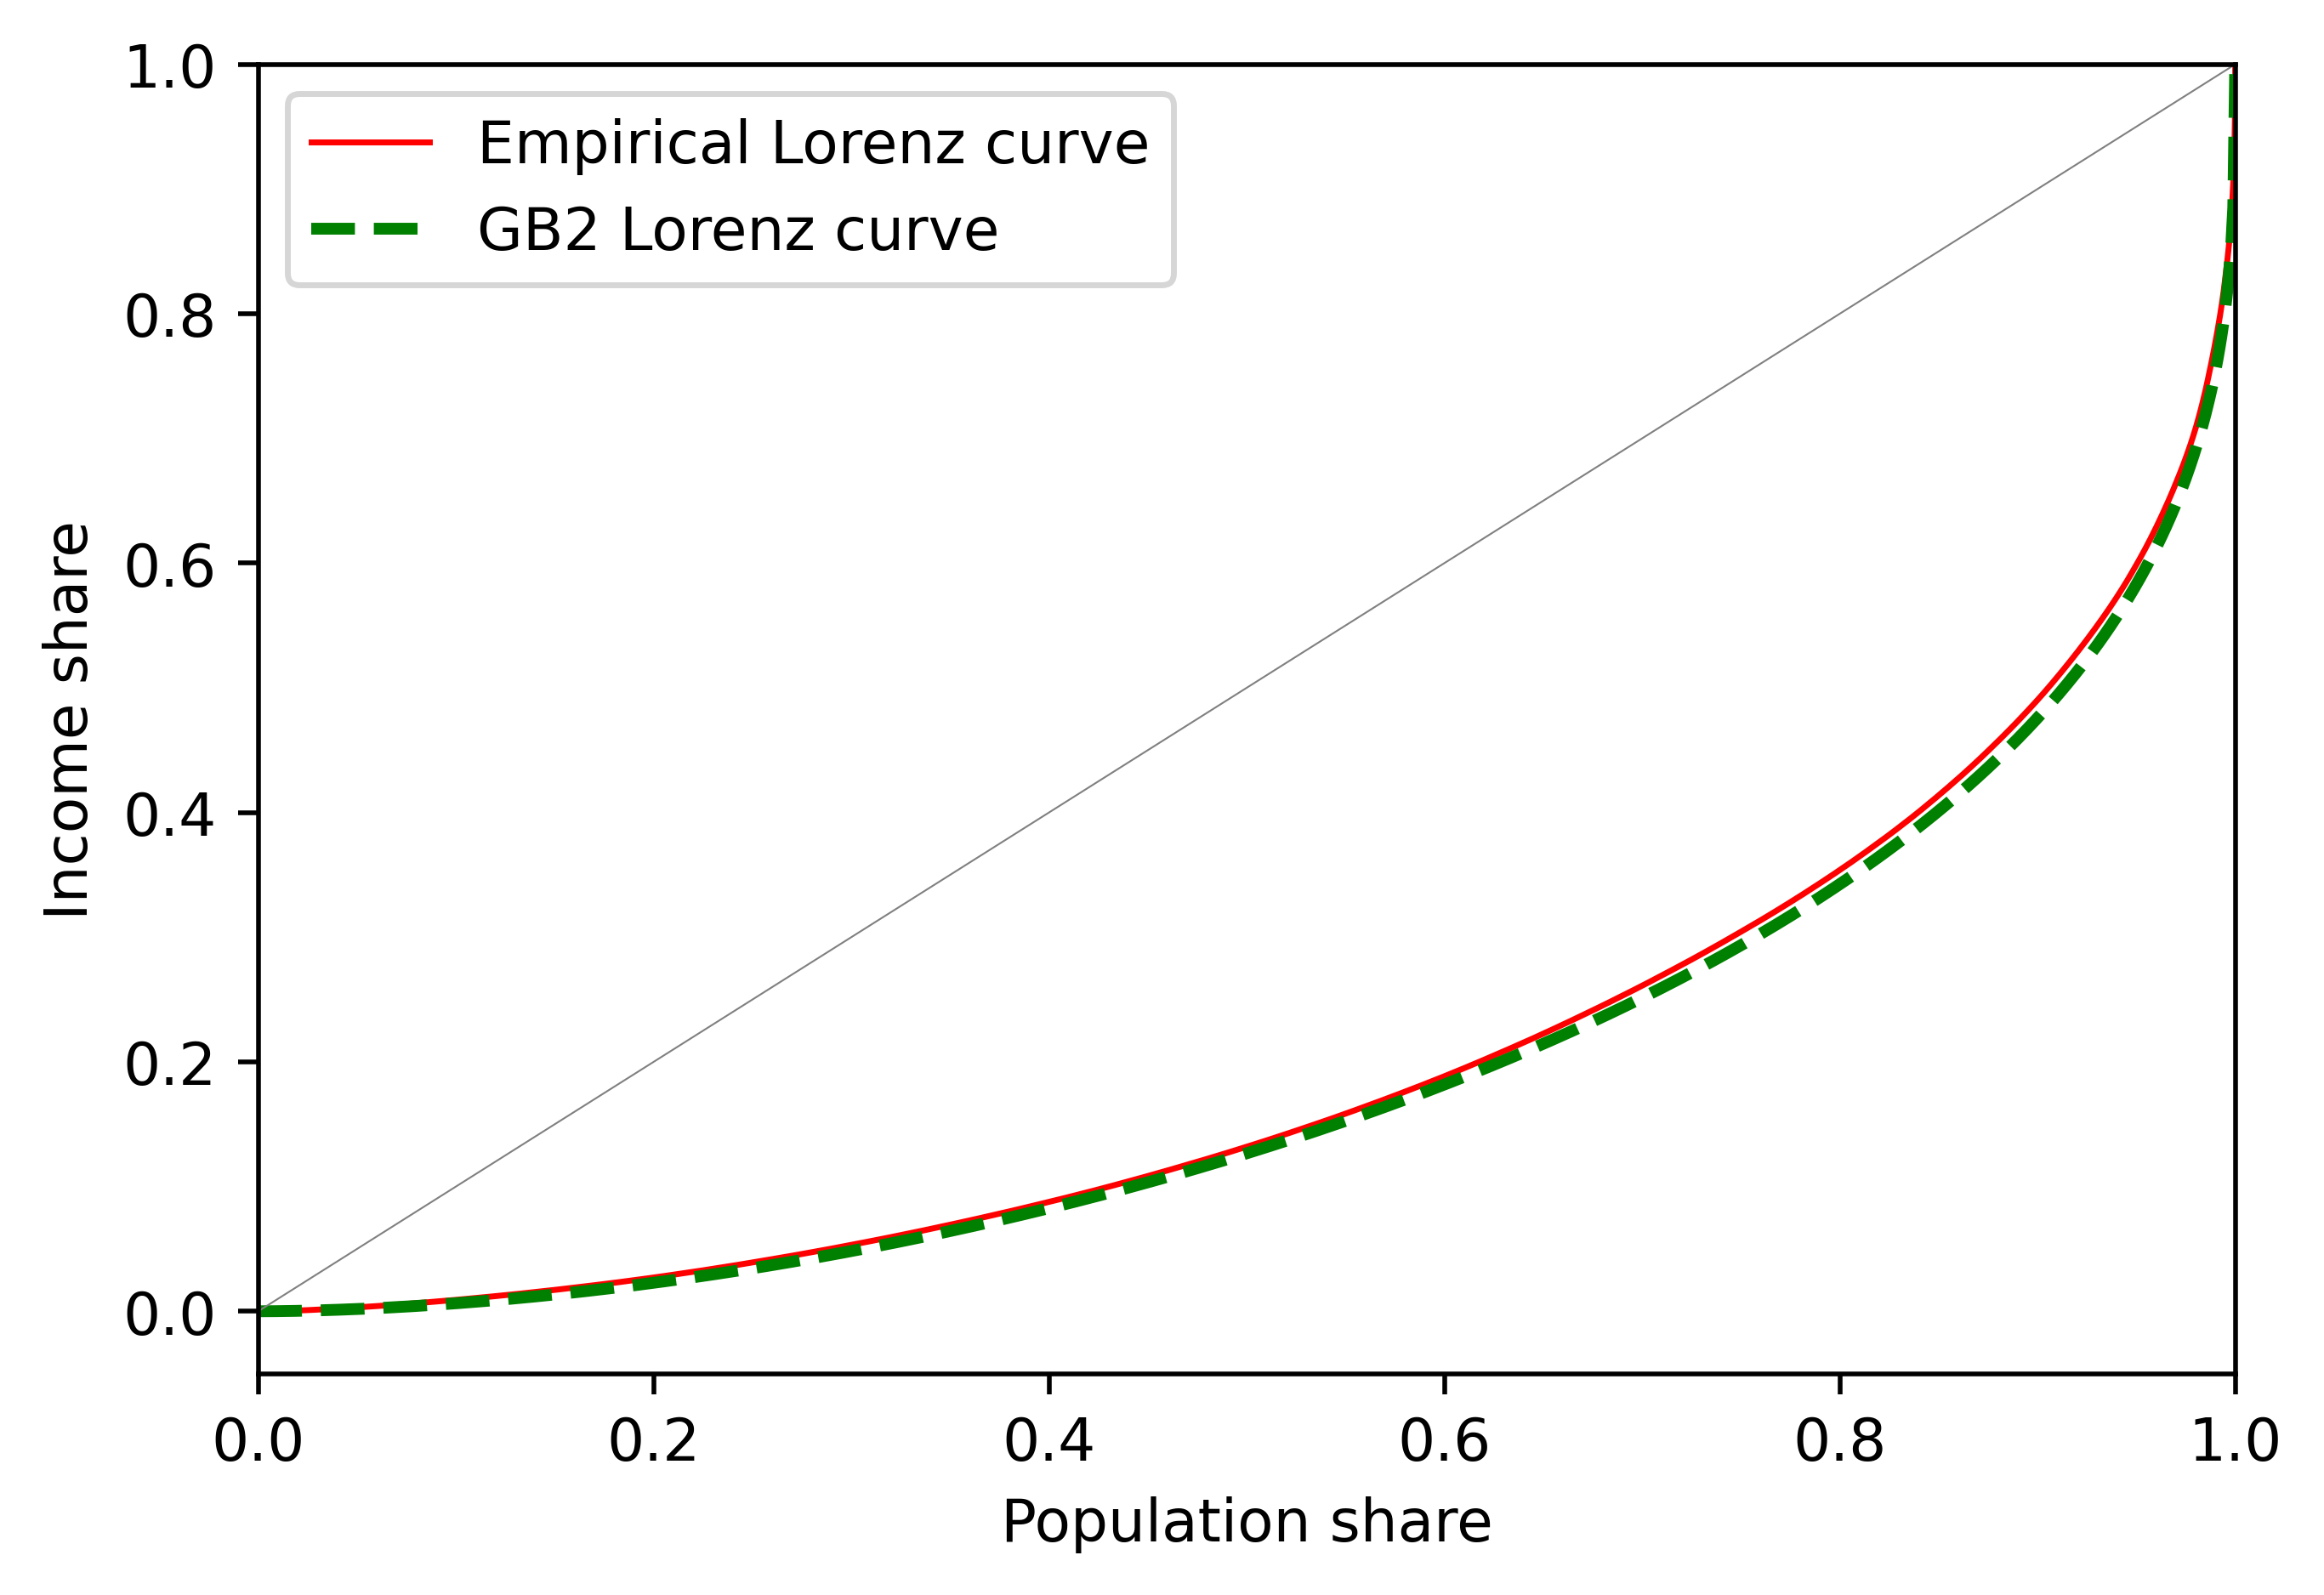

In [134]:
# 새로운 그림을 생성하고 해상도를 조정합니다.
plt.figure(figsize=(6, 4), dpi=500)

# Empirical Lorenz 곡선
sorted_data = np.asarray([X, w]).T[np.argsort(X)]
sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
total_weight = np.sum(sorted_w)
sorted_w = sorted_w / total_weight
cumulative_w = np.cumsum(sorted_w)
    
total_x = np.sum(sorted_x * sorted_w)
weighted_cumulative_percentage = np.cumsum(sorted_x * sorted_w) / total_x

lorenz_curve_x = cumulative_w
lorenz_curve_y = weighted_cumulative_percentage

plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Empirical Lorenz curve')

# GB2 Lorenz 곡선
dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_GB2(dist_X, a_MLE, p_MLE, q_MLE),
         linewidth=2, linestyle='dashed', color='g', label='GB2 Lorenz curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)

plt.xlabel('Population share')
plt.ylabel('Income share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

## 4. 가계금융복지조사 데이터 추정

### 4.1 Net Worth in 2022

In [135]:
X = df_2022["순자산"]/100 # 단위: 백만원
w = df_2022["가중값"]/(df_2022["가중값"].sum())
X.describe().apply(lambda x: '%.2f' % x)

count    17954.00
mean       430.35
std        719.86
min       -779.50
25%         63.00
50%        216.60
75%        522.40
max      16515.50
Name: 순자산, dtype: object

In [136]:
print("Weighted Mean:", weighted_mean(X, w))
print("Weighted S.D.:", weighted_std(X, w))
print("Weighted Skewness:", weighted_skewness(X, w))
print("Weighted Kurtosis:", weighted_kurtosis(X, w))

Weighted Mean: 456.0232782013843
Weighted S.D.: 695.7659960415185
Weighted Skewness: 5.884293637629193
Weighted Kurtosis: 75.87888019889189


#### 가중 지니계수

In [137]:
print('가중 gini_2022:', weighted_gini(X, w))

가중 gini_2022: 0.6099229357996476


### 단순 히스토그램

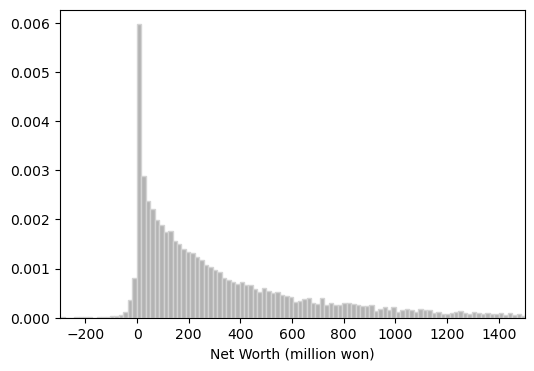

In [138]:
# 히스토그램을 생성
plt.figure(figsize=(6, 4))

plt.xlabel('Net Worth (million won)')
num_bins = 1000
plt.hist(X, num_bins, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-300, 1500])
plt.show()

### 가중 히스토그램

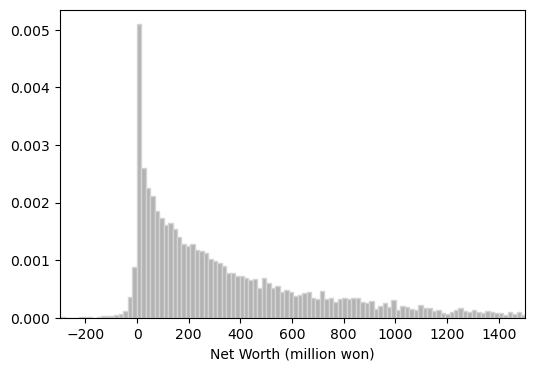

In [139]:
# 히스토그램을 생성
plt.figure(figsize=(6, 4))

plt.xlabel('Net Worth (million won)')
num_bins = 1000
plt.hist(X, num_bins, weights=w, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-300, 1500])
plt.show()

### SU 분포 Weighted MLE 

$$\text{argmax} \sum_i w_i \log L(m,s,\lambda, \theta \mid x_i)$$

#### 파라미터 제약조건을 옵션(`bounds`)으로 제공하는 방식

In [140]:
m_init = 0
s_init = 1
lambda_init = 0
theta_init = 1

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(weight_obj_SU, params_init, args=(X, w),
                      method='L-BFGS-B', 
                      bounds=((None, None),(1e-10, None),(None, None),(1e-10, None)))
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE)
print("Objective function value at solution:", res_SU.fun)

m_MLE = -20.099387080584478 s_MLE = 33.465503863452184 lambda_MLE = 2.6559704477832353 theta_MLE = 1.2650213430829969
Objective function value at solution: 7.194295656346126


#### 양의 값을 갖는 파라미터에 exp를 취하는 방식

In [141]:
m_init = 0
s_init = 0
lambda_init = 0
theta_init = 0

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(weight_obj_SU_e, params_init, args=(X, w),
                      method='L-BFGS-B')
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

s_MLE = np.exp(s_MLE)
theta_MLE = np.exp(theta_MLE)

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE)
print("Objective function value at solution:", res_SU.fun)

m_MLE = -20.10238964644742 s_MLE = 33.46212930194506 lambda_MLE = 2.6560970396642056 theta_MLE = 1.2650046042161003
Objective function value at solution: 7.194295656231224


#### 자코비안 행렬 제공

In [142]:
from numpy import arcsinh as asinh
from numpy import sqrt as sqrt

m_init = 0
s_init = 0
lambda_init = 0
theta_init = 0
# NOTE: 자코비안 함수를 제공하는 경우 오히려 초기값의 영향을 더 많이 받는듯 함. 
# 가령 모든 초기값을 0으로 할 경우 최적화가 되지 않음.

# 그래디언트 함수
def grad_logL(params, *args):
    m, s, lambda_, theta = params
    (x, w) = args
    
    s = np.exp(s)
    theta = np.exp(theta)
    
    ll_m = np.sum(w*(
        (-m + x)/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))/(s*theta**2*sqrt(1 + (-m + x)**2/s**2))
    ))
    ll_s = np.sum(w*(s*(
        -s/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_l = np.sum(w*(
        -(2*lambda_ - 2*asinh((-m + x)/s))/(2*theta**2)
    ))
    ll_t = np.sum(w*(theta*(
        -1/theta + (-lambda_ + asinh((-m + x)/s))**2/theta**3
    )))
    
    return -np.array([ll_m, ll_s, ll_l, ll_t])

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(weight_obj_SU_e, params_init, args=(X, w), tol=1e-100,
                      method='Newton-CG', options={'maxiter': 100000},
                      jac=grad_logL)
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

s_MLE = np.exp(s_MLE)
theta_MLE = np.exp(theta_MLE)

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE)
print("Objective function value at solution:", res_SU.fun)

m_MLE = -20.100801647480743 s_MLE = 33.462846282844595 lambda_MLE = 2.656054711643117 theta_MLE = 1.2650217187664379
Objective function value at solution: 7.194295656082312


#### 자코비안 & 헤시안 행렬 제공

아래에서 보듯이 `opt.minimize`에 `tol=1e-100` or/and `options={'maxiter': 100000}` 옵션을 부과해야 비슷한 로그가능도 값에 도달함. 그렇지 않으면 (마이너스) 로그가능도 값이 더 높음.

In [143]:
import time
start_time = time.time()

from numpy import arcsinh as asinh
from numpy import sqrt as sqrt

m_init = 0
s_init = 0
lambda_init = 0
theta_init = 0

# 그래디언트 함수
def grad_logL(params, *args):
    m, s, lambda_, theta = params
    (x, w) = args
    
    s = np.exp(s)
    theta = np.exp(theta)
    
    ll_m = np.sum(w*(
        (-m + x)/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))/(s*theta**2*sqrt(1 + (-m + x)**2/s**2))
    ))
    ll_s = np.sum(w*(s*(
        -s/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_l = np.sum(w*(
        -(2*lambda_ - 2*asinh((-m + x)/s))/(2*theta**2)
    ))
    ll_t = np.sum(w*(theta*(
        -1/theta + (-lambda_ + asinh((-m + x)/s))**2/theta**3
    )))
    
    return -np.array([ll_m, ll_s, ll_l, ll_t])

# 헤시안 계산 함수
def hess_logL(params, *args):
    m, s, lambda_, theta = params    
    (x, w) = args
    
    s = np.exp(s)
    theta = np.exp(theta)

    ll_s = np.sum(w*(s*(
        -s/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_t = np.sum(w*(theta*(
        -1/theta + (-lambda_ + asinh((-m + x)/s))**2/theta**3
    )))

    ll_mm = np.sum(w*(
        (-2*m + 2*x)*(-m + x)/(s**2 + (-m + x)**2)**2 - 1/(s**2 + (-m + x)**2) - 1/(s**2*theta**2*(1 + (-m + x)**2/s**2)) - (-lambda_ + asinh((-m + x)/s))*(2*m - 2*x)/(2*s**3*theta**2*(1 + (-m + x)**2/s**2)**(3/2))
    ))
    ll_sm = np.sum(w*(s*(
        -2*s*(-m + x)/(s**2 + (-m + x)**2)**2 - (-lambda_ + asinh((-m + x)/s))/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2)) - (-m + x)/(s**3*theta**2*(1 + (-m + x)**2/s**2)) + (-lambda_ + asinh((-m + x)/s))*(-m + x)**2/(s**4*theta**2*(1 + (-m + x)**2/s**2)**(3/2))
    )))
    ll_lm = np.sum(w*(
        -1/(s*theta**2*sqrt(1 + (-m + x)**2/s**2))
    ))
    ll_tm = np.sum(w*(theta*(
        -2*(-lambda_ + asinh((-m + x)/s))/(s*theta**3*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_ms = ll_sm
    ll_ss = np.sum(w*(s**2*(
        2*s**2/(s**2 + (-m + x)**2)**2 - 1/(s**2 + (-m + x)**2) - 2*(-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**3*theta**2*sqrt(1 + (-m + x)**2/s**2)) - (-m + x)**2/(s**4*theta**2*(1 + (-m + x)**2/s**2)) + (-lambda_ + asinh((-m + x)/s))*(-m + x)**3/(s**5*theta**2*(1 + (-m + x)**2/s**2)**(3/2))
    ))) + ll_s
    ll_ls = np.sum(w*(
        -(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))
    ))
    ll_ts = np.sum(w*(theta*(
        -2*(-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**3*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_ml = ll_lm
    ll_sl = ll_ls
    ll_ll = np.sum(w*(
        -1/theta**2
    ))
    ll_tl = np.sum(w*(theta*(
        (2*lambda_ - 2*asinh((-m + x)/s))/theta**3
    )))
    ll_mt = ll_tm
    ll_st = ll_ts
    ll_lt = ll_tl
    ll_tt = np.sum(w*(theta**2*(
        theta**(-2) - 3*(-lambda_ + asinh((-m + x)/s))**2/theta**4
    ))) 

    hess_matrix = np.array([
        [ll_mm, ll_ms, ll_ml, ll_mt],
        [ll_sm, ll_ss, ll_sl, ll_st],
        [ll_lm, ll_ls, ll_ll, ll_lt],
        [ll_tm, ll_ts, ll_tl, ll_tt]
    ]) + ll_t
    return -hess_matrix

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(weight_obj_SU_e, params_init, args=(X, w), tol=1e-100,
                      method='Newton-CG', options={'maxiter': 100000},
                      jac=grad_logL,  # 그래디언트 함수 지정
                      hess=hess_logL)  # 헤시안 함수 지정
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

s_MLE = np.exp(s_MLE)
theta_MLE = np.exp(theta_MLE)

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE)
print("Objective function value at solution:", res_SU.fun)

end_time = time.time()
execution_time = end_time - start_time
print("\nExecution time:", execution_time, "seconds")

m_MLE = -20.09982349810957 s_MLE = 33.462680687625294 lambda_MLE = 2.656052293746812 theta_MLE = 1.2650290488521971
Objective function value at solution: 7.194295656117049

Execution time: 28.660531044006348 seconds


In [144]:
res_SU

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 7.194295656117049
       x: [-2.010e+01  3.510e+00  2.656e+00  2.351e-01]
     nit: 270
     jac: [ 5.603e-08  7.718e-09 -4.865e-09  1.202e-08]
    nfev: 326
    njev: 326
    nhev: 270

#### 헤시안 행렬을 통해 분산-공분산 행렬을 계산하는 방법:

- 최적화 과정에서 얻은 헤시안 행렬의 역행렬을 구한다. 이 역행렬은 파라미터의 분산-공분산 행렬 추정치이다.
- 이 행렬의 대각원소를 추출하여 각각의 제곱근을 구한다. 이 값들이 각 파라미터의 표준오차이다.

In [145]:
from scipy.stats import norm

# 최적화 결과에서 헤시안 행렬을 사용하여 분산-공분산 행렬 계산
cov_matrix = np.linalg.inv(hess_logL(res_SU.x, X, w))

# 각 파라미터의 표준오차 계산
std_errors = np.sqrt(np.diag(cov_matrix))
print("\nStandard errors:", std_errors)

# 각 파라미터의 추정치 (최적화 결과)
params_estimated = np.array([m_MLE, s_MLE, lambda_MLE, theta_MLE])

# t-통계량 계산: 파라미터 추정치 / 파라미터의 표준오차
t_stats = params_estimated / std_errors

# t-통계량 출력
print("\nt-Statistics:", t_stats)

# t-통계량에 대한 p값 계산
p_values = 2 * (1 - norm.cdf(np.abs(t_stats)))

# p값 출력
print("\np-values:", p_values)

# 유의수준
alpha = 0.05

# 자유도를 고려한 t 분포의 임계값 (예: 무한대로 가정할 경우 z-점수 사용)
critical_value = 1.96  # 정규분포를 사용한 근사치

# 통계적 유의성 테스트 결과 출력
print("\nStatistically significant at 5% level:")
print(np.abs(t_stats) > critical_value)

np.diag(cov_matrix)


Standard errors: [185.81623868   1.57248409   1.81341154   1.2159888 ]

t-Statistics: [-0.10817044 21.28013943  1.46467155  1.04032952]

p-values: [0.9138605  0.         0.14301055 0.29818683]

Statistically significant at 5% level:
[False  True False False]


array([3.45276746e+04, 2.47270621e+00, 3.28846142e+00, 1.47862877e+00])

### 평균 표준편차 왜도 첨도

In [146]:
print("Weighted Mean:", weighted_mean(X, w))
print("Weighted S.D.:", weighted_std(X, w))
print("Weighted Skewness:", weighted_skewness(X, w))
print("Weighted Kurtosis:", weighted_kurtosis(X, w))

Weighted Mean: 456.0232782013843
Weighted S.D.: 695.7659960415185
Weighted Skewness: 5.884293637629193
Weighted Kurtosis: 75.87888019889189


In [147]:
print("Mean:", SU_mean(m_MLE, s_MLE, lambda_MLE, theta_MLE))
print("S.D.:", SU_var(m_MLE, s_MLE, lambda_MLE, theta_MLE)**0.5)
print("Skewness:", SU_skew(m_MLE, s_MLE, lambda_MLE, theta_MLE))
print("Kurtosis:", SU_kurt(m_MLE, s_MLE, lambda_MLE, theta_MLE))

Mean: 507.60729598247815
S.D.: 1055.6586531350479
Skewness: 13.793900951848945
Kurtosis: 912.8986330675575


### 히스토그램 vs. 추정 PDF

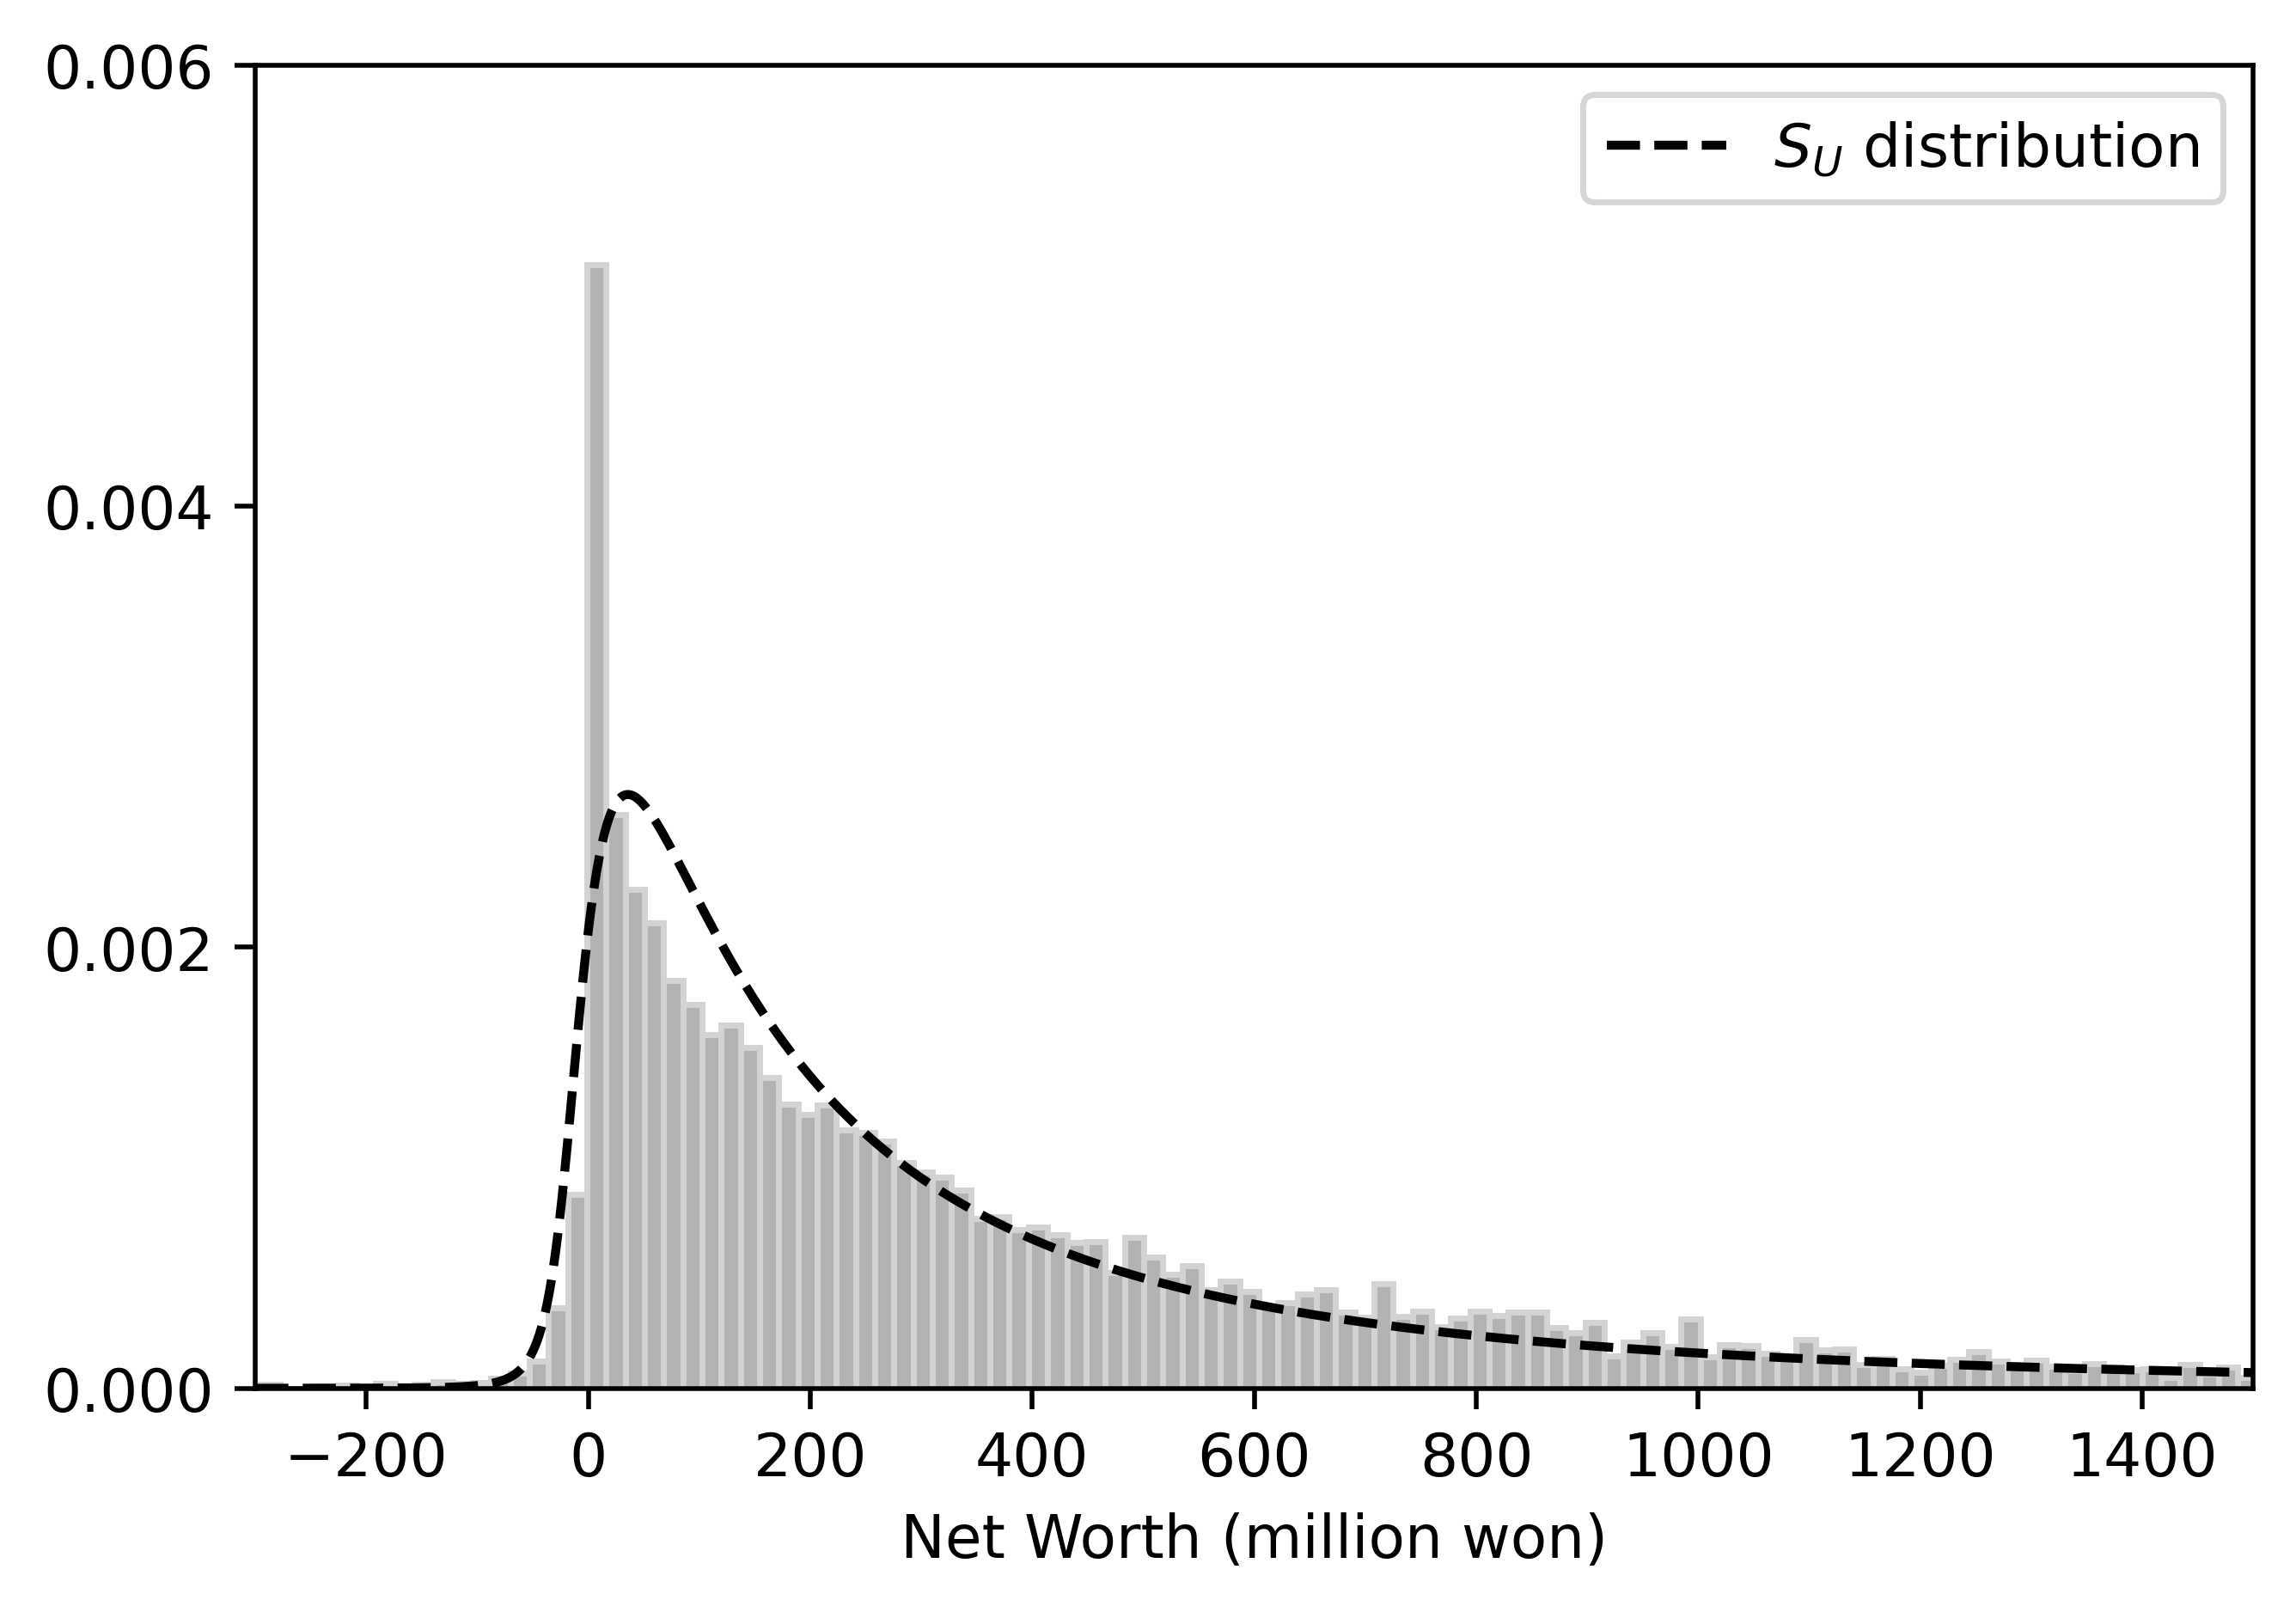

In [148]:
# 새로운 그림을 생성하고 해상도를 조정
plt.figure(figsize=(6, 4), dpi=500)

plt.xlabel('Net Worth (million won)')

# Plot the histogram of the data
num_bins = 1000
plt.hist(X, num_bins, weights=w, density=True, facecolor='0.7', edgecolor='lightgrey')
plt.xlim([-300, 1500])

# Plot the MLE estimated distribution
dist_X = np.linspace(-300, 1500, 1000)
plt.plot(dist_X, SU_pdf(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=1.5, linestyle='dashed', color='k', label='$S_U$ distribution')
plt.legend(loc='upper right')

# 세로축 눈금을 설정
plt.yticks([0.000, 0.002, 0.004, 0.006])

# 그래프 표시
plt.show()

### 로렌츠 곡선 및 지니계수

#### 단순 계산

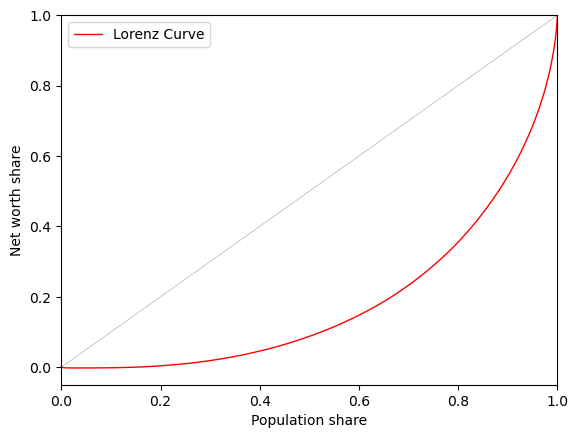

단순 Gini Coefficient: 0.6309


In [149]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 정렬
sorted_X = np.sort(X)

# Lorenz 곡선 계산
n = len(sorted_X)
cumulative_percentage = np.cumsum(sorted_X) / np.sum(sorted_X)
lorenz_curve_x = np.arange(1, n+1) / n
lorenz_curve_y = cumulative_percentage

# Lorenz 곡선 그리기
plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

# Gini 계수 계산
area_under_lorenz = np.trapz(lorenz_curve_y, lorenz_curve_x)
area_under_equality = 0.5  # 0에서 1 사이의 대각선 선분 아래 영역
gini_coefficient = (area_under_equality - area_under_lorenz) / area_under_equality
print(f'단순 Gini Coefficient: {gini_coefficient:.4f}')

#### 가중치 사용

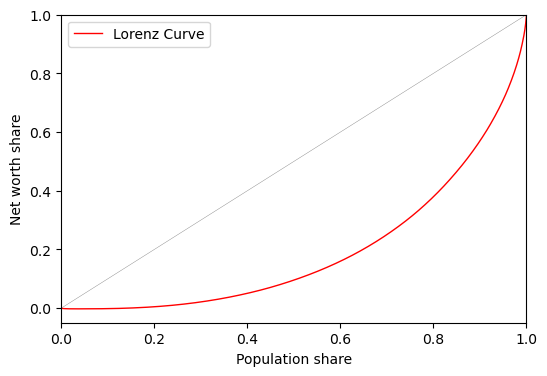

가중 Gini Coefficient: 0.6099


In [150]:
plt.figure(figsize=(6, 4))

# 데이터를 값 순서대로 정렬
sorted_data = np.asarray([X, w]).T[np.argsort(X)]
sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
# 총 가중치 및 가중치가 적용된 누적 소득 계산
total_weight = np.sum(sorted_w)
sorted_w = sorted_w / total_weight
cumulative_w = np.cumsum(sorted_w)
    
# 가중치가 적용된 누적 소득 비율 계산
total_x = np.sum(sorted_x * sorted_w)
weighted_cumulative_percentage = np.cumsum(sorted_x * sorted_w) / total_x

lorenz_curve_x = cumulative_w
lorenz_curve_y = weighted_cumulative_percentage

plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

# Gini 계수 계산
area_under_lorenz = np.trapz(lorenz_curve_y, lorenz_curve_x)
area_under_equality = 0.5  # 0에서 1 사이의 대각선 선분 아래 영역
gini_coefficient = (area_under_equality - area_under_lorenz) / area_under_equality
print(f'가중 Gini Coefficient: {gini_coefficient:.4f}')

#### Parametric Estimation 결과

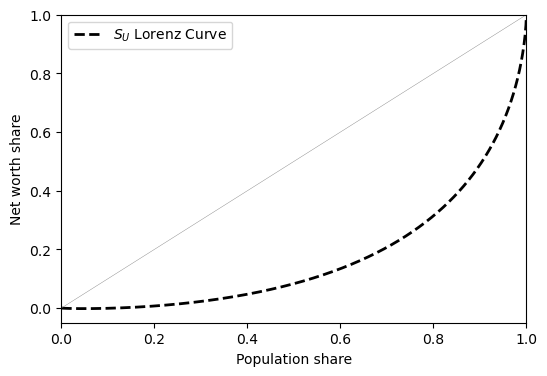

In [151]:
plt.figure(figsize=(6, 4))

dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_SU(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=2, linestyle='dashed', color='k', label='$S_U$ Lorenz Curve')

plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

#### 지니계수 계산(수치 적분)

In [152]:
from scipy.integrate import quad

res, err = quad(Lorenz_SU, 0, 1, args=(m_MLE, s_MLE, lambda_MLE, theta_MLE))
1-2*res

0.6603369433007258

#### 결과 비교 그림

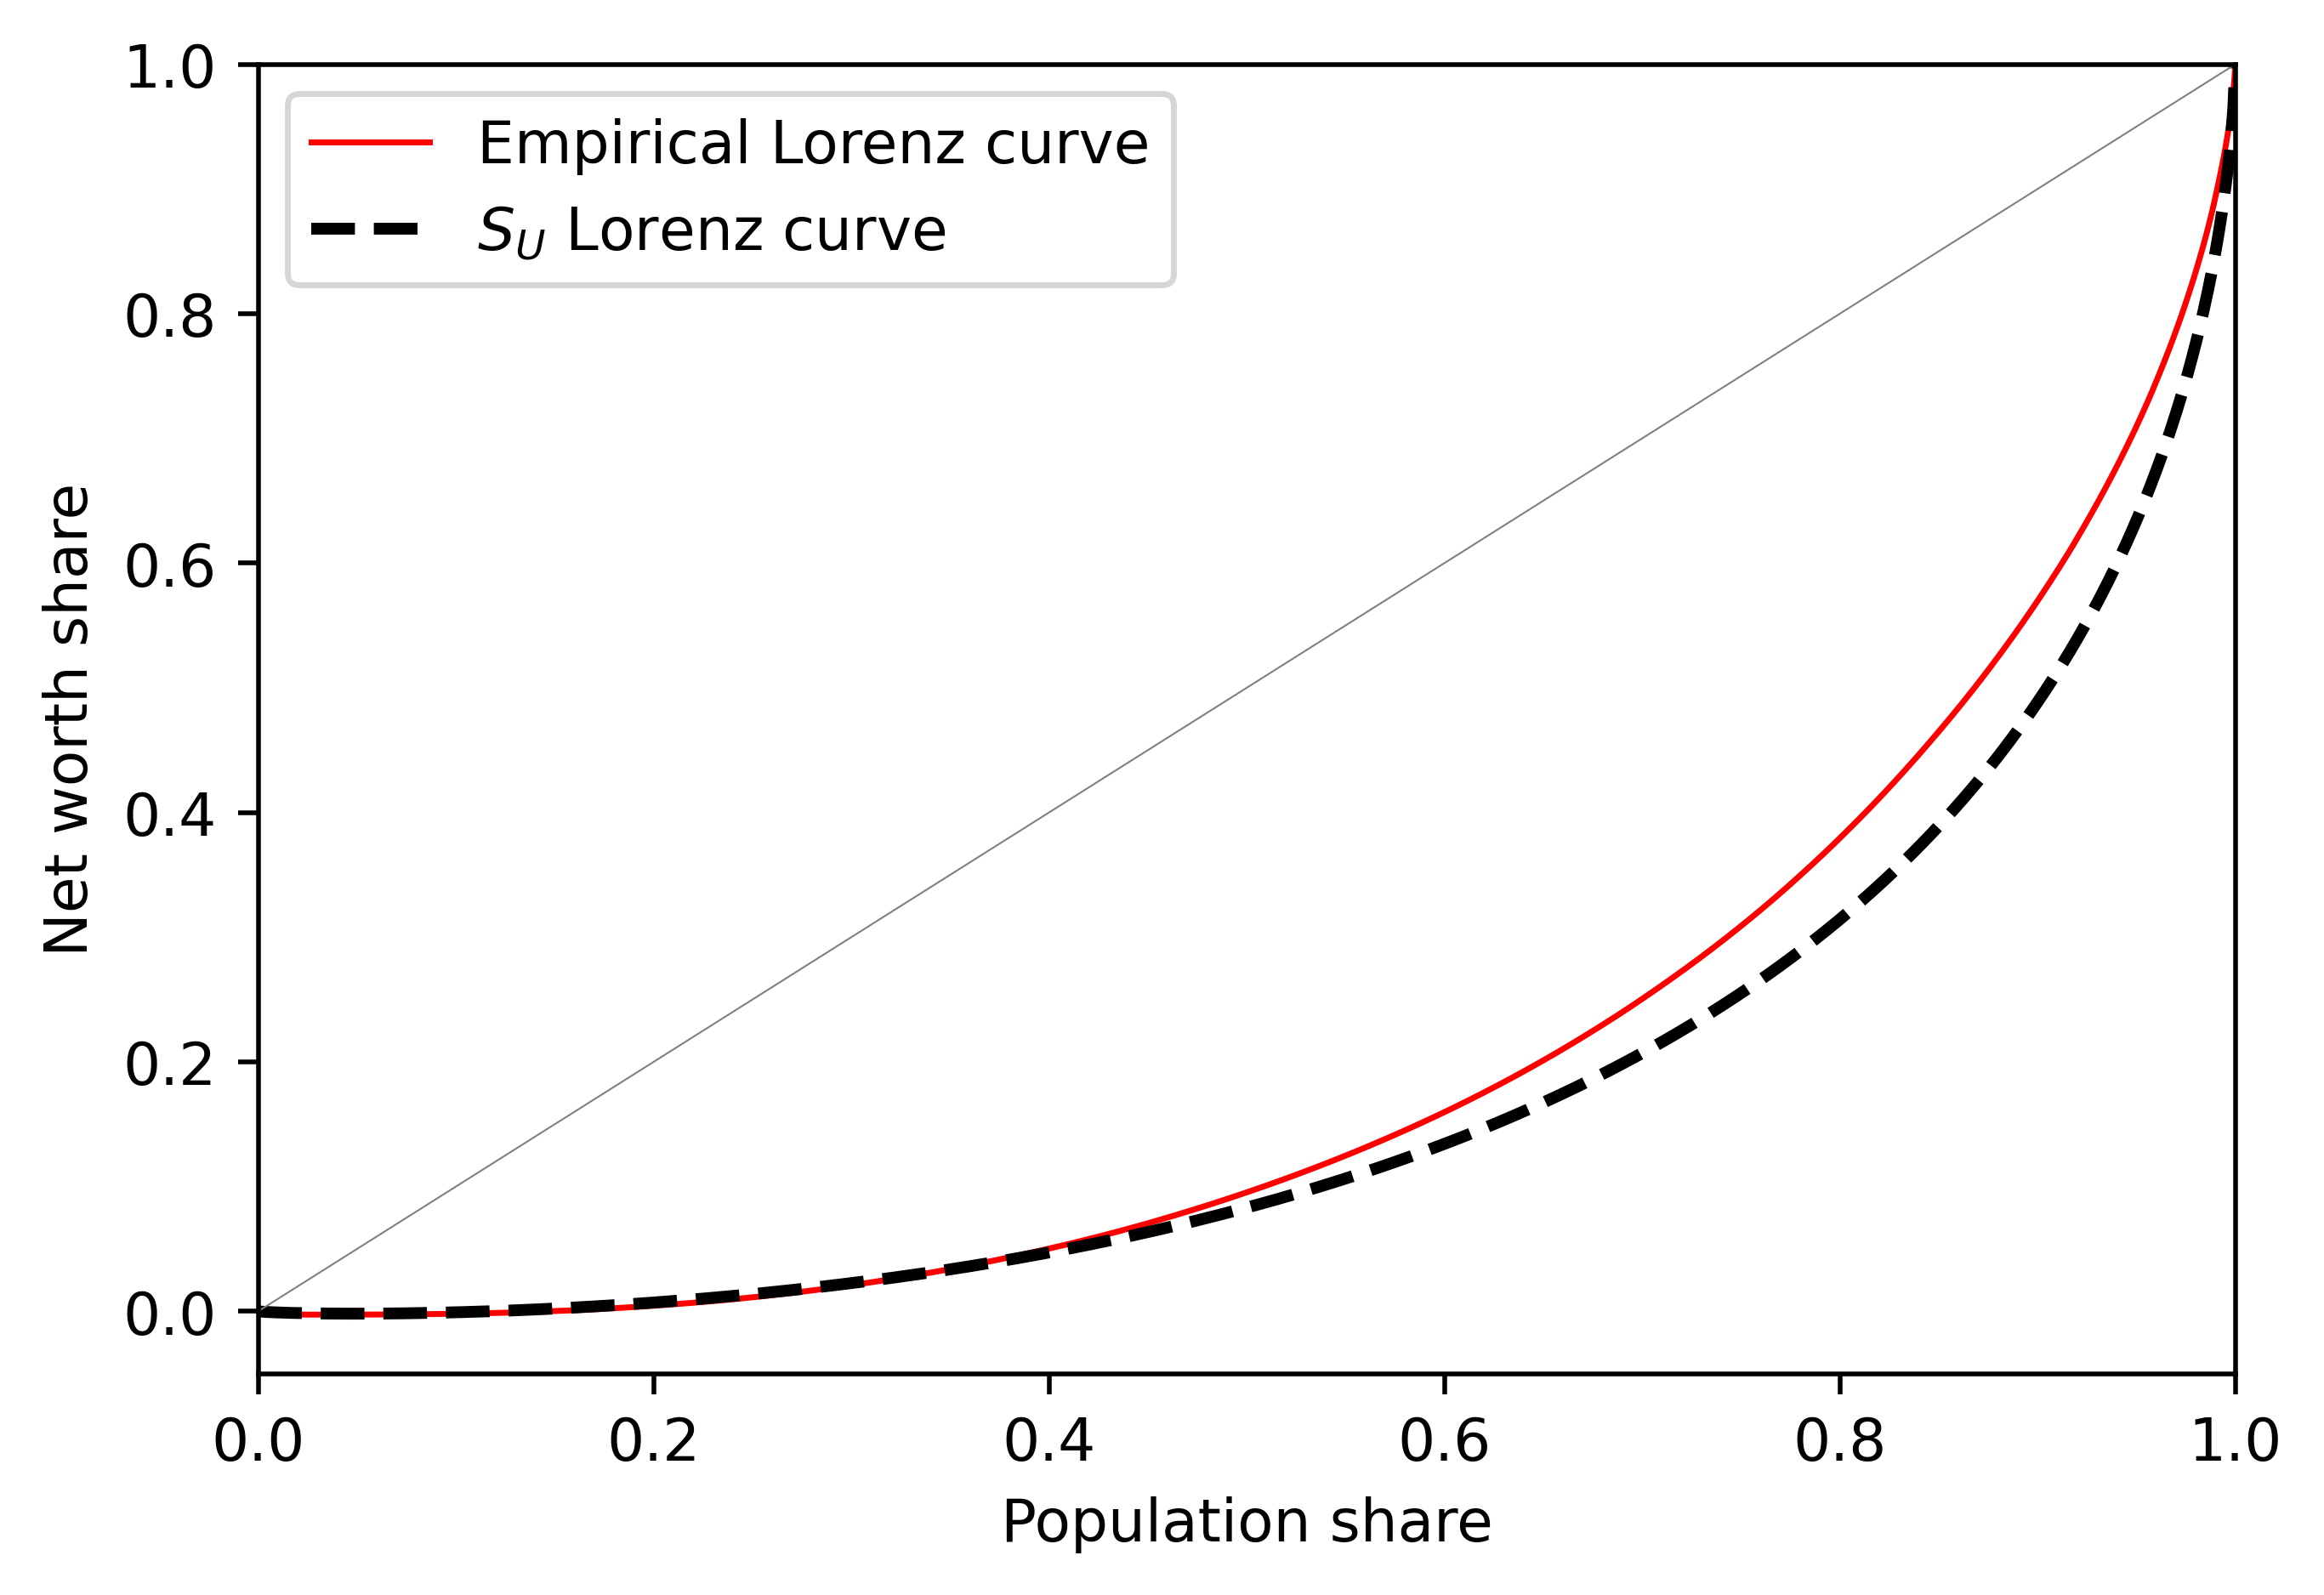

In [153]:
# 새로운 그림을 생성하고 해상도를 조정합니다.
plt.figure(figsize=(6, 4), dpi=500)

# Empirical Lorenz 곡선
sorted_data = np.asarray([X, w]).T[np.argsort(X)]
sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
total_weight = np.sum(sorted_w)
sorted_w = sorted_w / total_weight
cumulative_w = np.cumsum(sorted_w)
    
total_x = np.sum(sorted_x * sorted_w)
weighted_cumulative_percentage = np.cumsum(sorted_x * sorted_w) / total_x

lorenz_curve_x = cumulative_w
lorenz_curve_y = weighted_cumulative_percentage

plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Empirical Lorenz curve')

# SU Lorenz 곡선
dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_SU(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=2, linestyle='dashed', color='k', label='$S_U$ Lorenz curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)

plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

### 4.2 Net Income in 2022

In [154]:
X = df_2022["처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]"]/100 # 단위: 백만원 
w = df_2022["가중값"]/(df_2022["가중값"].sum())
X.describe().apply(lambda x: '%.2f' % x)

count    17954.00
mean        47.65
std         44.36
min        -93.64
25%         18.78
50%         36.64
75%         63.75
max       1216.73
Name: 처분가능소득(보완)[경상소득(보완)-비소비지출(보완)], dtype: object

In [155]:
print("Weighted Mean:", weighted_mean(X, w))
print("Weighted S.D.:", weighted_std(X, w))
print("Weighted Skewness:", weighted_skewness(X, w))
print("Weighted Kurtosis:", weighted_kurtosis(X, w))

Weighted Mean: 52.29083378828895
Weighted S.D.: 44.70681455474308
Weighted Skewness: 3.501341434163321
Weighted Kurtosis: 38.8266606836262


#### 가중 지니계수

In [156]:
print('가중 gini_2022:', weighted_gini(X, w))

가중 gini_2022: 0.4124088425659203


### 단순 히스토그램

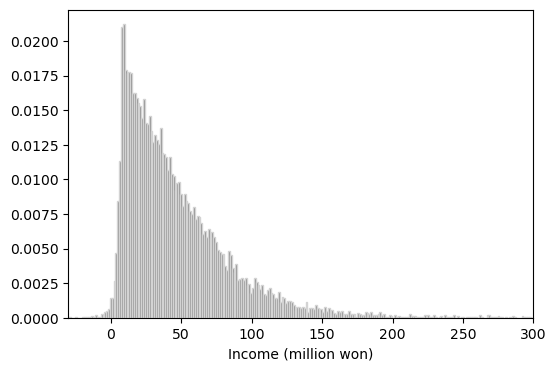

In [157]:
# 히스토그램을 생성
plt.figure(figsize=(6, 4))

plt.xlabel('Income (million won)')
num_bins = 1000
plt.hist(X, num_bins, density=True, facecolor='0.5', edgecolor='lightgrey')
plt.xlim([-30, 300])
plt.show()

### 가중 히스토그램

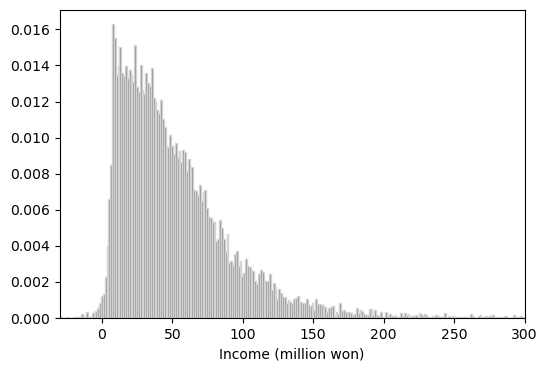

In [158]:
# 히스토그램을 생성
plt.figure(figsize=(6, 4))

plt.xlabel('Income (million won)')
num_bins = 1000
plt.hist(X, num_bins, weights=w, density=True,facecolor='0.5', edgecolor='lightgrey')
plt.xlim([-30, 300])
plt.show()

### SU 분포 Weighted MLE 

$$\text{argmax} \sum_i w_i \log L(m,s,\lambda, \theta \mid x_i)$$

#### 파라미터 제약조건을 옵션(`bounds`)으로 제공하는 방식

In [159]:
m_init = 0
s_init = 1
lambda_init = 0
theta_init = 1

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(weight_obj_SU, params_init, args=(X, w),
                      method='L-BFGS-B', 
                      bounds=((None, None),(1e-10, None),(None, None),(1e-10, None)))
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE)
print("Objective function value at solution:", res_SU.fun)

m_MLE = -2.3083894584347604 s_MLE = 13.531063728304655 lambda_MLE = 1.8682819361455527 theta_MLE = 0.7091116114471244
Objective function value at solution: 4.912987729346482


#### 양의 값을 갖는 파라미터에 exp를 취하는 방식

In [160]:
m_init = 0
s_init = 0
lambda_init = 0
theta_init = 0

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(weight_obj_SU_e, params_init, args=(X, w),
                      method='L-BFGS-B')
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

s_MLE = np.exp(s_MLE)
theta_MLE = np.exp(theta_MLE)

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE)
print("Objective function value at solution:", res_SU.fun)

m_MLE = -2.3075202838930453 s_MLE = 13.529779417976265 lambda_MLE = 1.8683374940214135 theta_MLE = 0.7091350251801108
Objective function value at solution: 4.912987729003346


#### 자코비안 행렬 제공

In [161]:
from numpy import arcsinh as asinh
from numpy import sqrt as sqrt

m_init = 0
s_init = 0
lambda_init = 0
theta_init = 0
# NOTE: 자코비안 함수를 제공하는 경우 오히려 초기값의 영향을 더 많이 받는듯 함. 
# 가령 모든 초기값을 0으로 할 경우 최적화가 되지 않음.

# 그래디언트 함수
def grad_logL(params, *args):
    m, s, lambda_, theta = params
    (x, w) = args
    
    s = np.exp(s)
    theta = np.exp(theta)
    
    ll_m = np.sum(w*(
        (-m + x)/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))/(s*theta**2*sqrt(1 + (-m + x)**2/s**2))
    ))
    ll_s = np.sum(w*(s*(
        -s/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_l = np.sum(w*(
        -(2*lambda_ - 2*asinh((-m + x)/s))/(2*theta**2)
    ))
    ll_t = np.sum(w*(theta*(
        -1/theta + (-lambda_ + asinh((-m + x)/s))**2/theta**3
    )))
    
    return -np.array([ll_m, ll_s, ll_l, ll_t])

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(weight_obj_SU_e, params_init, args=(X, w), tol=1e-100,
                      method='Newton-CG', options={'maxiter': 100000},
                      jac=grad_logL)
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

s_MLE = np.exp(s_MLE)
theta_MLE = np.exp(theta_MLE)

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE)
print("Objective function value at solution:", res_SU.fun)

m_MLE = -2.3076475562775673 s_MLE = 13.529744634819595 lambda_MLE = 1.8683453653481399 theta_MLE = 0.7091325752416763
Objective function value at solution: 4.912987728995086


#### 자코비안 & 헤시안 행렬 제공

아래에서 보듯이 `opt.minimize`에 `tol=1e-100` or/and `options={'maxiter': 100000}` 옵션을 부과해야 비슷한 로그가능도 값에 도달함. 그렇지 않으면 (마이너스) 로그가능도 값이 더 높음.

In [162]:
import time
start_time = time.time()

from numpy import arcsinh as asinh
from numpy import sqrt as sqrt

m_init = 0
s_init = 0
lambda_init = 0
theta_init = 0

# 그래디언트 함수
def grad_logL(params, *args):
    m, s, lambda_, theta = params
    (x, w) = args
    
    s = np.exp(s)
    theta = np.exp(theta)
    
    ll_m = np.sum(w*(
        (-m + x)/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))/(s*theta**2*sqrt(1 + (-m + x)**2/s**2))
    ))
    ll_s = np.sum(w*(s*(
        -s/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_l = np.sum(w*(
        -(2*lambda_ - 2*asinh((-m + x)/s))/(2*theta**2)
    ))
    ll_t = np.sum(w*(theta*(
        -1/theta + (-lambda_ + asinh((-m + x)/s))**2/theta**3
    )))
    
    return -np.array([ll_m, ll_s, ll_l, ll_t])

# 헤시안 계산 함수
def hess_logL(params, *args):
    m, s, lambda_, theta = params    
    (x, w) = args
    
    s = np.exp(s)
    theta = np.exp(theta)

    ll_s = np.sum(w*(s*(
        -s/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_t = np.sum(w*(theta*(
        -1/theta + (-lambda_ + asinh((-m + x)/s))**2/theta**3
    )))

    ll_mm = np.sum(w*(
        (-2*m + 2*x)*(-m + x)/(s**2 + (-m + x)**2)**2 - 1/(s**2 + (-m + x)**2) - 1/(s**2*theta**2*(1 + (-m + x)**2/s**2)) - (-lambda_ + asinh((-m + x)/s))*(2*m - 2*x)/(2*s**3*theta**2*(1 + (-m + x)**2/s**2)**(3/2))
    ))
    ll_sm = np.sum(w*(s*(
        -2*s*(-m + x)/(s**2 + (-m + x)**2)**2 - (-lambda_ + asinh((-m + x)/s))/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2)) - (-m + x)/(s**3*theta**2*(1 + (-m + x)**2/s**2)) + (-lambda_ + asinh((-m + x)/s))*(-m + x)**2/(s**4*theta**2*(1 + (-m + x)**2/s**2)**(3/2))
    )))
    ll_lm = np.sum(w*(
        -1/(s*theta**2*sqrt(1 + (-m + x)**2/s**2))
    ))
    ll_tm = np.sum(w*(theta*(
        -2*(-lambda_ + asinh((-m + x)/s))/(s*theta**3*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_ms = ll_sm
    ll_ss = np.sum(w*(s**2*(
        2*s**2/(s**2 + (-m + x)**2)**2 - 1/(s**2 + (-m + x)**2) - 2*(-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**3*theta**2*sqrt(1 + (-m + x)**2/s**2)) - (-m + x)**2/(s**4*theta**2*(1 + (-m + x)**2/s**2)) + (-lambda_ + asinh((-m + x)/s))*(-m + x)**3/(s**5*theta**2*(1 + (-m + x)**2/s**2)**(3/2))
    ))) + ll_s
    ll_ls = np.sum(w*(
        -(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))
    ))
    ll_ts = np.sum(w*(theta*(
        -2*(-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**3*sqrt(1 + (-m + x)**2/s**2))
    )))
    ll_ml = ll_lm
    ll_sl = ll_ls
    ll_ll = np.sum(w*(
        -1/theta**2
    ))
    ll_tl = np.sum(w*(theta*(
        (2*lambda_ - 2*asinh((-m + x)/s))/theta**3
    )))
    ll_mt = ll_tm
    ll_st = ll_ts
    ll_lt = ll_tl
    ll_tt = np.sum(w*(theta**2*(
        theta**(-2) - 3*(-lambda_ + asinh((-m + x)/s))**2/theta**4
    ))) 

    hess_matrix = np.array([
        [ll_mm, ll_ms, ll_ml, ll_mt],
        [ll_sm, ll_ss, ll_sl, ll_st],
        [ll_lm, ll_ls, ll_ll, ll_lt],
        [ll_tm, ll_ts, ll_tl, ll_tt]
    ]) + ll_t
    return -hess_matrix

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(weight_obj_SU_e, params_init, args=(X, w), tol=1e-100,
                      method='Newton-CG', options={'maxiter': 100000},
                      jac=grad_logL,  # 그래디언트 함수 지정
                      hess=hess_logL)  # 헤시안 함수 지정
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

s_MLE = np.exp(s_MLE)
theta_MLE = np.exp(theta_MLE)

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE)
print("Objective function value at solution:", res_SU.fun)

end_time = time.time()
execution_time = end_time - start_time
print("\nExecution time:", execution_time, "seconds")

m_MLE = -2.307120499648615 s_MLE = 13.529805372802468 lambda_MLE = 1.86832760412047 theta_MLE = 0.7091400333029102
Objective function value at solution: 4.9129877290210935

Execution time: 73.71958494186401 seconds


In [163]:
res_SU

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 4.9129877290210935
       x: [-2.307e+00  2.605e+00  1.868e+00 -3.437e-01]
     nit: 680
     jac: [ 9.654e-08  3.845e-09 -1.641e-09  2.213e-09]
    nfev: 849
    njev: 849
    nhev: 680

#### 헤시안 행렬을 통해 분산-공분산 행렬을 계산하는 방법:

- 최적화 과정에서 얻은 헤시안 행렬의 역행렬을 구한다. 이 역행렬은 파라미터의 분산-공분산 행렬 추정치이다.
- 이 행렬의 대각원소를 추출하여 각각의 제곱근을 구한다. 이 값들이 각 파라미터의 표준오차이다.

In [164]:
from scipy.stats import norm

# 최적화 결과에서 헤시안 행렬을 사용하여 분산-공분산 행렬 계산
cov_matrix = np.linalg.inv(hess_logL(res_SU.x, X, w))

# 각 파라미터의 표준오차 계산
std_errors = np.sqrt(np.diag(cov_matrix))
print("\nStandard errors:", std_errors)

# 각 파라미터의 추정치 (최적화 결과)
params_estimated = np.array([m_MLE, s_MLE, lambda_MLE, theta_MLE])

# t-통계량 계산: 파라미터 추정치 / 파라미터의 표준오차
t_stats = params_estimated / std_errors

# t-통계량 출력
print("\nt-Statistics:", t_stats)

# t-통계량에 대한 p값 계산
p_values = 2 * (1 - norm.cdf(np.abs(t_stats)))

# p값 출력
print("\np-values:", p_values)

# 유의수준
alpha = 0.05

# 자유도를 고려한 t 분포의 임계값 (예: 무한대로 가정할 경우 z-점수 사용)
critical_value = 1.96  # 정규분포를 사용한 근사치

# 통계적 유의성 테스트 결과 출력
print("\nStatistically significant at 5% level:")
print(np.abs(t_stats) > critical_value)

np.diag(cov_matrix)


Standard errors: [nan nan nan nan]

t-Statistics: [nan nan nan nan]

p-values: [nan nan nan nan]

Statistically significant at 5% level:
[False False False False]


C:\Users\pilsu\AppData\Local\Temp\ipykernel_26516\4048467707.py:7: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(np.diag(cov_matrix))


array([-1.74957948e+03, -1.89846078e-01, -5.60305097e-01, -3.20749136e-01])

### 평균 표준편차 왜도 첨도

In [165]:
print("Weighted Mean:", weighted_mean(X, w))
print("Weighted S.D.:", weighted_std(X, w))
print("Weighted Skewness:", weighted_skewness(X, w))
print("Weighted Kurtosis:", weighted_kurtosis(X, w))

Weighted Mean: 52.29083378828895
Weighted S.D.: 44.70681455474308
Weighted Skewness: 3.501341434163321
Weighted Kurtosis: 38.8266606836262


In [166]:
print("Mean:", SU_mean(m_MLE, s_MLE, lambda_MLE, theta_MLE))
print("S.D.:", SU_var(m_MLE, s_MLE, lambda_MLE, theta_MLE)**0.5)
print("Skewness:", SU_skew(m_MLE, s_MLE, lambda_MLE, theta_MLE))
print("Kurtosis:", SU_kurt(m_MLE, s_MLE, lambda_MLE, theta_MLE))

Mean: 52.696167653378325
S.D.: 46.213721979499134
Skewness: 2.860421984874809
Kurtosis: 20.829021328081772


### 히스토그램 vs. 추정 PDF

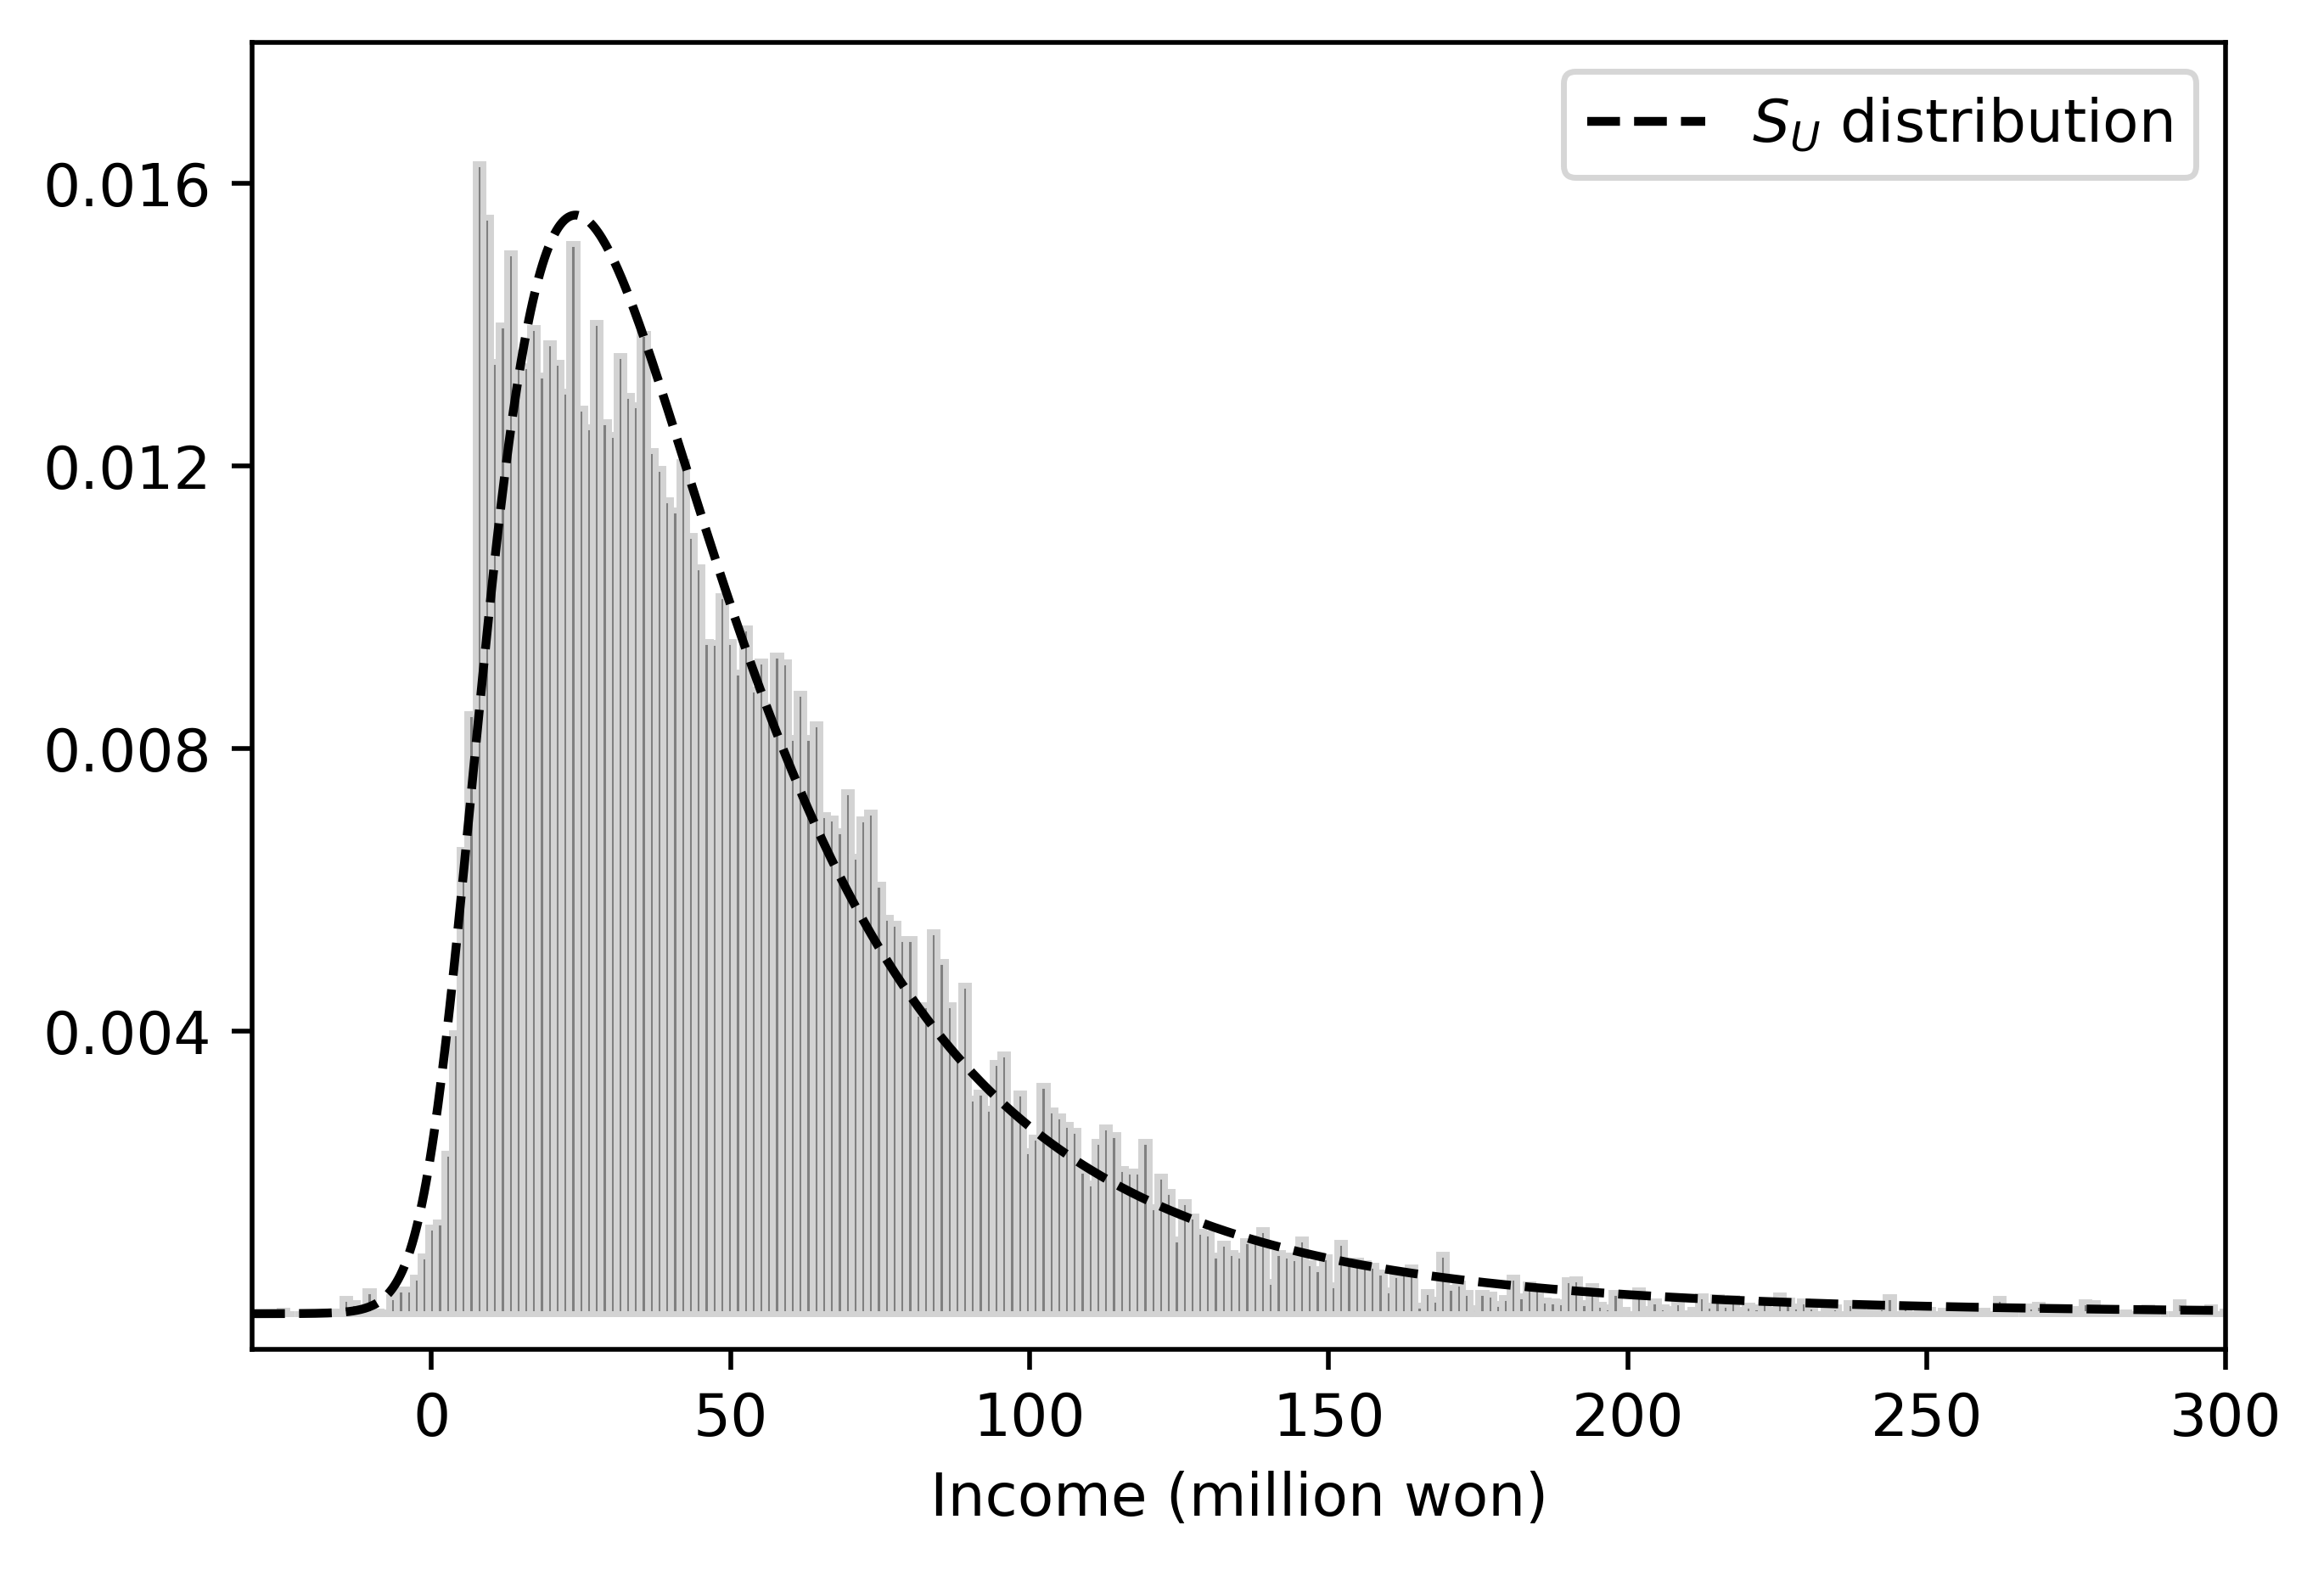

In [167]:
# 새로운 그림을 생성하고 해상도를 조정
plt.figure(figsize=(6, 4), dpi=500)

plt.xlabel('Income (million won)')

# Plot the histogram of the data
num_bins = 1000
plt.hist(X, num_bins, weights=w, density=True, facecolor='0.5', edgecolor='lightgrey')
plt.xlim([-30, 300])
plt.ylim(-0.0005, 0.018)

# Plot the MLE estimated distribution
dist_X = np.linspace(-30, 300, 1000)
plt.plot(dist_X, SU_pdf(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=1.5, linestyle='dashed', color='k', label='$S_U$ distribution')
plt.legend(loc='upper right')

# 세로축 눈금을 설정
plt.yticks([0.004, 0.008, 0.012, 0.016])

# 그래프 표시
plt.show()

### 로렌츠 곡선 및 지니계수

#### 단순 계산

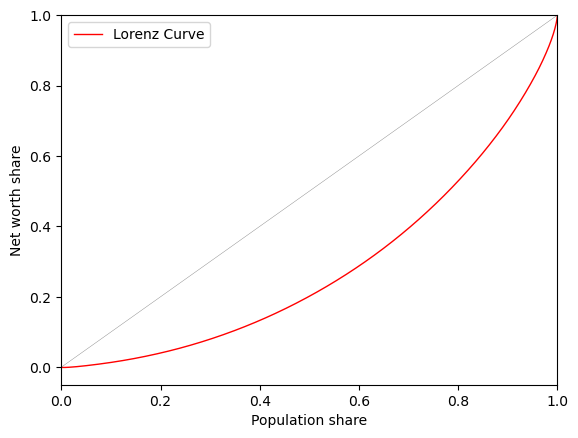

단순 Gini Coefficient: 0.4329


In [168]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 정렬
sorted_X = np.sort(X)

# Lorenz 곡선 계산
n = len(sorted_X)
cumulative_percentage = np.cumsum(sorted_X) / np.sum(sorted_X)
lorenz_curve_x = np.arange(1, n+1) / n
lorenz_curve_y = cumulative_percentage

# Lorenz 곡선 그리기
plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

# Gini 계수 계산
area_under_lorenz = np.trapz(lorenz_curve_y, lorenz_curve_x)
area_under_equality = 0.5  # 0에서 1 사이의 대각선 선분 아래 영역
gini_coefficient = (area_under_equality - area_under_lorenz) / area_under_equality
print(f'단순 Gini Coefficient: {gini_coefficient:.4f}')

#### 가중치 사용

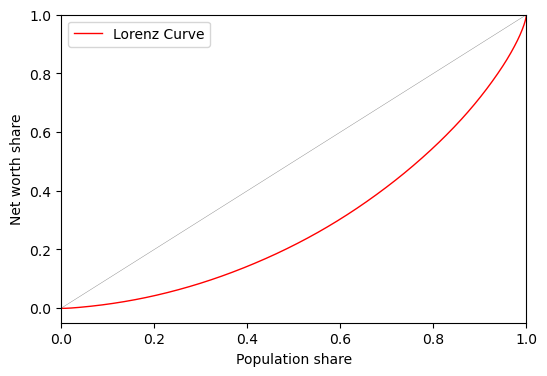

가중 Gini Coefficient: 0.4124


In [169]:
plt.figure(figsize=(6, 4))

# 데이터를 값 순서대로 정렬
sorted_data = np.asarray([X, w]).T[np.argsort(X)]
sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
# 총 가중치 및 가중치가 적용된 누적 소득 계산
total_weight = np.sum(sorted_w)
sorted_w = sorted_w / total_weight
cumulative_w = np.cumsum(sorted_w)
    
# 가중치가 적용된 누적 소득 비율 계산
total_x = np.sum(sorted_x * sorted_w)
weighted_cumulative_percentage = np.cumsum(sorted_x * sorted_w) / total_x

lorenz_curve_x = cumulative_w
lorenz_curve_y = weighted_cumulative_percentage

plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Net worth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

# Gini 계수 계산
area_under_lorenz = np.trapz(lorenz_curve_y, lorenz_curve_x)
area_under_equality = 0.5  # 0에서 1 사이의 대각선 선분 아래 영역
gini_coefficient = (area_under_equality - area_under_lorenz) / area_under_equality
print(f'가중 Gini Coefficient: {gini_coefficient:.4f}')

#### Parametric Estimation 결과

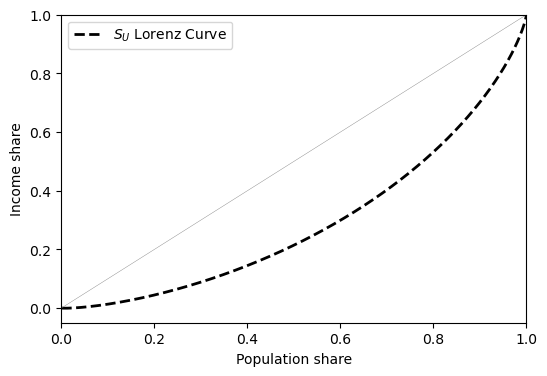

In [170]:
plt.figure(figsize=(6, 4))

dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_SU(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=2, linestyle='dashed', color='k', label='$S_U$ Lorenz Curve')

plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)
plt.xlabel('Population share')
plt.ylabel('Income share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

#### 지니계수 계산(수치 적분)

In [171]:
from scipy.integrate import quad

res, err = quad(Lorenz_SU, 0, 1, args=(m_MLE, s_MLE, lambda_MLE, theta_MLE))
1-2*res

0.42031518578168336

#### 결과 비교 그림

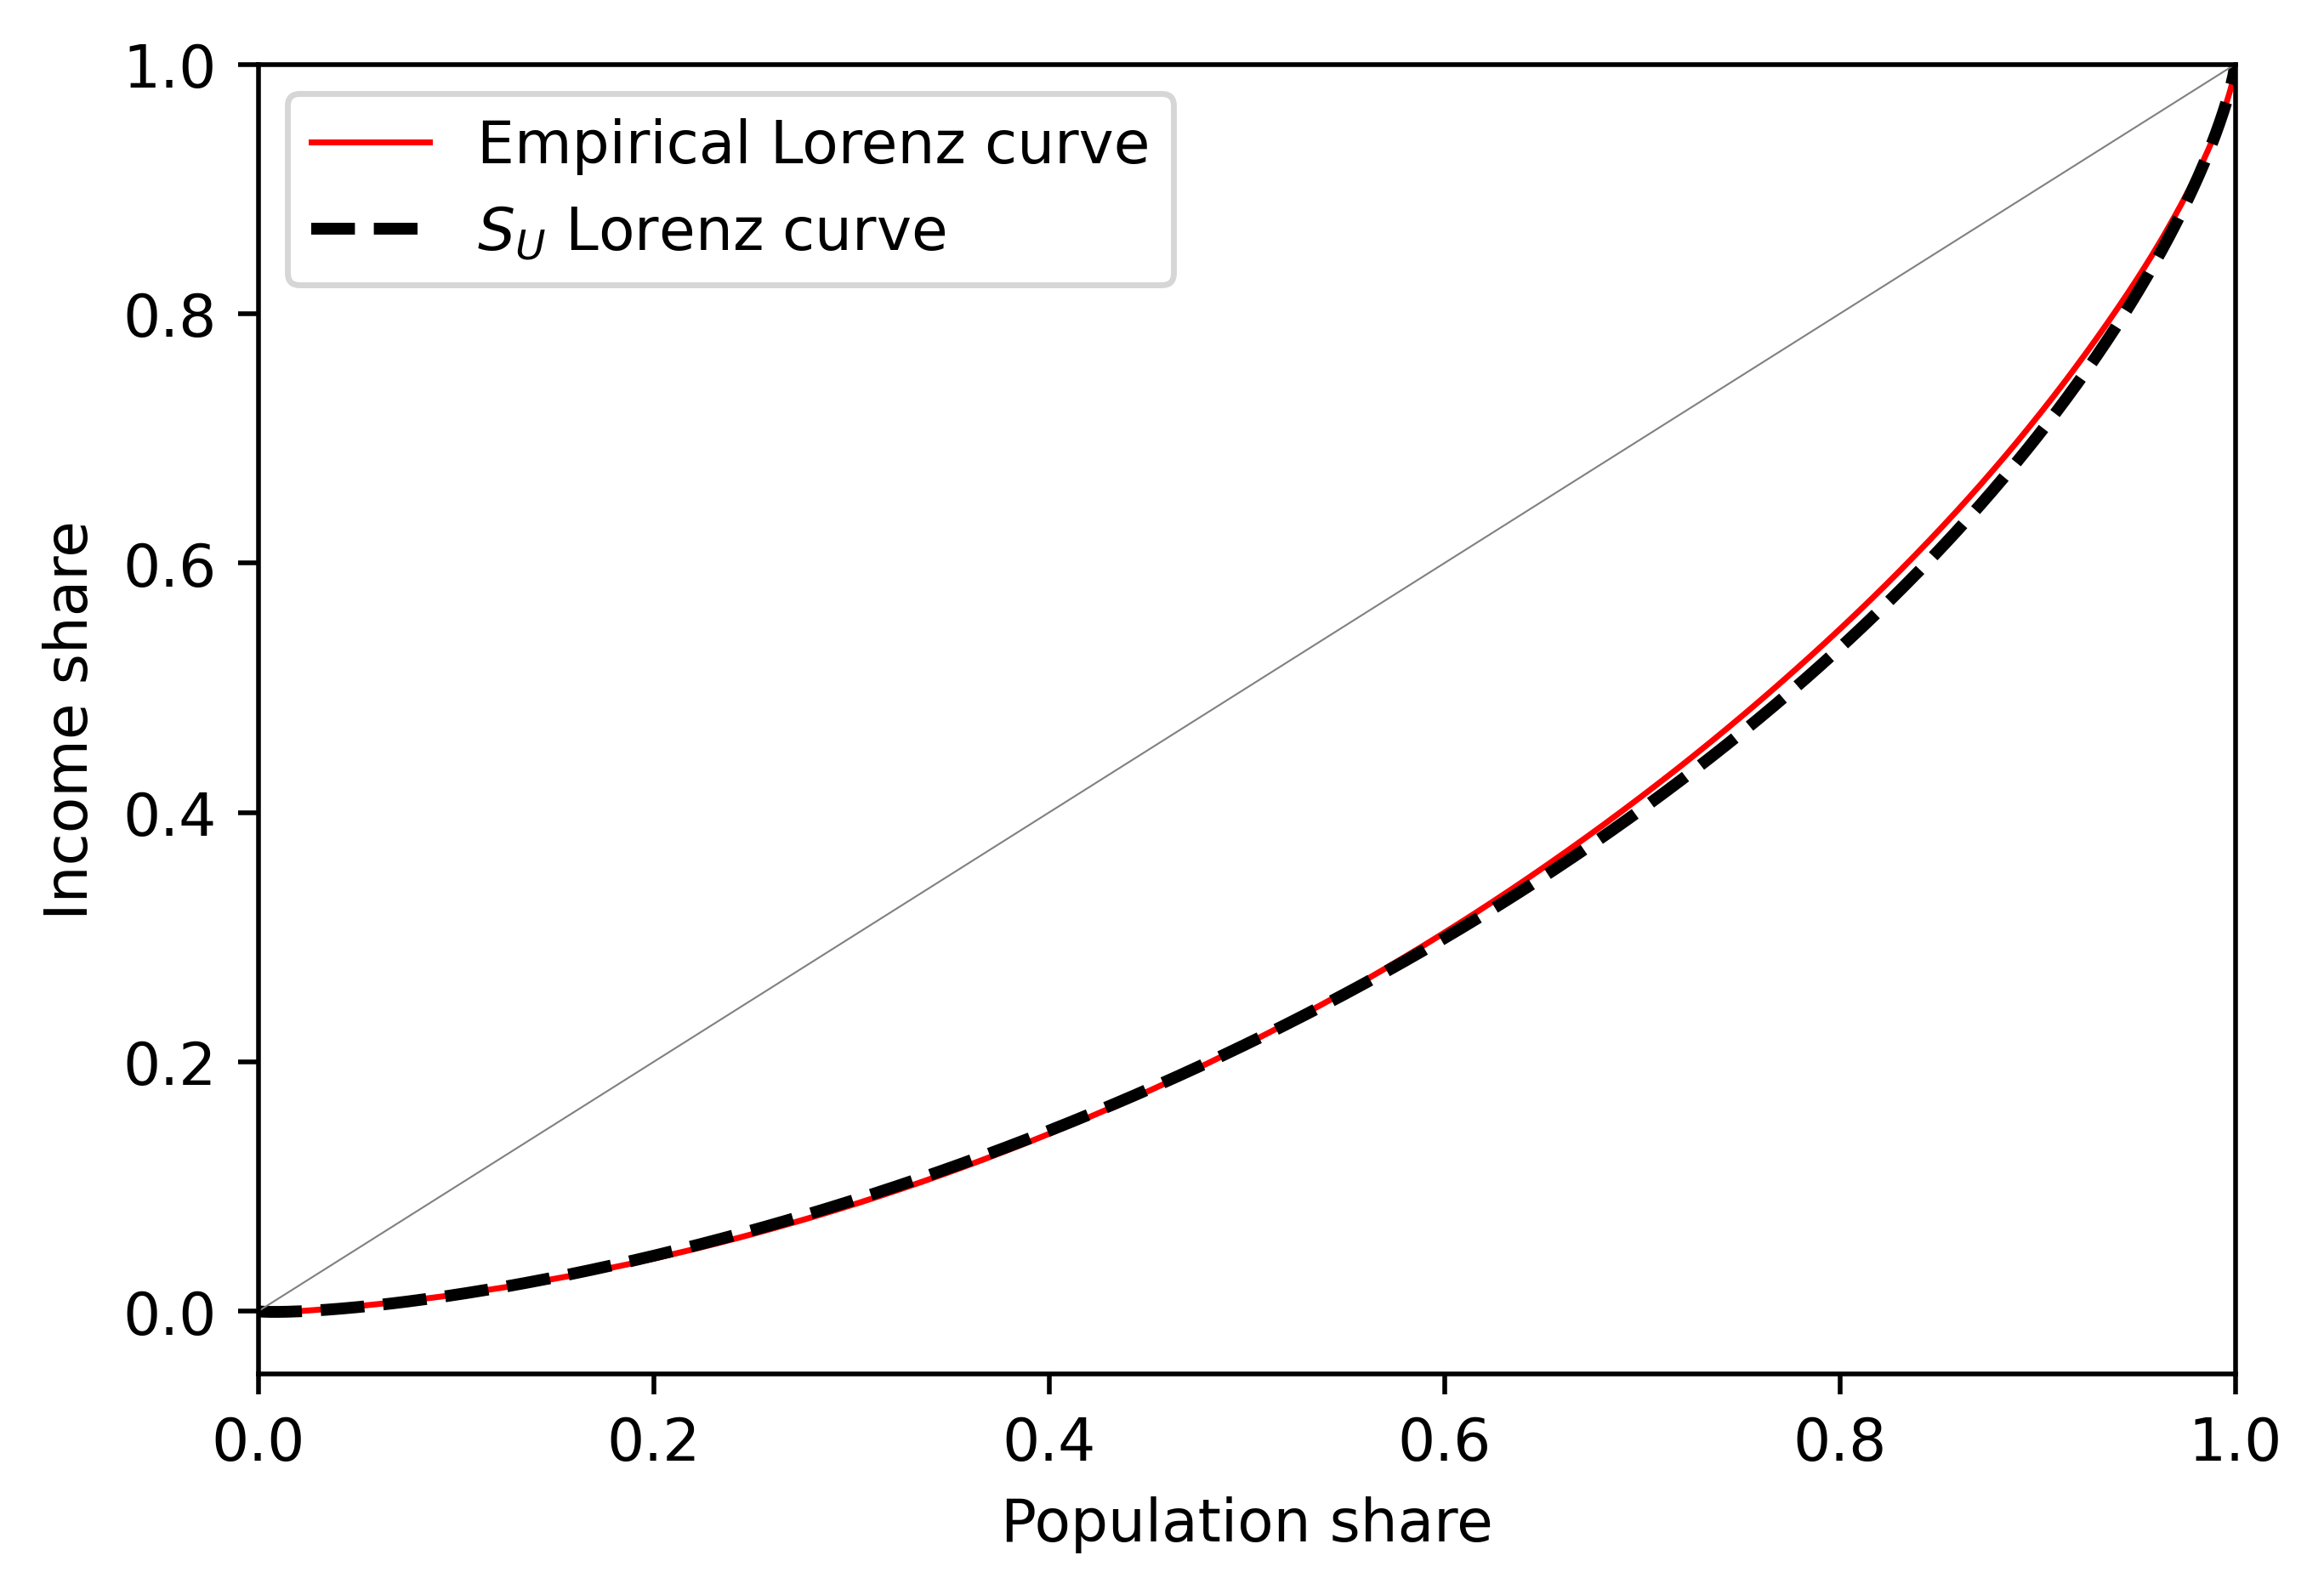

In [172]:
# 새로운 그림을 생성하고 해상도를 조정합니다.
plt.figure(figsize=(6, 4), dpi=500)

# Empirical Lorenz 곡선
sorted_data = np.asarray([X, w]).T[np.argsort(X)]
sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
total_weight = np.sum(sorted_w)
sorted_w = sorted_w / total_weight
cumulative_w = np.cumsum(sorted_w)
    
total_x = np.sum(sorted_x * sorted_w)
weighted_cumulative_percentage = np.cumsum(sorted_x * sorted_w) / total_x

lorenz_curve_x = cumulative_w
lorenz_curve_y = weighted_cumulative_percentage

plt.plot(lorenz_curve_x, lorenz_curve_y, 
         linewidth=1, color='r', label='Empirical Lorenz curve')

# SU Lorenz 곡선
dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_SU(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=2, linestyle='dashed', color='k', label='$S_U$ Lorenz curve')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)

plt.xlabel('Population share')
plt.ylabel('Income share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

## 참고 1: scipy opt.minimize 사용법

### 파이썬에서 최대화(최소화) 문제를 설정하는 방법

모든 최대화 문제는 최소화 문제로 다시 설정될 수 있다. 최소화 문제는 수치적으로 더 안정적이고 잘 정의되어 있기 때문에 대부분의 수치 최적화(numerical optimizer) 프로그램은 최소화 프로그램으로 설정된다. [scipy.optimize](https://docs.scipy.org/doc/scipy-0.18.1/reference/optimize.html) 라이브러리에는 다양한 유형의 최소화 도구가 있다. 최대가능도 추정 문제의 경우, [scipy.optimize.minimize()](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) 함수를 사용한다.

#### `minimize()`

`scipy.optimize.minimize()`의 줄임말이다. `minimize()` 함수에는 3개의 필수 인수와 많은 옵션이 있다. 필수 인수는 다음과 같다.

1. `fun`: `minimize()`의 첫 번째 인수는 목적함수로서 `minimize()`는 목적함수를 최소화시키는 파라미터 값을 찾는다.
2. `x0`: 두 번째 인수는 파라미터 값에 대한 초기값이다.
3. `args=()`: 세 번째 인수는 목적함수를 계산하는 데 필요한 모든 객체 튜플이다.

#### 목적함수(objective function)

목적함수는 `objective_function(params, *args)`의 형태이다.

- `params`: 첫 번째 파라미터는 스칼라 또는 값의 벡터이다. 이것은 목적함수를 최소화하기 위해 선택되는 값이다.

- `*args`: 두 번째 파라미터는 가변 길이(variable-length) 튜플 인수이다. 


#### minimize() 함수를 사용한 제한된 최소화

`minimize()` 함수에는 목적함수를 최소화하는 파라미터 값을 찾는 데 사용할 수 있는 많은 `method`가 있다. `method='MethodName'` 입력 인수를 사용하여 호출된다. 이들 중 일부는 선택되는 파라미터에 대해 상한 및 하한을 설정할 수 있는 제약조건 하에서의 최소화(bound-constrained minimization)를 허용한다. 이들 방법은 `Nelder-Mead`, `L-BFGS-B`, `Powell`, `TNC` 등이다.

![image-6.png](attachment:image-6.png) 

>**다음 방식의  데이터 분석 코딩 예를 하나 알려줘.**
>```python
opt.minimize(obj, params_init, method='Newton-CG', jac=grad_logL)
>```

In [173]:
import numpy as np
from scipy import optimize as opt

# 임의의 데이터 생성
np.random.seed(0)
X = np.linspace(0, 10, 1000)  # 독립 변수
y = 3*X + 2 + np.random.normal(0, 2, 1000)  # 종속 변수 (회귀선: y = 3x + 2 + 오차)

# 목적 함수: 회귀 계수에 대한 잔차 제곱 합
def obj(params):
    a, b = params
    predictions = a*X + b
    return np.sum((y - predictions)**2)

# 그래디언트(1계 도함수): 잔차에 대한 회귀 계수의 미분
def grad_logL(params):
    a, b = params
    grad_a = -2*np.sum(X*(y - (a*X + b)))  # ∂(잔차 제곱 합)/∂a
    grad_b = -2*np.sum(y - (a*X + b))      # ∂(잔차 제곱 합)/∂b
    return np.array([grad_a, grad_b])

# 초기 파라미터 값 (a와 b의 초기 추정치)
params_init = np.array([0.0, 0.0])

# 최적화 실행
result = opt.minimize(obj, params_init, method='Newton-CG', jac=grad_logL)

print("Optimization Result:")
print("Estimated coefficients:", result.x)
print("Objective function value at solution:", result.fun)

Optimization Result:
Estimated coefficients: [2.99627611 1.92810533]
Objective function value at solution: 3896.8220052775514


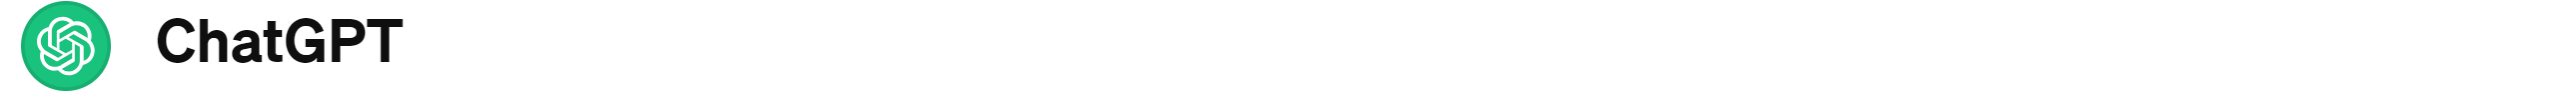 

>**알려준 코드에는 opt.minimize()에 args=(x,)이 없는데??**

제시된 코드에서 `opt.minimize()` 함수에 `args=(x,)`이 명시적으로 포함되어 있지 않은 이유는, 이 경우 목적 함수 `obj`와 그래디언트 함수 `grad_logL` 모두 글로벌 변수 `X`와 `y`를 직접 참조하기 때문입니다. 즉, `obj`와 `grad_logL` 함수는 추가적인 외부 인자를 필요로 하지 않으며, 함수 내부에서 이미 필요한 모든 데이터에 접근할 수 있습니다.

이는 특정 상황에서는 편리할 수 있으나, 일반적으로 함수가 외부의 글로벌 변수에 의존하는 것은 좋지 않은 설계 방식입니다. 함수가 외부 상태에 의존하게 되면, 함수의 재사용성이 낮아지고, 테스트하기 어려워지며, 예상치 못한 버그가 발생할 확률이 높아집니다. 함수가 필요로 하는 모든 데이터를 명시적으로 인자로 받도록 하는 것이 더 깨끗한 코드 설계를 유도합니다.

따라서, 가능하다면 `obj`와 `grad_logL` 함수가 필요로 하는 데이터를 인자로 전달받도록 수정하고, `opt.minimize` 호출 시 `args` 매개변수를 통해 필요한 데이터를 전달하는 방식이 바람직합니다. 예를 들어:

```python
import numpy as np
from scipy import optimize as opt

# 임의의 데이터 생성
X = np.linspace(0, 10, 1000)  # 독립 변수
y = 3*X + 2 + np.random.normal(0, 2, 1000)  # 종속 변수

# 목적 함수와 그래디언트 함수 수정
def obj(params, X, y):
    a, b = params
    predictions = a*X + b
    return np.sum((y - predictions)**2)

def grad_logL(params, X, y):
    a, b = params
    grad_a = -2*np.sum(X*(y - (a*X + b)))
    grad_b = -2*np.sum(y - (a*X + b))
    return np.array([grad_a, grad_b])

params_init = np.array([0.0, 0.0])

# 최적화 실행 시 args 매개변수 사용
result = opt.minimize(obj, params_init, args=(X, y), method='Newton-CG', jac=grad_logL)
```

이런 식으로 수정하면 `obj`와 `grad_logL` 함수가 필요로 하는 모든 데이터를 명시적으로 전달받으므로, 함수의 재사용성과 테스트 용이성이 향상됩니다.

In [174]:
import numpy as np
from scipy import optimize as opt

# 임의의 데이터 생성
X = np.linspace(0, 10, 1000)  # 독립 변수
y = 3*X + 2 + np.random.normal(0, 2, 1000)  # 종속 변수

# 목적 함수와 그래디언트 함수 수정
def obj(params, X, y):
    a, b = params
    predictions = a*X + b
    return np.sum((y - predictions)**2)

def grad_logL(params, X, y):
    a, b = params
    grad_a = -2*np.sum(X*(y - (a*X + b)))
    grad_b = -2*np.sum(y - (a*X + b))
    return np.array([grad_a, grad_b])

params_init = np.array([0.0, 0.0])

# 최적화 실행 시 args 매개변수 사용
result = opt.minimize(obj, params_init, args=(X, y), method='Newton-CG', jac=grad_logL)

print("Optimization Result:")
print("Estimated coefficients:", result.x)
print("Objective function value at solution:", result.fun)


Optimization Result:
Estimated coefficients: [2.98087643 2.12285172]
Objective function value at solution: 3746.28132515125


## 참고 2: SymPy SU Hessian 구하기

- [1. ∂logL / ∂m](#1.-∂logL-/-∂m)
- [2. ∂logL / ∂s](#2.-∂logL-/-∂s)
- [3. ∂logL / ∂𝜆](#3.-∂logL-/-∂𝜆)
- [4. ∂logL / ∂𝜃](#4.-∂logL-/-∂𝜃)
- [5. ∂2logL / ∂m∂m](#5.-∂2logL-/-∂m∂m)
- [6. ∂2logL / ∂s∂m](#6.-∂2logL-/-∂s∂m)
- [7. ∂2logL / ∂𝜆∂m](#7.-∂2logL-/-∂𝜆∂m)
- [8. ∂2logL / ∂𝜃∂m](#8.-∂2logL-/-∂𝜃∂m)
- [9. ∂2logL / ∂m∂s](#9.-∂2logL-/-∂m∂s)
- [10. ∂2logL / ∂s∂s](#10.-∂2logL-/-∂s∂s)
- [11. ∂2logL / ∂𝜆∂s](#11.-∂2logL-/-∂𝜆∂s)
- [12. ∂2logL / ∂𝜃∂s](#12.-∂2logL-/-∂𝜃∂s)
- [13. ∂2logL / ∂m∂𝜆](#13.-∂2logL-/-∂m∂𝜆)
- [14. ∂2logL / ∂s∂𝜆](#14.-∂2logL-/-∂s∂𝜆)
- [15. ∂2logL / ∂𝜆∂𝜆](#15.-∂2logL-/-∂𝜆∂𝜆)
- [16. ∂2logL / ∂𝜃∂𝜆](#16.-∂2logL-/-∂𝜃∂𝜆)
- [17. ∂2logL / ∂m∂𝜃](#17.-∂2logL-/-∂m∂𝜃)
- [18. ∂2logL / ∂s∂𝜃](#18.-∂2logL-/-∂s∂𝜃)
- [19. ∂2logL / ∂𝜆∂𝜃](#19.-∂2logL-/-∂𝜆∂𝜃)
- [20. ∂2logL / ∂𝜃∂𝜃](#20.-∂2logL-/-∂𝜃∂𝜃)

### 1. ∂logL / ∂m

In [175]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_m = diff(log(J) + log(phi_z), m)

print(ll_m)
ll_m

(-m + x)/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))/(s*theta**2*sqrt(1 + (-m + x)**2/s**2))


(-m + x)/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))/(s*theta**2*sqrt(1 + (-m + x)**2/s**2))

### 2. ∂logL / ∂s

In [176]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_s = diff(log(J) + log(phi_z), s)

print(ll_s)
ll_s

-s/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))


-s/(s**2 + (-m + x)**2) + (-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))

### 3. ∂logL / ∂𝜆

In [177]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_l = diff(log(J) + log(phi_z), lambda_)

print(ll_l)
ll_l

-(2*lambda_ - 2*asinh((-m + x)/s))/(2*theta**2)


-(2*lambda_ - 2*asinh((-m + x)/s))/(2*theta**2)

### 4. ∂logL / ∂𝜃

In [178]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_t = diff(log(J) + log(phi_z), theta)

print(ll_t)
ll_t

-1/theta + (-lambda_ + asinh((-m + x)/s))**2/theta**3


-1/theta + (-lambda_ + asinh((-m + x)/s))**2/theta**3

### 5. ∂2logL / ∂m∂m

In [179]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_m = diff(log(J) + log(phi_z), m)
ll_mm = diff(ll_m, m)

print(ll_mm)
ll_mm

(-2*m + 2*x)*(-m + x)/(s**2 + (-m + x)**2)**2 - 1/(s**2 + (-m + x)**2) - 1/(s**2*theta**2*(1 + (-m + x)**2/s**2)) - (-lambda_ + asinh((-m + x)/s))*(2*m - 2*x)/(2*s**3*theta**2*(1 + (-m + x)**2/s**2)**(3/2))


(-2*m + 2*x)*(-m + x)/(s**2 + (-m + x)**2)**2 - 1/(s**2 + (-m + x)**2) - 1/(s**2*theta**2*(1 + (-m + x)**2/s**2)) - (-lambda_ + asinh((-m + x)/s))*(2*m - 2*x)/(2*s**3*theta**2*(1 + (-m + x)**2/s**2)**(3/2))

### 6. ∂2logL / ∂s∂m

In [180]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_m = diff(log(J) + log(phi_z), m)
ll_sm = diff(ll_m, s)

print(ll_sm)
ll_sm

-2*s*(-m + x)/(s**2 + (-m + x)**2)**2 - (-lambda_ + asinh((-m + x)/s))/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2)) - (-m + x)/(s**3*theta**2*(1 + (-m + x)**2/s**2)) + (-lambda_ + asinh((-m + x)/s))*(-m + x)**2/(s**4*theta**2*(1 + (-m + x)**2/s**2)**(3/2))


-2*s*(-m + x)/(s**2 + (-m + x)**2)**2 - (-lambda_ + asinh((-m + x)/s))/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2)) - (-m + x)/(s**3*theta**2*(1 + (-m + x)**2/s**2)) + (-lambda_ + asinh((-m + x)/s))*(-m + x)**2/(s**4*theta**2*(1 + (-m + x)**2/s**2)**(3/2))

### 7. ∂2logL / ∂𝜆∂m

In [181]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_m = diff(log(J) + log(phi_z), m)
ll_lm = diff(ll_m, lambda_)

print(ll_lm)
ll_lm

-1/(s*theta**2*sqrt(1 + (-m + x)**2/s**2))


-1/(s*theta**2*sqrt(1 + (-m + x)**2/s**2))

### 8. ∂2logL / ∂𝜃∂m

In [182]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_m = diff(log(J) + log(phi_z), m)
ll_tm = diff(ll_m, theta)

print(ll_tm)
ll_tm

-2*(-lambda_ + asinh((-m + x)/s))/(s*theta**3*sqrt(1 + (-m + x)**2/s**2))


-2*(-lambda_ + asinh((-m + x)/s))/(s*theta**3*sqrt(1 + (-m + x)**2/s**2))

### 9. ∂2logL / ∂m∂s

In [183]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_s = diff(log(J) + log(phi_z), s)
ll_ms = diff(ll_s, m)

print(ll_ms)
ll_ms

-s*(-2*m + 2*x)/(s**2 + (-m + x)**2)**2 - (-lambda_ + asinh((-m + x)/s))/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2)) - (-m + x)/(s**3*theta**2*(1 + (-m + x)**2/s**2)) - (-lambda_ + asinh((-m + x)/s))*(-m + x)*(2*m - 2*x)/(2*s**4*theta**2*(1 + (-m + x)**2/s**2)**(3/2))


-s*(-2*m + 2*x)/(s**2 + (-m + x)**2)**2 - (-lambda_ + asinh((-m + x)/s))/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2)) - (-m + x)/(s**3*theta**2*(1 + (-m + x)**2/s**2)) - (-lambda_ + asinh((-m + x)/s))*(-m + x)*(2*m - 2*x)/(2*s**4*theta**2*(1 + (-m + x)**2/s**2)**(3/2))

### 10. ∂2logL / ∂s∂s

In [184]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_s = diff(log(J) + log(phi_z), s)
ll_ss = diff(ll_s, s)

print(ll_ss)
ll_ss

2*s**2/(s**2 + (-m + x)**2)**2 - 1/(s**2 + (-m + x)**2) - 2*(-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**3*theta**2*sqrt(1 + (-m + x)**2/s**2)) - (-m + x)**2/(s**4*theta**2*(1 + (-m + x)**2/s**2)) + (-lambda_ + asinh((-m + x)/s))*(-m + x)**3/(s**5*theta**2*(1 + (-m + x)**2/s**2)**(3/2))


2*s**2/(s**2 + (-m + x)**2)**2 - 1/(s**2 + (-m + x)**2) - 2*(-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**3*theta**2*sqrt(1 + (-m + x)**2/s**2)) - (-m + x)**2/(s**4*theta**2*(1 + (-m + x)**2/s**2)) + (-lambda_ + asinh((-m + x)/s))*(-m + x)**3/(s**5*theta**2*(1 + (-m + x)**2/s**2)**(3/2))

### 11. ∂2logL / ∂𝜆∂s

In [185]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_s = diff(log(J) + log(phi_z), s)
ll_ls = diff(ll_s, lambda_)

print(ll_ls)
ll_ls

-(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))


-(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))

### 12. ∂2logL / ∂𝜃∂s

In [186]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_s = diff(log(J) + log(phi_z), s)
ll_ts = diff(ll_s, theta)

print(ll_ts)
ll_ts

-2*(-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**3*sqrt(1 + (-m + x)**2/s**2))


-2*(-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**3*sqrt(1 + (-m + x)**2/s**2))

### 13. ∂2logL / ∂m∂𝜆

In [187]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_l = diff(log(J) + log(phi_z), lambda_)
ll_ml = diff(ll_l, m)

print(ll_ml)
ll_ml

-1/(s*theta**2*sqrt(1 + (-m + x)**2/s**2))


-1/(s*theta**2*sqrt(1 + (-m + x)**2/s**2))

### 14. ∂2logL / ∂s∂𝜆

In [188]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_l = diff(log(J) + log(phi_z), lambda_)
ll_sl = diff(ll_l, s)

print(ll_sl)
ll_sl

-(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))


-(-m + x)/(s**2*theta**2*sqrt(1 + (-m + x)**2/s**2))

### 15. ∂2logL / ∂𝜆∂𝜆

In [189]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_l = diff(log(J) + log(phi_z), lambda_)
ll_ll = diff(ll_l, lambda_)

print(ll_ll)
ll_ll

-1/theta**2


-1/theta**2

### 16. ∂2logL / ∂𝜃∂𝜆

In [190]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_l = diff(log(J) + log(phi_z), lambda_)
ll_tl = diff(ll_l, theta)

print(ll_tl)
ll_tl

(2*lambda_ - 2*asinh((-m + x)/s))/theta**3


(2*lambda_ - 2*asinh((-m + x)/s))/theta**3

### 17. ∂2logL / ∂m∂𝜃

In [191]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_t = diff(log(J) + log(phi_z), theta)
ll_mt = diff(ll_t, m)

print(ll_mt)
ll_mt

-2*(-lambda_ + asinh((-m + x)/s))/(s*theta**3*sqrt(1 + (-m + x)**2/s**2))


-2*(-lambda_ + asinh((-m + x)/s))/(s*theta**3*sqrt(1 + (-m + x)**2/s**2))

### 18. ∂2logL / ∂s∂𝜃

In [192]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_t = diff(log(J) + log(phi_z), theta)
ll_st = diff(ll_t, s)

print(ll_st)
ll_st

-2*(-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**3*sqrt(1 + (-m + x)**2/s**2))


-2*(-lambda_ + asinh((-m + x)/s))*(-m + x)/(s**2*theta**3*sqrt(1 + (-m + x)**2/s**2))

### 19. ∂2logL / ∂𝜆∂𝜃

In [193]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_t = diff(log(J) + log(phi_z), theta)
ll_lt = diff(ll_t, lambda_)

print(ll_lt)
ll_lt

(2*lambda_ - 2*asinh((-m + x)/s))/theta**3


(2*lambda_ - 2*asinh((-m + x)/s))/theta**3

### 20. ∂2logL / ∂𝜃∂𝜃

In [194]:
from sympy import symbols, diff, log, sqrt, pi, exp, sinh, asinh, erf

# 심볼 정의
m, s, lambda_, theta, x = symbols('m s lambda_ theta x')

J = (theta * sqrt((x - m)**2 + s**2 ))**(-1)
z = theta**(-1) * (asinh((x-m)/s) - lambda_)
phi_z = 1 / sqrt(2 * pi) * exp(-z**2 / 2)

ll_t = diff(log(J) + log(phi_z), theta)
ll_tt = diff(ll_t, theta)

print(ll_tt)
ll_tt

theta**(-2) - 3*(-lambda_ + asinh((-m + x)/s))**2/theta**4


theta**(-2) - 3*(-lambda_ + asinh((-m + x)/s))**2/theta**4

## 참고 3: Johnson SU 분포 Jacobian & Hessian Matrix

- MS Word 수식을 그대로 복사해서 ChatGPT에 붙여넣기를 하면 주피터 노트북 마크다운 언어로 바꿔줌.

#### ChatGPT

>**다음을 주피터 노트북 마크다운 언어로 바꿔줘.**
>
>```
(∂ ln⁡f(x_i ))/∂m=(x_i-m) [(x_i-m)^2+s^2 ]^(-1)+θ^(-1) [(x_i-m)^2+s^2 ]^(-1/2) z_i
(∂ ln⁡f(x_i ))/∂s=-s[(x_i-m)^2+s^2 ]^(-1)+s^(-1) θ^(-1) (x_i-m) [(x_i-m)^2+s^2 ]^(-1/2) z_i
(∂ ln⁡f(x_i ))/∂λ=θ^(-1) z_i
(∂ ln⁡f(x_i ))/∂θ=-θ^(-1)+θ^(-1) z_i^2
>
>(∂^2  ln⁡f(x_i ))/∂m∂m=[(x_i-m)^2+s^2 ]^(-2) [(x_i-m)^2-s^2 ]+θ^(-1) (x_i-m) [(x_i-m)^2+s^2 ]^(-3/2) z_i-θ^(-2) [(x_i-m)^2+s^2 ]^(-1)
(∂^2  ln⁡f(x_i ))/∂s∂m=-2s(x_i-m) [(x_i-m)^2+s^2 ]^(-2)-sθ^(-1) [(x_i-m)^2+s^2 ]^(-3/2) z_i-s^(-1) θ^(-2) (x_i-m) [(x_i-m)^2+s^2 ]^(-1)
(∂^2  ln⁡f(x_i ))/∂λ∂m=-θ^(-2) [(x_i-m)^2+s^2 ]^(-1/2)
(∂^2  ln⁡f(x_i ))/∂θ∂m=-2θ^(-2) [(x_i-m)^2+s^2 ]^(-1/2) z_i
(∂^2  ln⁡f(x_i ))/∂s∂s=-[(x_i-m)^2+s^2 ]^(-1)+2s^2 [(x_i-m)^2+s^2 ]^(-2)-s^(-2) θ^(-1) (x_i-m) [(x_i-m)^2+s^2 ]^(-1/2) z_i-θ^(-1) (x_i-m) [(x_i-m)^2+s^2 ]^(-3/2) z_i-s^(-2) θ^(-2) (x_i-m)^2 [(x_i-m)^2+s^2 ]^(-1)
(∂^2  ln⁡f(x_i ))/∂λ∂s=-s^(-1) θ^(-2) (x_i-m) [(x_i-m)^2+s^2 ]^(-1/2)
(∂^2  ln⁡f(x_i ))/∂θ∂s=-2s^(-1) θ^(-2) (x_i-m) [(x_i-m)^2+s^2 ]^(-1/2) z_i
(∂^2  ln⁡f(x_i ))/∂λ∂λ=-θ^(-2)
(∂^2  ln⁡f(x_i ))/∂θ∂λ=-2θ^(-2) z_i
(∂^2  ln⁡f(x_i ))/∂θ∂θ=-3θ^(-2) z_i^2
>```

$\frac{\partial \ln f(x_i)}{\partial m} = \frac{x_i - m}{(x_i - m)^2 + s^2} + \frac{1}{\theta} \frac{1}{\sqrt{(x_i - m)^2 + s^2}} z_i$

$\frac{\partial \ln f(x_i)}{\partial s} = -\frac{s}{(x_i - m)^2 + s^2} + \frac{1}{s\theta} \frac{x_i - m}{\sqrt{(x_i - m)^2 + s^2}} z_i$

$\frac{\partial \ln f(x_i)}{\partial \lambda} = \frac{1}{\theta} z_i$

$\frac{\partial \ln f(x_i)}{\partial \theta} = -\frac{1}{\theta} + \frac{1}{\theta} z_i^2$

$\frac{\partial^2 \ln f(x_i)}{\partial m^2} = \frac{(x_i - m)^2 - s^2}{((x_i - m)^2 + s^2)^2} + \frac{1}{\theta} \frac{x_i - m}{((x_i - m)^2 + s^2)^{3/2}} z_i - \frac{1}{\theta^2} \frac{1}{(x_i - m)^2 + s^2}$

$\frac{\partial^2 \ln f(x_i)}{\partial s \partial m} = -2s(x_i - m) \frac{1}{((x_i - m)^2 + s^2)^2} - \frac{s}{\theta} \frac{1}{((x_i - m)^2 + s^2)^{3/2}} z_i - \frac{1}{s\theta^2} \frac{x_i - m}{(x_i - m)^2 + s^2}$

$\frac{\partial^2 \ln f(x_i)}{\partial \lambda \partial m} = -\frac{1}{\theta^2} \frac{1}{\sqrt{(x_i - m)^2 + s^2}}$

$\frac{\partial^2 \ln f(x_i)}{\partial \theta \partial m} = -2\frac{1}{\theta^2} \frac{1}{\sqrt{(x_i - m)^2 + s^2}} z_i$

$\frac{\partial^2 \ln f(x_i)}{\partial s^2} = -\frac{1}{(x_i - m)^2 + s^2} + 2s^2 \frac{1}{((x_i - m)^2 + s^2)^2} - \frac{1}{s^2\theta} \frac{x_i - m}{\sqrt{(x_i - m)^2 + s^2}} z_i - \frac{1}{\theta} \frac{x_i - m}{((x_i - m)^2 + s^2)^{3/2}} z_i - \frac{1}{s^2\theta^2} \frac{(x_i - m)^2}{(x_i - m)^2 + s^2}$

$\frac{\partial^2 \ln f(x_i)}{\partial \lambda \partial s} = -\frac{1}{s\theta^2} \frac{x_i - m}{\sqrt{(x_i - m)^2 + s^2}}$

$\frac{\partial^2 \ln f(x_i)}{\partial \theta \partial s} = -2\frac{1}{s\theta^2} \frac{x_i - m}{\sqrt{(x_i - m)^2 + s^2}} z_i$

$\frac{\partial^2 \ln f(x_i)}{\partial \lambda^2} = -\frac{1}{\theta^2}$

$\frac{\partial^2 \ln f(x_i)}{\partial \theta \partial \lambda} = -2\frac{1}{\theta^2} z_i$

$\frac{\partial^2 \ln f(x_i)}{\partial \theta^2} = -3\frac{1}{\theta^2} z_i^2$

## 참고 4: 정규분포 및 로그정규분포 데이터에 대한 SU 로렌츠 곡선 추정 결과

### 정규분포 시뮬레이션

In [195]:
# 정규분포 무작위 수 생성
import numpy as np

np.random.seed(12)

mu = 100
sigma = 20
X = np.random.normal(mu, sigma, 1000)

In [196]:
m_init = 0
s_init = 0
lambda_init = 0
theta_init = 0

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(obj_SU_e, params_init, args=(X,),
                      method='L-BFGS-B')
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

s_MLE = np.exp(s_MLE)
theta_MLE = np.exp(theta_MLE)

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE)
print("Objective function value at solution:", res_SU.fun)

m_MLE = -21.351842932809845 s_MLE = 3901.0248933309167 lambda_MLE = 0.03104109523140979 theta_MLE = 0.005258087179093033
Objective function value at solution: 4440.491132240421


In [197]:
print("Mean:", SU_mean(m_MLE, s_MLE, lambda_MLE, theta_MLE))
print("SD =", SU_var(m_MLE, s_MLE, lambda_MLE, theta_MLE)**0.5)
print("Skewness:", SU_skew(m_MLE, s_MLE, lambda_MLE, theta_MLE))
print("Kurtosis:", SU_kurt(m_MLE, s_MLE, lambda_MLE, theta_MLE))

Mean: 99.76136381560397
SD = 20.52209572896549
Skewness: 0.0004895066757490226
Kurtosis: 3.000110914000093


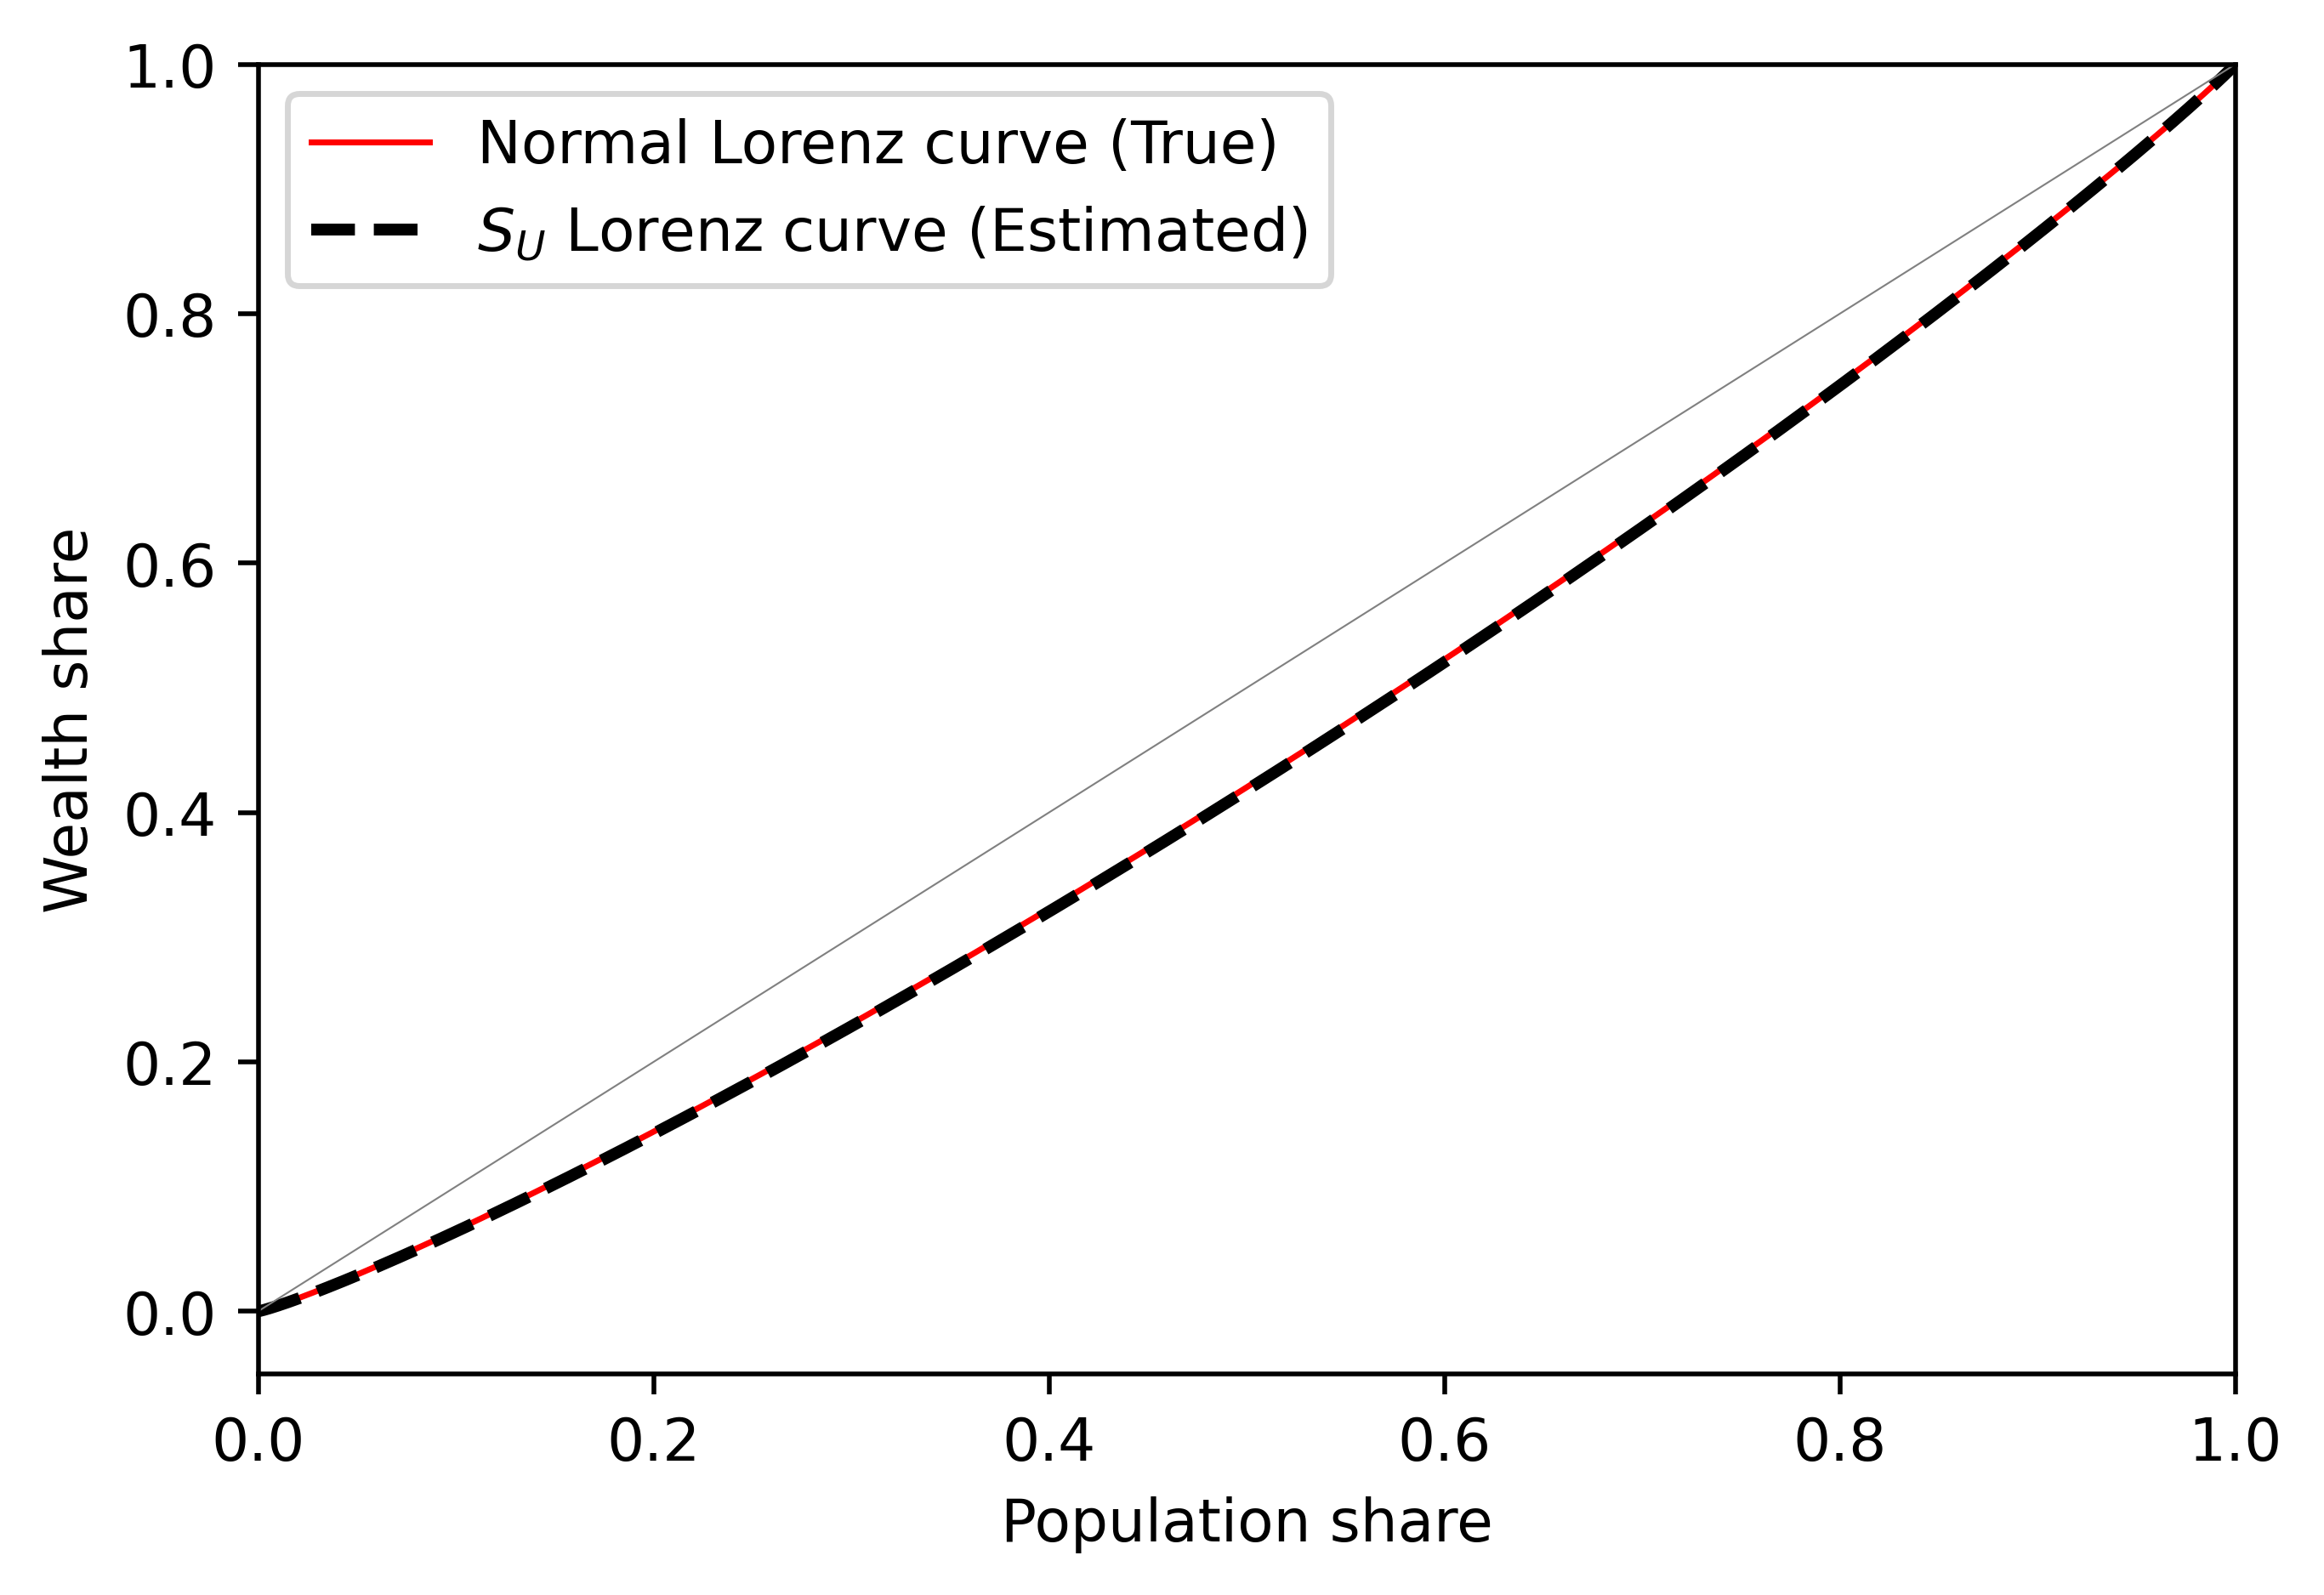

In [198]:
# SU Lorenz 곡선
plt.figure(figsize=(6, 4), dpi=500)

dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_normal(dist_X, mu, sigma),
         linewidth=1, linestyle='solid', color='r', label='Normal Lorenz curve (True)')
plt.plot(dist_X, Lorenz_SU(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=2, linestyle='dashed', color='k', label='$S_U$ Lorenz curve (Estimated)')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)

plt.xlabel('Population share')
plt.ylabel('Wealth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

### 로그정규분포 시뮬레이션

In [199]:
import numpy as np

np.random.seed(12)

mu = 5
sigma = 1
X = np.random.lognormal(mean=mu, sigma=sigma, size=1000)

In [200]:
import numpy as np

def lognormal_mean_and_std(mu, sigma):
    mean = np.exp(mu + sigma**2 / 2)
    std = np.sqrt((np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2))
    return mean, std

mean, std = lognormal_mean_and_std(mu, sigma)

print(f"Mean: {mean}, Standard Deviation: {std}")

Mean: 244.69193226422038, Standard Deviation: 320.75013593731506


In [201]:
m_init = 0
s_init = 0
lambda_init = 0
theta_init = 0

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(obj_SU_e, params_init, args=(X,),
                      method='L-BFGS-B')
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

s_MLE = np.exp(s_MLE)
theta_MLE = np.exp(theta_MLE)

print('m_MLE =',m_MLE, 's_MLE =',s_MLE, 'lambda_MLE =',lambda_MLE,
      'theta_MLE =',theta_MLE)
print("Objective function value at solution:", res_SU.fun)

m_MLE = -1.5201780137779866 s_MLE = 0.05817580155549158 lambda_MLE = 8.543164579305921 theta_MLE = 1.0080946086092333
Objective function value at solution: 6432.745067679978


In [202]:
print("Mean:", SU_mean(m_MLE, s_MLE, lambda_MLE, theta_MLE))
print("SD =", SU_var(m_MLE, s_MLE, lambda_MLE, theta_MLE)**0.5)
print("Skewness:", SU_skew(m_MLE, s_MLE, lambda_MLE, theta_MLE))
print("Kurtosis:", SU_kurt(m_MLE, s_MLE, lambda_MLE, theta_MLE))

Mean: 246.5865328066928
SD = 329.4150870407775
Skewness: 6.323679091827346
Kurtosis: 120.34419379568244


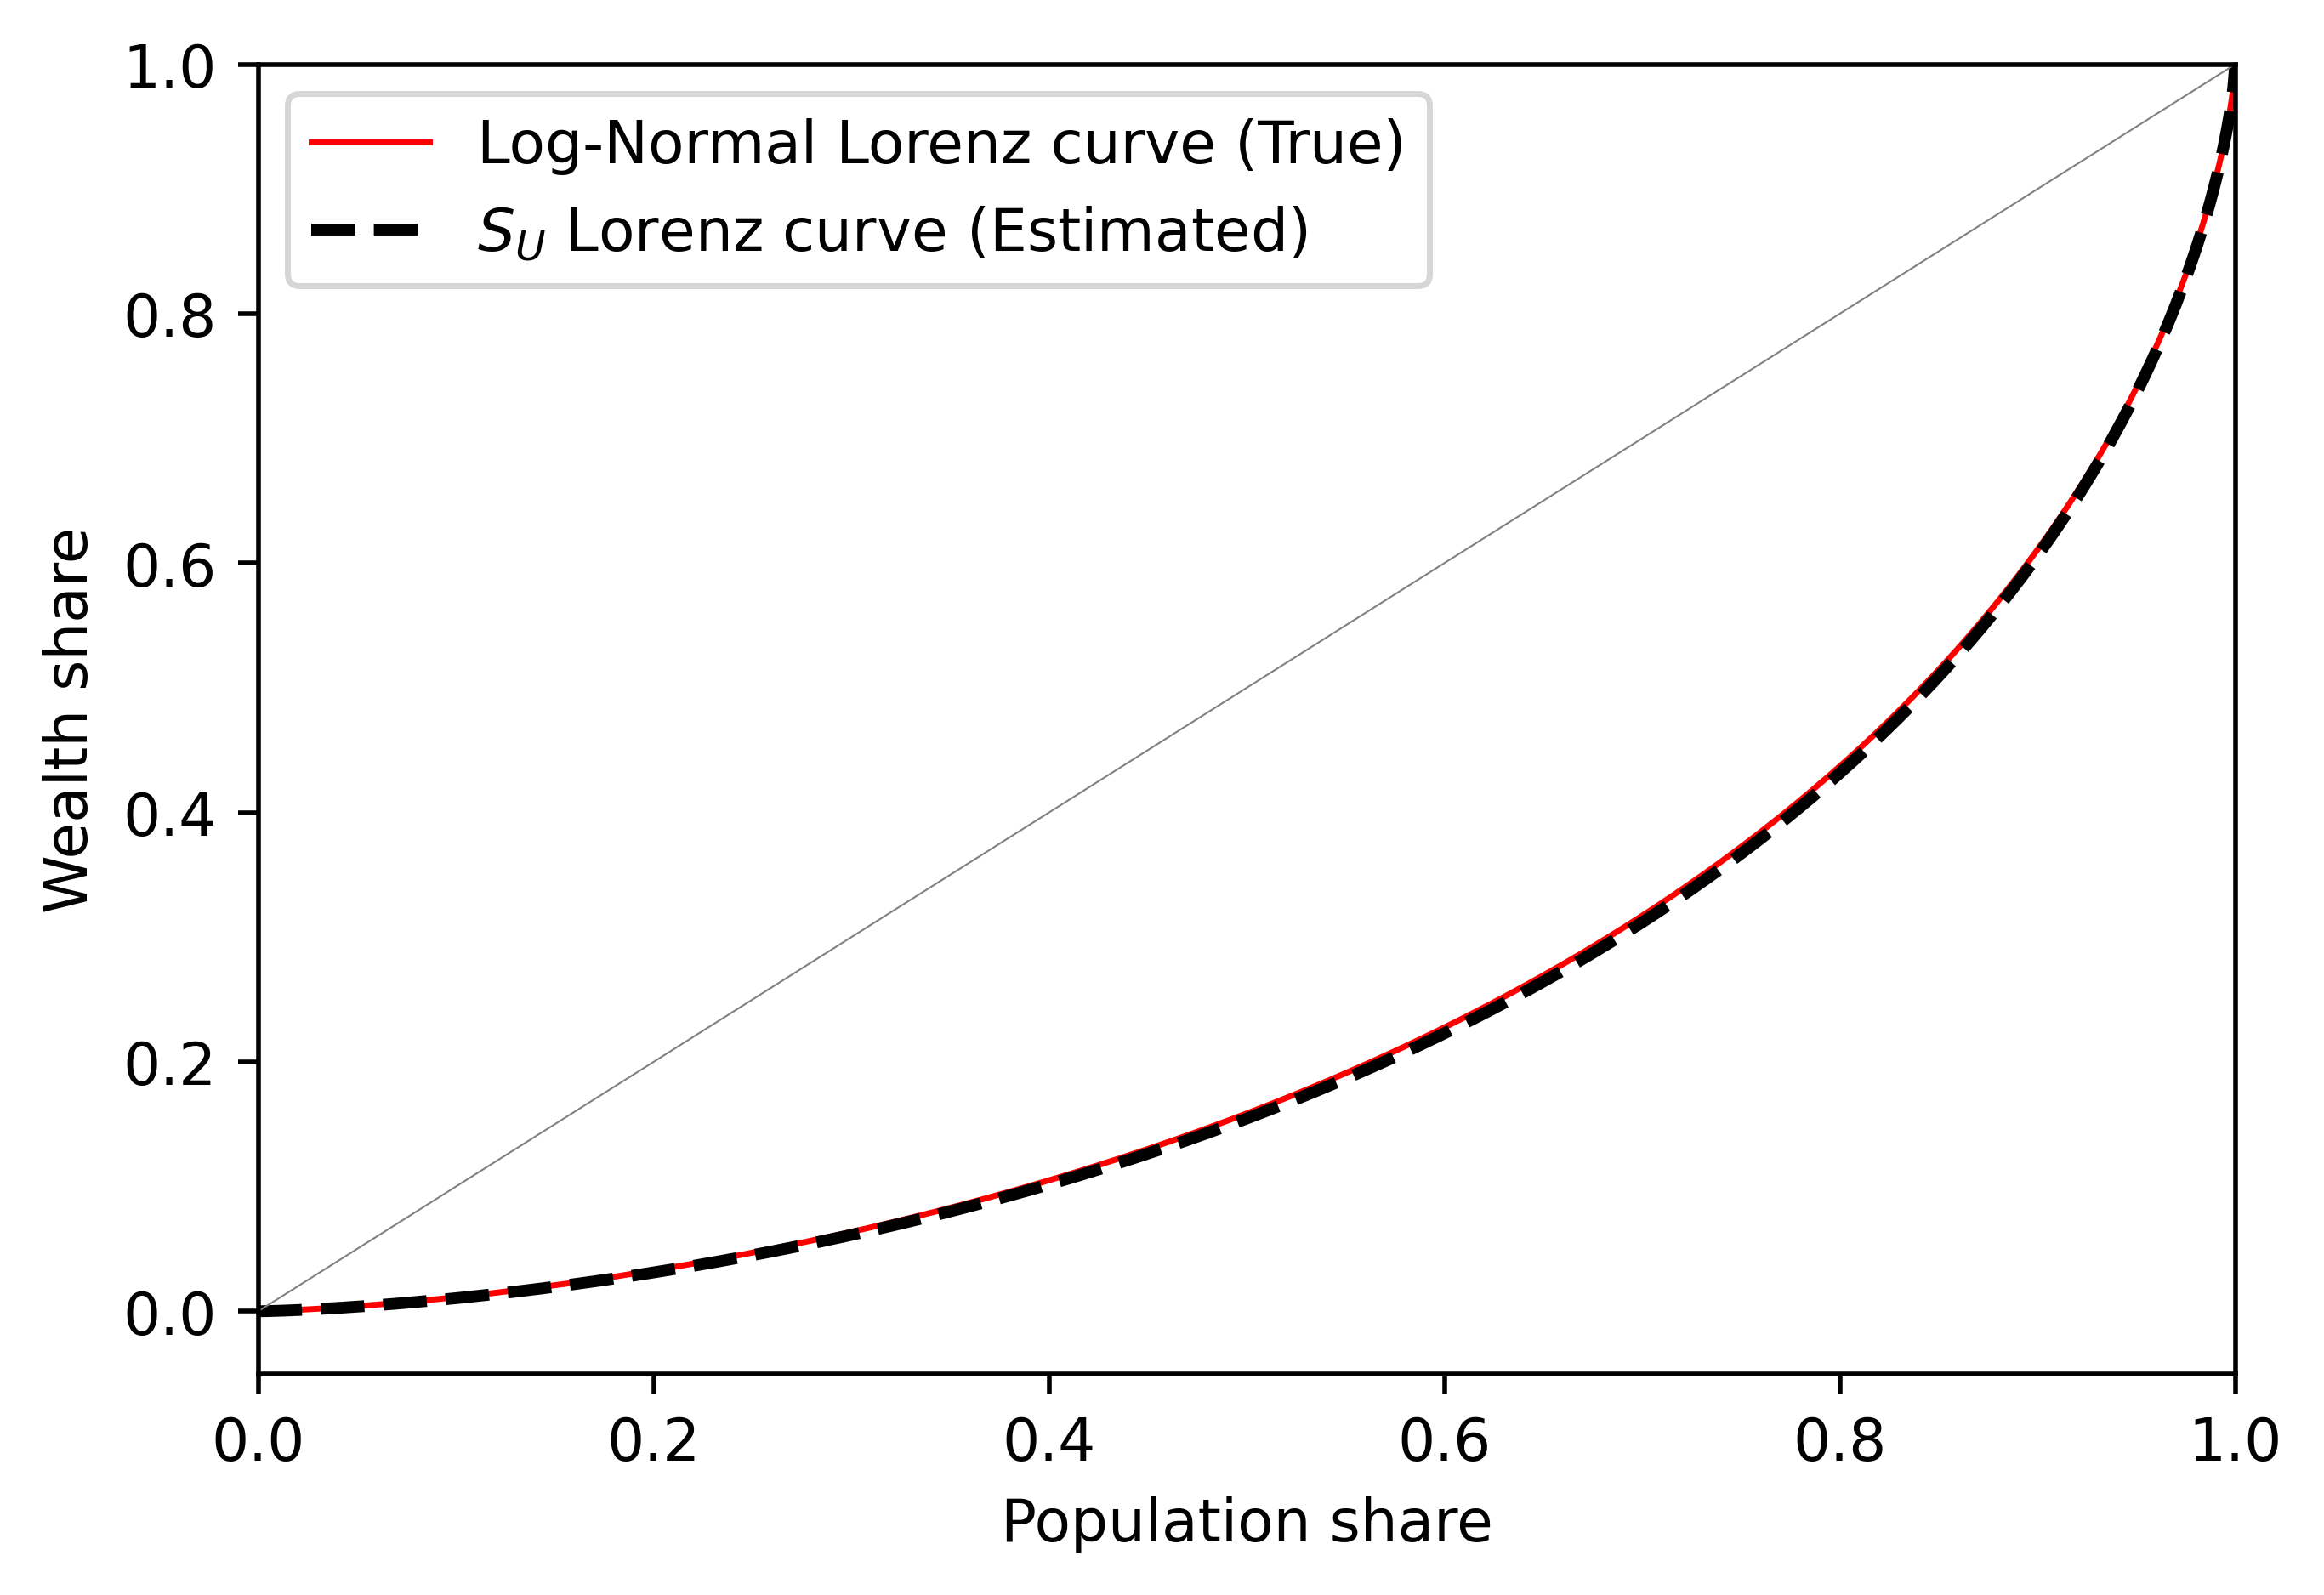

In [203]:
# SU Lorenz 곡선
plt.figure(figsize=(6, 4), dpi=500)

dist_X = np.linspace(0, 1, 1000)
plt.plot(dist_X, Lorenz_LN(dist_X, sigma),
         linewidth=1, linestyle='solid', color='r', label='Log-Normal Lorenz curve (True)')
plt.plot(dist_X, Lorenz_SU(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=2, linestyle='dashed', color='k', label='$S_U$ Lorenz curve (Estimated)')
plt.plot([0, 1], [0, 1], color = 'grey', linewidth = 0.3)

plt.xlabel('Population share')
plt.ylabel('Wealth share')
plt.ylim(-0.05, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()